In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [2]:
import os
import logging

def set_affinity(pid, cores):
    os.sched_setaffinity(pid, cores)
set_affinity(0, {21,22,23,24,25,26,27,28,43,44,45,46,47})
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
train = pd.read_csv('//data/home/brian1501/Minsu/Pregnant/train/data/train.csv').drop(columns=['ID'])
test = pd.read_csv('/data/home/brian1501/Minsu/Pregnant/train/data/test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [245]:
train["저장된 신선 난자 수"]

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
256346    0.0
256347    0.0
256348    0.0
256349    0.0
256350    0.0
Name: 저장된 신선 난자 수, Length: 256351, dtype: float64

In [4]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [ ]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


In [5]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', 'DI 임신 횟수',"DI 출산 횟수"]
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 65), (90067, 64))

In [6]:
import pandas as pd

# 예제 데이터 (train 데이터프레임이 있다고 가정)
category_stats = {
    "배아 생성 주요 이유": [
        "기증용, 현재 시술용", "기증용, 배아 저장용, 현재 시술용", "현재 시술용", "배아 저장용, 현재 시술용",
        "난자 저장용, 현재 시술용", "nan", "배아 저장용", "기증용", "기증용, 난자 저장용", "기증용, 배아 저장용",
        "난자 저장용", "난자 저장용, 배아 저장용", "난자 저장용, 배아 저장용, 연구용", "연구용, 현재 시술용"
    ],
    "임신 성공 비율": [0.379757, 0.350000, 0.273570, 0.265060, 0.200000, 0.128914, 
                 0.000870, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                 0.000000, 0.000000]
}

# 성공 비율 데이터프레임 생성
success_rate_df = pd.DataFrame(category_stats)

# 임신 성공 비율이 0.1보다 낮은 카테고리 리스트 만들기
low_success_categories = success_rate_df[success_rate_df["임신 성공 비율"] < 0.1]["배아 생성 주요 이유"].tolist()

# train 데이터프레임에서 해당 카테고리를 "나머지"로 변경
train["배아 생성 주요 이유"] = train["배아 생성 주요 이유"].apply(lambda x: "나머지" if x in low_success_categories else x)
train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'
train["저장된 신선 난자 수"] = train["저장된 신선 난자 수"].apply(
    lambda x: "알 수 없음" if pd.isna(x) else ("0개" if x == 0.0 else "1개 이상")
)
test["배아 생성 주요 이유"] = test["배아 생성 주요 이유"].apply(lambda x: "나머지" if x in low_success_categories else x)
test.loc[test['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'
test["저장된 신선 난자 수"] = test["저장된 신선 난자 수"].apply(
    lambda x: "알 수 없음" if pd.isna(x) else ("0개" if x == 0.0 else "1개 이상")
)


In [7]:
nan_col_list = ['PGD 시술 여부', 'PGS 시술 여부','착상 전 유전 검사 사용 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)
 
nan_col_list = ['착상 전 유전 진단 사용 여부' ]   

for col in nan_col_list:
    train[col] = train[col].fillna(1)
    test[col] = test[col].fillna(1)   

In [8]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [9]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 63), (90067, 62))

In [10]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [11]:
# num_cols_to_clip = [
#     '총 생성 배아 수', '미세주입된 난자 수', '수집된 신선 난자 수',
#     '저장된 배아 수', '해동된 배아 수', '해동 난자 수', '혼합된 난자 수'
# ]

# for col in num_cols_to_clip:
#     if col not in train.columns:
#         continue  # 실제 존재하는 컬럼에만 적용
#     # 훈련셋 기준으로 clip 범위 계산
#     # lower_p = train[col].quantile(0.01)
#     upper_p = train[col].quantile(0.99)
#     # 실제 clip
#     train[col] = train[col].clip(lower=lower_p, upper=upper_p)
#     test[col]  = test[col].clip(lower=lower_p, upper=upper_p)

# (참고) 특정 컬럼을 임의 값으로 직접 clip할 때 예시
# train['수집된 신선 난자 수'] = train['수집된 신선 난자 수'].clip(upper=30)
# test['수집된 신선 난자 수']  = test['수집된 신선 난자 수'].clip(upper=30)

# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
# if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
#     bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
#     labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
#     train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
#     test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=30)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=30)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [12]:
train.loc[train['정자 기증자 나이'] == '만20세 이하', '정자 기증자 나이'] = '만0-20세'
train.loc[train['정자 기증자 나이'] == '알 수 없음', '정자 기증자 나이'] = '만31-35세'

test.loc[test['정자 기증자 나이'] == '만20세 이하', '정자 기증자 나이'] = '만0-20세'
test.loc[test['정자 기증자 나이'] == '알 수 없음', '정자 기증자 나이'] = '만31-35세'

train.loc[train['난자 기증자 나이'] == '만20세 이하', '난자 기증자 나이'] = '만0-20세'
train.loc[train['난자 기증자 나이'] == '알 수 없음', '난자 기증자 나이'] ='만0-20세'

test.loc[test['난자 기증자 나이'] == '만20세 이하', '난자 기증자 나이'] = '만0-20세'
test.loc[test['난자 기증자 나이'] == '알 수 없음', '난자 기증자 나이'] ='만0-20세'
def parse_age_range(age_range):
    """ '만18-34세' 같은 범위를 [18, 34] 로 변환 """
    age_range = age_range.replace('만', '').replace('세', '')
    start, end = map(int, age_range.split('-'))
    return (start, end)

# 시술 당시 나이와 정자 기증자 나이를 숫자 범위로 변환
train['시술 나이 범위'] = train['시술 당시 나이'].apply(parse_age_range)
train['기증자 나이 범위'] = train['정자 기증자 나이'].apply(parse_age_range)
test['시술 나이 범위'] = test['시술 당시 나이'].apply(parse_age_range)
test['기증자 나이 범위'] = test['정자 기증자 나이'].apply(parse_age_range)


# 새로운 범위 계산 (시술 당시 나이 - 정자 기증자 나이)
def calculate_new_range(row):
    s_start, s_end = row['시술 나이 범위']
    d_start, d_end = row['기증자 나이 범위']
    return f"{s_start - d_end}-{s_end - d_start}세"

train['시술 정자'] = train.apply(calculate_new_range, axis=1)
test['시술 정자'] = test.apply(calculate_new_range, axis=1)
train.drop(columns =['시술 나이 범위','기증자 나이 범위'],inplace = True )
test.drop(columns =['시술 나이 범위','기증자 나이 범위'],inplace = True )


train['시술 나이 범위'] = train['시술 당시 나이'].apply(parse_age_range)
train['기증자 나이 범위'] = train['난자 기증자 나이'].apply(parse_age_range)
test['시술 나이 범위'] = test['시술 당시 나이'].apply(parse_age_range)
test['기증자 나이 범위'] = test['난자 기증자 나이'].apply(parse_age_range)


train['시술 난자'] = train.apply(calculate_new_range, axis=1)
test['시술 난자'] = test.apply(calculate_new_range, axis=1)
train.drop(columns =['시술 나이 범위','기증자 나이 범위'],inplace = True )
test.drop(columns =['시술 나이 범위','기증자 나이 범위'],inplace = True )


# train 데이터 처리




In [ ]:
# procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
#                            'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
#                            'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
#                            'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
#                            'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
#                            'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
#                            'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
#                            'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
#                            'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
#                            'IVF:Unknown:Unknown:Unknown' : 'IVF'}

# train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
# test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [ ]:
# train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
# test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
# train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
# test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

# train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
# test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
# train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
# test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
# train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
# test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


# drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
#                  '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
#                  '부부 주 불임 원인', '부부 부 불임 원인']
# train.drop(columns=drop_columns3, inplace=True)
# test.drop(columns=drop_columns3, inplace=True)

In [ ]:
train.columns

In [13]:
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    # "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    # "총 시술 횟수",
    # "클리닉 내 총 시술 횟수",
    # "IVF 시술 횟수",
    "DI 시술 횟수",
    # "총 임신 횟수",
    # "IVF 임신 횟수",
    # "DI 임신 횟수",
    # "총 출산 횟수",
    # "IVF 출산 횟수",
    # "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부",
    '시술 정자',
    '시술 난자',
        "저장된 신선 난자 수","총_생성_배아_bin"
]
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]+['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수']

for col in categorical_columns:
  if col in train.columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

# numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
#                    "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
#                     '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
#        '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
#        '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# # numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
# #                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
# #                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
# #                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if col in train.columns:
    if train[col].isna().sum():
      if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
        train[col].fillna(-1, inplace=True)  # -1로 대체
        test[col].fillna(-1, inplace = True)
      else:
        mode_value = train[col].mode()[0]  # 최빈값 구하기
        train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
        test[col].fillna(mode_value, inplace = True)


In [243]:
set(train["저장된 신선 난자 수"])

{'0개', '1개 이상', '알 수 없음'}

In [14]:
# train["저장된 신선 난자 수"] = train["저장된 신선 난자 수"].apply(lambda x: 20.0 if x >= 20 else x)
train["해동 난자 수"] = train["해동 난자 수"].apply(lambda x: 20.0 if x >= 20 else x)
train["미세주입 후 저장된 배아 수"] = train["미세주입 후 저장된 배아 수"].apply(lambda x: 20.0 if x >= 20 else x)

# test 데이터 처리
# test["저장된 신선 난자 수"] = test["저장된 신선 난자 수"].apply(lambda x: 20.0 if x >= 20 else x)
test["해동 난자 수"] = test["해동 난자 수"].apply(lambda x: 20.0 if x >= 20 else x)
test["미세주입 후 저장된 배아 수"] = test["미세주입 후 저장된 배아 수"].apply(lambda x: 20.0 if x >= 20 else x)


In [239]:
train["저장된 신선 난자 수"][0]

'0개'

In [15]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [16]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 72), (90067, 72))

In [ ]:
y.value_counts()

In [18]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU",devices='2')
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, early_stopping_rounds=200,class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [26]:
set(train["총_생성_배아_bin"])

{'0', '11~15', '16~20', '1~5', '21이상', '6~10'}

In [17]:
import pandas as pd

for col in categorical_columns:
    unique_types = set(type(x) for x in train[col])
    # int 또는 str이 아닌 타입이 섞여 있는지 확인
    non_int_str_types = [t for t in unique_types if t not in (int, str)]
    
    if len(non_int_str_types) > 0:
        print(f"컬럼명: {col}")
        print(f"  발견된 타입들: {unique_types}")
        print(f"  int/str가 아닌 타입: {non_int_str_types}")
        print("-" * 40)


In [22]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)
test_pred_cat_total = []
test_pred_lgbm_total = []
# test_pred_xgb_total = []
y_val_total = []
val_pred_cat_total = []
val_pred_lgbm_total = []
# val_pred_xgb_total = []

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    y_val_total.append(y_val)
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU" ,devices='2')
    model.load_model("/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_gpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="GPU" )
    # model_gpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_gpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,early_stopping_rounds=200,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    val_pred_cat_total.append(val_pred)
    val_pred_lgbm_total.append(val_pred_lgbm)

    
    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))
    
    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)
    test_pred_cat_total.append(test_pred)
    test_pred_lgbm_total.append(test_pred_lgbm)


[I 2025-02-23 03:37:12,667] A new study created in memory with name: no-name-8305f863-68a7-41c1-938b-e7d229d64d91


Seed 4972 Start!


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7287047	best: 0.7287047 (0)	total: 83.2ms	remaining: 3m 16s
300:	test: 0.7389837	best: 0.7389837 (300)	total: 24.5s	remaining: 2m 47s
600:	test: 0.7402311	best: 0.7402477 (589)	total: 48.9s	remaining: 2m 23s
900:	test: 0.7403706	best: 0.7404835 (806)	total: 1m 13s	remaining: 1m 59s
bestTest = 0.7404834628
bestIteration = 806
Shrink model to first 807 iterations.


[I 2025-02-23 03:38:45,374] Trial 0 finished with value: 0.7404834628105164 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7404834628105164.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 25.7ms	remaining: 56.4s
300:	test: 0.7312410	best: 0.7312410 (300)	total: 5.28s	remaining: 33.2s
600:	test: 0.7346237	best: 0.7346237 (600)	total: 9.55s	remaining: 25.3s
900:	test: 0.7364347	best: 0.7364347 (900)	total: 13.9s	remaining: 19.9s
1200:	test: 0.7374796	best: 0.7374803 (1198)	total: 18.2s	remaining: 15s
1500:	test: 0.7381836	best: 0.7381836 (1500)	total: 22.5s	remaining: 10.4s
1800:	test: 0.7387230	best: 0.7387230 (1800)	total: 26.8s	remaining: 5.84s
2100:	test: 0.7390698	best: 0.7390698 (2100)	total: 31.2s	remaining: 1.37s
2192:	test: 0.7391580	best: 0.7391590 (2191)	total: 32.5s	remaining: 0us
bestTest = 0.7391590178
bestIteration = 2191
Shrink model to first 2192 iterations.


[I 2025-02-23 03:39:21,935] Trial 1 finished with value: 0.7391590178012848 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7404834628105164.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 26.9ms	remaining: 1m 8s
300:	test: 0.7398319	best: 0.7398936 (268)	total: 5.32s	remaining: 39.5s
600:	test: 0.7401033	best: 0.7401584 (384)	total: 9.7s	remaining: 31.2s
900:	test: 0.7401159	best: 0.7402039 (652)	total: 14.1s	remaining: 25.6s


[I 2025-02-23 03:39:40,856] Trial 2 finished with value: 0.7402039468288422 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7404834628105164.


bestTest = 0.7402039468
bestIteration = 652
Shrink model to first 653 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 25.2ms	remaining: 58.8s
300:	test: 0.7393458	best: 0.7393485 (299)	total: 5.51s	remaining: 37.2s
600:	test: 0.7401175	best: 0.7401362 (580)	total: 9.83s	remaining: 28.4s
900:	test: 0.7403813	best: 0.7403813 (900)	total: 14.2s	remaining: 22.6s
1200:	test: 0.7405465	best: 0.7405479 (1180)	total: 18.6s	remaining: 17.6s
1500:	test: 0.7408674	best: 0.7408753 (1498)	total: 23s	remaining: 12.8s
1800:	test: 0.7408699	best: 0.7409312 (1545)	total: 27.4s	remaining: 8.12s
bestTest = 0.7409311831
bestIteration = 1545
Shrink model to first 1546 iterations.


[I 2025-02-23 03:40:13,189] Trial 3 finished with value: 0.7409311830997467 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7409311830997467.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7271529	best: 0.7271529 (0)	total: 115ms	remaining: 3m 20s
300:	test: 0.7374293	best: 0.7374736 (293)	total: 26.6s	remaining: 2m 7s
600:	test: 0.7376026	best: 0.7378853 (402)	total: 51s	remaining: 1m 36s
bestTest = 0.7378852963
bestIteration = 402
Shrink model to first 403 iterations.


[I 2025-02-23 03:41:16,732] Trial 4 finished with value: 0.7378852963447571 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7409311830997467.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 26.6ms	remaining: 55.3s
300:	test: 0.7397902	best: 0.7398066 (298)	total: 5.74s	remaining: 34s
600:	test: 0.7398763	best: 0.7401089 (406)	total: 10.3s	remaining: 25.4s
bestTest = 0.7401088774
bestIteration = 406
Shrink model to first 407 iterations.


[I 2025-02-23 03:41:32,569] Trial 5 finished with value: 0.7401088774204254 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7409311830997467.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153791	best: 0.7153791 (0)	total: 33ms	remaining: 1m 5s
300:	test: 0.7405697	best: 0.7406689 (274)	total: 6.62s	remaining: 37.3s
600:	test: 0.7408861	best: 0.7409180 (597)	total: 12.2s	remaining: 28.3s
900:	test: 0.7410738	best: 0.7410738 (900)	total: 17.7s	remaining: 21.6s
1200:	test: 0.7407724	best: 0.7410738 (900)	total: 23.3s	remaining: 15.5s
bestTest = 0.7410737872
bestIteration = 900
Shrink model to first 901 iterations.


[I 2025-02-23 03:42:00,011] Trial 6 finished with value: 0.7410737872123718 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7410737872123718.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218023	best: 0.7218023 (0)	total: 49.8ms	remaining: 1m 35s
300:	test: 0.7392648	best: 0.7405679 (199)	total: 12s	remaining: 1m 4s
bestTest = 0.740567863
bestIteration = 199
Shrink model to first 200 iterations.


[I 2025-02-23 03:42:23,000] Trial 7 finished with value: 0.7405678629875183 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7410737872123718.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218280	best: 0.7218280 (0)	total: 34.1ms	remaining: 1m 4s
300:	test: 0.7406315	best: 0.7407406 (283)	total: 8.95s	remaining: 47.7s
600:	test: 0.7405237	best: 0.7408898 (438)	total: 17.7s	remaining: 38.5s
bestTest = 0.7408898175
bestIteration = 438
Shrink model to first 439 iterations.


[I 2025-02-23 03:42:48,654] Trial 8 finished with value: 0.7408898174762726 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7410737872123718.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7221259	best: 0.7221259 (0)	total: 41.5ms	remaining: 1m 49s
300:	test: 0.7398853	best: 0.7399053 (293)	total: 7.73s	remaining: 1m
600:	test: 0.7404937	best: 0.7405131 (549)	total: 14.6s	remaining: 49.6s
900:	test: 0.7406610	best: 0.7407231 (842)	total: 21.5s	remaining: 41.5s
bestTest = 0.7407230735
bestIteration = 842
Shrink model to first 843 iterations.


[I 2025-02-23 03:43:19,911] Trial 9 finished with value: 0.7407230734825134 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7410737872123718.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220384	best: 0.7220384 (0)	total: 40.4ms	remaining: 1m 59s
300:	test: 0.7412205	best: 0.7412289 (293)	total: 7.75s	remaining: 1m 8s
600:	test: 0.7410851	best: 0.7412975 (459)	total: 14.6s	remaining: 57.1s
bestTest = 0.7412974536
bestIteration = 459
Shrink model to first 460 iterations.


[I 2025-02-23 03:43:42,257] Trial 10 finished with value: 0.7412974536418915 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 10 with value: 0.7412974536418915.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220854	best: 0.7220854 (0)	total: 25.7ms	remaining: 1m 16s
300:	test: 0.7411664	best: 0.7411703 (299)	total: 6.92s	remaining: 1m 1s
600:	test: 0.7410240	best: 0.7412131 (365)	total: 13.9s	remaining: 55.2s
bestTest = 0.7412130535
bestIteration = 365
Shrink model to first 366 iterations.


[I 2025-02-23 03:44:01,634] Trial 11 finished with value: 0.7412130534648895 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220396	best: 0.7220396 (0)	total: 32.3ms	remaining: 1m 33s
300:	test: 0.7409493	best: 0.7409498 (293)	total: 7.72s	remaining: 1m 6s
600:	test: 0.7410495	best: 0.7411514 (444)	total: 14.6s	remaining: 55.8s
bestTest = 0.7411513925
bestIteration = 444
Shrink model to first 445 iterations.


[I 2025-02-23 03:44:23,548] Trial 12 finished with value: 0.7411513924598694 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619733}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7255505	best: 0.7255505 (0)	total: 43.5ms	remaining: 2m 9s
300:	test: 0.7407573	best: 0.7410689 (231)	total: 11.7s	remaining: 1m 43s
bestTest = 0.7410688698
bestIteration = 231
Shrink model to first 232 iterations.


[I 2025-02-23 03:44:48,149] Trial 13 finished with value: 0.7410688698291779 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06703158786644411, 'l2_leaf_reg': 7.828901342687918}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248272	best: 0.7248272 (0)	total: 64.8ms	remaining: 2m 58s
300:	test: 0.7407777	best: 0.7409845 (240)	total: 12.3s	remaining: 1m 40s


[I 2025-02-23 03:45:13,526] Trial 14 finished with value: 0.7409845292568207 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.08100676431388791, 'l2_leaf_reg': 92.74223128282532}. Best is trial 10 with value: 0.7412974536418915.


bestTest = 0.7409845293
bestIteration = 240
Shrink model to first 241 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7221251	best: 0.7221251 (0)	total: 23.5ms	remaining: 35.5s
300:	test: 0.7407080	best: 0.7407723 (264)	total: 6.92s	remaining: 27.9s
600:	test: 0.7407331	best: 0.7408494 (435)	total: 13.8s	remaining: 21s
bestTest = 0.7408493757
bestIteration = 435
Shrink model to first 436 iterations.


[I 2025-02-23 03:45:34,405] Trial 15 finished with value: 0.7408493757247925 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.05972793605769974, 'l2_leaf_reg': 9.663069382488281}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244724	best: 0.7244724 (0)	total: 58.2ms	remaining: 2m 42s
300:	test: 0.7396379	best: 0.7402497 (195)	total: 12.5s	remaining: 1m 42s
bestTest = 0.7402496934
bestIteration = 195
Shrink model to first 196 iterations.


[I 2025-02-23 03:45:58,295] Trial 16 finished with value: 0.7402496933937073 and parameters: {'iterations': 2788, 'depth': 8, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 1.8815744634882094}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153738	best: 0.7153738 (0)	total: 20.5ms	remaining: 1m 1s
300:	test: 0.7405313	best: 0.7406253 (256)	total: 5.88s	remaining: 52.7s
600:	test: 0.7406588	best: 0.7406998 (597)	total: 11.4s	remaining: 45.7s
900:	test: 0.7403224	best: 0.7407077 (616)	total: 17s	remaining: 39.6s
bestTest = 0.7407076955
bestIteration = 616
Shrink model to first 617 iterations.


[I 2025-02-23 03:46:19,577] Trial 17 finished with value: 0.7407076954841614 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.09756908568640506, 'l2_leaf_reg': 17.97132158843658}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153808	best: 0.7153808 (0)	total: 33.4ms	remaining: 1m 22s
300:	test: 0.7406700	best: 0.7406726 (298)	total: 6.6s	remaining: 47.8s
600:	test: 0.7410166	best: 0.7410772 (566)	total: 12.1s	remaining: 37.9s
900:	test: 0.7410139	best: 0.7411150 (675)	total: 17.7s	remaining: 31s
bestTest = 0.741114974
bestIteration = 675
Shrink model to first 676 iterations.


[I 2025-02-23 03:46:42,763] Trial 18 finished with value: 0.7411149740219116 and parameters: {'iterations': 2482, 'depth': 5, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 27.476376202913}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7262791	best: 0.7262791 (0)	total: 77.1ms	remaining: 3m 33s
300:	test: 0.7403117	best: 0.7404945 (241)	total: 16.9s	remaining: 2m 18s
600:	test: 0.7396642	best: 0.7405816 (362)	total: 33s	remaining: 1m 59s
bestTest = 0.7405816317
bestIteration = 362
Shrink model to first 363 iterations.


[I 2025-02-23 03:47:23,124] Trial 19 finished with value: 0.7405816316604614 and parameters: {'iterations': 2774, 'depth': 9, 'learning_rate': 0.03744929706975118, 'l2_leaf_reg': 2.763664557647676}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220373	best: 0.7220373 (0)	total: 42.1ms	remaining: 1m 52s
300:	test: 0.7409542	best: 0.7409987 (293)	total: 10.1s	remaining: 1m 19s
600:	test: 0.7409583	best: 0.7411063 (428)	total: 18.6s	remaining: 1m 4s
bestTest = 0.7411062717
bestIteration = 428
Shrink model to first 429 iterations.


[I 2025-02-23 03:47:48,676] Trial 20 finished with value: 0.7411062717437744 and parameters: {'iterations': 2680, 'depth': 6, 'learning_rate': 0.08608942945026384, 'l2_leaf_reg': 99.4230842016086}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220950	best: 0.7220950 (0)	total: 33.3ms	remaining: 1m 36s
300:	test: 0.7409566	best: 0.7410178 (292)	total: 8.6s	remaining: 1m 14s
600:	test: 0.7409714	best: 0.7411867 (407)	total: 17.7s	remaining: 1m 7s
bestTest = 0.741186738
bestIteration = 407
Shrink model to first 408 iterations.


[I 2025-02-23 03:48:13,406] Trial 21 finished with value: 0.7411867380142212 and parameters: {'iterations': 2900, 'depth': 6, 'learning_rate': 0.07360126881183988, 'l2_leaf_reg': 33.894253733241015}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244581	best: 0.7244581 (0)	total: 32.9ms	remaining: 1m 34s
300:	test: 0.7411621	best: 0.7412554 (221)	total: 10.3s	remaining: 1m 28s
bestTest = 0.7412554026
bestIteration = 221
Shrink model to first 222 iterations.


[I 2025-02-23 03:48:36,147] Trial 22 finished with value: 0.7412554025650024 and parameters: {'iterations': 2884, 'depth': 7, 'learning_rate': 0.07426743788891002, 'l2_leaf_reg': 26.793808193554963}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244617	best: 0.7244617 (0)	total: 46.8ms	remaining: 2m 13s
300:	test: 0.7406344	best: 0.7407499 (226)	total: 10.5s	remaining: 1m 29s
bestTest = 0.7407498956
bestIteration = 226
Shrink model to first 227 iterations.


[I 2025-02-23 03:48:57,494] Trial 23 finished with value: 0.7407498955726624 and parameters: {'iterations': 2849, 'depth': 7, 'learning_rate': 0.08822301905998375, 'l2_leaf_reg': 24.246184155884656}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218433	best: 0.7218433 (0)	total: 54.4ms	remaining: 2m 20s
300:	test: 0.7409000	best: 0.7410778 (245)	total: 10s	remaining: 1m 16s
bestTest = 0.7410777807
bestIteration = 245
Shrink model to first 246 iterations.


[I 2025-02-23 03:49:18,688] Trial 24 finished with value: 0.7410777807235718 and parameters: {'iterations': 2590, 'depth': 7, 'learning_rate': 0.07589613702788456, 'l2_leaf_reg': 6.813512155558402}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153791	best: 0.7153791 (0)	total: 32.9ms	remaining: 1m 38s
300:	test: 0.7403628	best: 0.7403651 (299)	total: 6.52s	remaining: 58.3s
600:	test: 0.7408049	best: 0.7408548 (590)	total: 12s	remaining: 47.9s
900:	test: 0.7409657	best: 0.7409779 (897)	total: 17.6s	remaining: 40.8s
1200:	test: 0.7409795	best: 0.7410062 (1195)	total: 23.2s	remaining: 34.6s
1500:	test: 0.7408609	best: 0.7410975 (1279)	total: 28.8s	remaining: 28.6s
bestTest = 0.7410975099
bestIteration = 1279
Shrink model to first 1280 iterations.


[I 2025-02-23 03:49:53,179] Trial 25 finished with value: 0.7410975098609924 and parameters: {'iterations': 2992, 'depth': 5, 'learning_rate': 0.0633290210296596, 'l2_leaf_reg': 32.063075700063294}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7218319	best: 0.7218319 (0)	total: 34.4ms	remaining: 1m 24s
300:	test: 0.7407066	best: 0.7407770 (289)	total: 9.1s	remaining: 1m 4s
bestTest = 0.7407769561
bestIteration = 289
Shrink model to first 290 iterations.


[I 2025-02-23 03:50:14,780] Trial 26 finished with value: 0.7407769560813904 and parameters: {'iterations': 2442, 'depth': 7, 'learning_rate': 0.0742866838537976, 'l2_leaf_reg': 4.342397790956763}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7255529	best: 0.7255529 (0)	total: 38.5ms	remaining: 1m 43s
300:	test: 0.7402105	best: 0.7407259 (223)	total: 11.5s	remaining: 1m 30s
bestTest = 0.7407259047
bestIteration = 223
Shrink model to first 224 iterations.


[I 2025-02-23 03:50:38,833] Trial 27 finished with value: 0.7407259047031403 and parameters: {'iterations': 2679, 'depth': 8, 'learning_rate': 0.08707650873003747, 'l2_leaf_reg': 18.200106566109696}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7262798	best: 0.7262798 (0)	total: 84ms	remaining: 4m 3s
300:	test: 0.7398773	best: 0.7408092 (168)	total: 17s	remaining: 2m 26s
bestTest = 0.7408092022
bestIteration = 168
Shrink model to first 169 iterations.


[I 2025-02-23 03:51:09,004] Trial 28 finished with value: 0.7408092021942139 and parameters: {'iterations': 2895, 'depth': 9, 'learning_rate': 0.06461998844978646, 'l2_leaf_reg': 1.1744317755387594}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7221251	best: 0.7221251 (0)	total: 41.5ms	remaining: 1m 37s
300:	test: 0.7408444	best: 0.7410223 (256)	total: 7.99s	remaining: 54.7s


[I 2025-02-23 03:51:26,877] Trial 29 finished with value: 0.7410223186016083 and parameters: {'iterations': 2360, 'depth': 6, 'learning_rate': 0.0997987467417374, 'l2_leaf_reg': 10.190739489801594}. Best is trial 10 with value: 0.7412974536418915.


bestTest = 0.7410223186
bestIteration = 256
Shrink model to first 257 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7276857	best: 0.7276857 (0)	total: 69.6ms	remaining: 3m 14s
300:	test: 0.7403565	best: 0.7407897 (173)	total: 18.1s	remaining: 2m 30s
bestTest = 0.7407897115
bestIteration = 173
Shrink model to first 174 iterations.


[I 2025-02-23 03:51:58,200] Trial 30 finished with value: 0.7407897114753723 and parameters: {'iterations': 2797, 'depth': 9, 'learning_rate': 0.07384269980147438, 'l2_leaf_reg': 48.48528016113126}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220943	best: 0.7220943 (0)	total: 40.7ms	remaining: 1m 57s
300:	test: 0.7409042	best: 0.7409552 (292)	total: 9.42s	remaining: 1m 20s
600:	test: 0.7407604	best: 0.7410790 (457)	total: 17.8s	remaining: 1m 7s
bestTest = 0.7410789728
bestIteration = 457
Shrink model to first 458 iterations.


[I 2025-02-23 03:52:23,600] Trial 31 finished with value: 0.7410789728164673 and parameters: {'iterations': 2887, 'depth': 6, 'learning_rate': 0.0720822819667787, 'l2_leaf_reg': 35.60090780280767}. Best is trial 10 with value: 0.7412974536418915.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153791	best: 0.7153791 (0)	total: 22.1ms	remaining: 1m 4s
300:	test: 0.7408558	best: 0.7409180 (284)	total: 7.79s	remaining: 1m 7s
600:	test: 0.7413386	best: 0.7413620 (593)	total: 15.4s	remaining: 59.3s
900:	test: 0.7412918	best: 0.7414317 (635)	total: 24s	remaining: 53.6s
bestTest = 0.7414317131
bestIteration = 635
Shrink model to first 636 iterations.


[I 2025-02-23 03:52:52,634] Trial 32 finished with value: 0.741431713104248 and parameters: {'iterations': 2915, 'depth': 5, 'learning_rate': 0.07855414039603811, 'l2_leaf_reg': 44.77816585933678}. Best is trial 32 with value: 0.741431713104248.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153738	best: 0.7153738 (0)	total: 25.3ms	remaining: 1m 8s
300:	test: 0.7407117	best: 0.7407379 (264)	total: 6.85s	remaining: 54.7s
600:	test: 0.7412551	best: 0.7412929 (590)	total: 12.2s	remaining: 42.5s
900:	test: 0.7411006	best: 0.7413409 (655)	total: 17.5s	remaining: 35.1s
bestTest = 0.7413409352
bestIteration = 655
Shrink model to first 656 iterations.


[I 2025-02-23 03:53:15,201] Trial 33 finished with value: 0.7413409352302551 and parameters: {'iterations': 2702, 'depth': 5, 'learning_rate': 0.0815536976484682, 'l2_leaf_reg': 11.561933830208508}. Best is trial 32 with value: 0.741431713104248.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153738	best: 0.7153738 (0)	total: 21ms	remaining: 56.9s
300:	test: 0.7408104	best: 0.7408112 (299)	total: 6.69s	remaining: 53.5s
600:	test: 0.7410578	best: 0.7410922 (590)	total: 13.4s	remaining: 47.1s
900:	test: 0.7409497	best: 0.7412093 (655)	total: 20.3s	remaining: 40.7s
bestTest = 0.7412093282
bestIteration = 655
Shrink model to first 656 iterations.


[I 2025-02-23 03:53:40,548] Trial 34 finished with value: 0.7412093281745911 and parameters: {'iterations': 2708, 'depth': 5, 'learning_rate': 0.08012716961308441, 'l2_leaf_reg': 13.430650692083576}. Best is trial 32 with value: 0.741431713104248.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 25.7ms	remaining: 57.2s
300:	test: 0.7407647	best: 0.7407727 (299)	total: 4.17s	remaining: 26.7s
600:	test: 0.7409512	best: 0.7410044 (435)	total: 8.33s	remaining: 22.6s
900:	test: 0.7410390	best: 0.7410672 (702)	total: 12.5s	remaining: 18.5s
1200:	test: 0.7407341	best: 0.7410718 (921)	total: 16.7s	remaining: 14.3s
bestTest = 0.7410717607
bestIteration = 921
Shrink model to first 922 iterations.


[I 2025-02-23 03:54:01,564] Trial 35 finished with value: 0.7410717606544495 and parameters: {'iterations': 2231, 'depth': 4, 'learning_rate': 0.0901597085285444, 'l2_leaf_reg': 3.69184735172986}. Best is trial 32 with value: 0.741431713104248.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153738	best: 0.7153738 (0)	total: 31.1ms	remaining: 1m 17s
300:	test: 0.7410452	best: 0.7410577 (299)	total: 6.32s	remaining: 46.3s
600:	test: 0.7412462	best: 0.7413434 (568)	total: 11.6s	remaining: 36.9s
bestTest = 0.7413434088
bestIteration = 568
Shrink model to first 569 iterations.


[I 2025-02-23 03:54:22,021] Trial 36 finished with value: 0.7413434088230133 and parameters: {'iterations': 2505, 'depth': 5, 'learning_rate': 0.08394195030461032, 'l2_leaf_reg': 14.421938149457356}. Best is trial 32 with value: 0.741431713104248.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 21.6ms	remaining: 55.6s
300:	test: 0.7405814	best: 0.7405817 (299)	total: 4.6s	remaining: 34.7s
600:	test: 0.7409832	best: 0.7409832 (600)	total: 8.75s	remaining: 28.7s
900:	test: 0.7409112	best: 0.7410119 (612)	total: 13.7s	remaining: 25.3s
bestTest = 0.7410119176
bestIteration = 612
Shrink model to first 613 iterations.


[I 2025-02-23 03:54:40,191] Trial 37 finished with value: 0.741011917591095 and parameters: {'iterations': 2570, 'depth': 4, 'learning_rate': 0.09413474989929024, 'l2_leaf_reg': 6.764695895267549}. Best is trial 32 with value: 0.741431713104248.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153791	best: 0.7153791 (0)	total: 19.6ms	remaining: 48.4s
300:	test: 0.7408598	best: 0.7408648 (299)	total: 5.32s	remaining: 38.3s
600:	test: 0.7412030	best: 0.7412332 (590)	total: 11.7s	remaining: 36.2s
900:	test: 0.7410508	best: 0.7412428 (612)	total: 17s	remaining: 29.6s


[I 2025-02-23 03:55:01,164] Trial 38 finished with value: 0.7412427663803101 and parameters: {'iterations': 2467, 'depth': 5, 'learning_rate': 0.08374065845040025, 'l2_leaf_reg': 48.14335445781366}. Best is trial 32 with value: 0.741431713104248.


bestTest = 0.7412427664
bestIteration = 612
Shrink model to first 613 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117603	best: 0.7117603 (0)	total: 17.8ms	remaining: 41.3s
300:	test: 0.7404264	best: 0.7404264 (300)	total: 5.02s	remaining: 33.7s
600:	test: 0.7408472	best: 0.7408502 (589)	total: 9.61s	remaining: 27.5s
900:	test: 0.7409237	best: 0.7409930 (735)	total: 14s	remaining: 22.1s


[I 2025-02-23 03:55:20,954] Trial 39 finished with value: 0.7409929633140564 and parameters: {'iterations': 2323, 'depth': 4, 'learning_rate': 0.09015793327655677, 'l2_leaf_reg': 13.950952285730713}. Best is trial 32 with value: 0.741431713104248.
[I 2025-02-23 03:55:20,961] A new study created in memory with name: no-name-dbc57bbf-a5a1-44c0-87f4-484ee86e0983


bestTest = 0.7409929633
bestIteration = 735
Shrink model to first 736 iterations.


[I 2025-02-23 03:55:25,014] Trial 0 finished with value: 0.7408656929575724 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7408656929575724.
[I 2025-02-23 03:55:37,113] Trial 1 finished with value: 0.7410486538295885 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7410486538295885.
[I 2025-02-23 03:55:43,753] Trial 2 finished with value: 0.7402733830430904 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7414316613983587
LGBM val score : 0.7414513956649049
Ensemble val score : 0.7417649918225091


[I 2025-02-23 03:58:13,479] A new study created in memory with name: no-name-a084520a-ed78-48b3-ba60-71780d25c3c4


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208875	best: 0.7208875 (0)	total: 81ms	remaining: 3m 11s
300:	test: 0.7336387	best: 0.7336387 (300)	total: 24.7s	remaining: 2m 49s
600:	test: 0.7349491	best: 0.7349514 (597)	total: 49s	remaining: 2m 24s
900:	test: 0.7353797	best: 0.7353797 (900)	total: 1m 13s	remaining: 1m 59s
1200:	test: 0.7355372	best: 0.7355372 (1200)	total: 1m 37s	remaining: 1m 34s
1500:	test: 0.7354930	best: 0.7355927 (1336)	total: 2m 2s	remaining: 1m 10s
bestTest = 0.7355927229
bestIteration = 1336
Shrink model to first 1337 iterations.


[I 2025-02-23 04:00:29,355] Trial 0 finished with value: 0.7355927228927612 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7355927228927612.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 30.1ms	remaining: 1m 6s
300:	test: 0.7246436	best: 0.7246436 (300)	total: 6.98s	remaining: 43.9s
600:	test: 0.7287106	best: 0.7287106 (600)	total: 13s	remaining: 34.3s
900:	test: 0.7307952	best: 0.7307952 (900)	total: 19.5s	remaining: 27.9s
1200:	test: 0.7320632	best: 0.7320632 (1200)	total: 24.4s	remaining: 20.1s
1500:	test: 0.7327748	best: 0.7327748 (1500)	total: 28.5s	remaining: 13.1s
1800:	test: 0.7333182	best: 0.7333182 (1800)	total: 32.6s	remaining: 7.09s
2100:	test: 0.7336618	best: 0.7336618 (2100)	total: 36.7s	remaining: 1.61s
2192:	test: 0.7337638	best: 0.7337645 (2190)	total: 38s	remaining: 0us
bestTest = 0.7337645292
bestIteration = 2190
Shrink model to first 2191 iterations.


[I 2025-02-23 04:01:11,346] Trial 1 finished with value: 0.7337645292282104 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7355927228927612.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 26.1ms	remaining: 1m 6s
300:	test: 0.7350057	best: 0.7350268 (299)	total: 5.99s	remaining: 44.4s
600:	test: 0.7357311	best: 0.7358327 (574)	total: 11.5s	remaining: 37s


[I 2025-02-23 04:01:31,860] Trial 2 finished with value: 0.7358327209949493 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7358327209949493.


bestTest = 0.735832721
bestIteration = 574
Shrink model to first 575 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 25.1ms	remaining: 58.6s
300:	test: 0.7338884	best: 0.7338884 (299)	total: 4.84s	remaining: 32.7s
600:	test: 0.7350174	best: 0.7350204 (591)	total: 8.91s	remaining: 25.7s
900:	test: 0.7353732	best: 0.7353732 (900)	total: 13.1s	remaining: 20.8s
1200:	test: 0.7355950	best: 0.7356113 (1174)	total: 17.2s	remaining: 16.3s
1500:	test: 0.7357184	best: 0.7357397 (1360)	total: 21.4s	remaining: 11.9s
1800:	test: 0.7357503	best: 0.7357705 (1649)	total: 26.7s	remaining: 7.9s
2100:	test: 0.7358096	best: 0.7358232 (2097)	total: 32.1s	remaining: 3.56s
2333:	test: 0.7358378	best: 0.7358531 (2144)	total: 36.4s	remaining: 0us
bestTest = 0.7358531356
bestIteration = 2144
Shrink model to first 2145 iterations.


[I 2025-02-23 04:02:12,707] Trial 3 finished with value: 0.7358531355857849 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7358531355857849.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7207180	best: 0.7207180 (0)	total: 105ms	remaining: 3m 2s
300:	test: 0.7330846	best: 0.7331069 (296)	total: 24.7s	remaining: 1m 58s
600:	test: 0.7336525	best: 0.7341259 (447)	total: 49s	remaining: 1m 33s
bestTest = 0.7341258824
bestIteration = 447
Shrink model to first 448 iterations.


[I 2025-02-23 04:03:17,834] Trial 4 finished with value: 0.7341258823871613 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7358531355857849.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 16ms	remaining: 33.2s
300:	test: 0.7346125	best: 0.7346502 (299)	total: 4.5s	remaining: 26.7s
600:	test: 0.7352920	best: 0.7353036 (560)	total: 8.64s	remaining: 21.3s
900:	test: 0.7355354	best: 0.7355497 (805)	total: 12.8s	remaining: 16.8s
1200:	test: 0.7356187	best: 0.7356384 (1178)	total: 17s	remaining: 12.5s
1500:	test: 0.7356967	best: 0.7357055 (1496)	total: 21.1s	remaining: 8.18s
1800:	test: 0.7354089	best: 0.7357108 (1538)	total: 25.3s	remaining: 3.95s
bestTest = 0.7357107997
bestIteration = 1538
Shrink model to first 1539 iterations.


[I 2025-02-23 04:03:47,557] Trial 5 finished with value: 0.7357107996940613 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7358531355857849.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085915	best: 0.7085915 (0)	total: 32.3ms	remaining: 1m 4s
300:	test: 0.7354539	best: 0.7354802 (296)	total: 6.41s	remaining: 36.1s
600:	test: 0.7358828	best: 0.7359684 (513)	total: 11.7s	remaining: 27.2s
900:	test: 0.7359369	best: 0.7360846 (701)	total: 17.1s	remaining: 20.8s
bestTest = 0.73608464
bestIteration = 701
Shrink model to first 702 iterations.


[I 2025-02-23 04:04:10,555] Trial 6 finished with value: 0.7360846400260925 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7360846400260925.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172658	best: 0.7172658 (0)	total: 45.5ms	remaining: 1m 27s
300:	test: 0.7352382	best: 0.7355390 (284)	total: 9.38s	remaining: 50.7s


[I 2025-02-23 04:04:32,117] Trial 7 finished with value: 0.7355389595031738 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7360846400260925.


bestTest = 0.7355389595
bestIteration = 284
Shrink model to first 285 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172752	best: 0.7172752 (0)	total: 40.8ms	remaining: 1m 17s
300:	test: 0.7349900	best: 0.7350512 (285)	total: 9.26s	remaining: 49.3s
600:	test: 0.7351092	best: 0.7354749 (456)	total: 17.8s	remaining: 38.6s
bestTest = 0.7354749441
bestIteration = 456
Shrink model to first 457 iterations.


[I 2025-02-23 04:04:58,537] Trial 8 finished with value: 0.7354749441146851 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7360846400260925.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7149307	best: 0.7149307 (0)	total: 37.4ms	remaining: 1m 38s
300:	test: 0.7345547	best: 0.7345576 (299)	total: 7.89s	remaining: 1m 1s
600:	test: 0.7355239	best: 0.7355391 (582)	total: 16.1s	remaining: 54.5s
900:	test: 0.7357227	best: 0.7357297 (868)	total: 22.7s	remaining: 43.8s
1200:	test: 0.7357231	best: 0.7359349 (1112)	total: 29.4s	remaining: 35.2s
bestTest = 0.7359349132
bestIteration = 1112
Shrink model to first 1113 iterations.


[I 2025-02-23 04:05:36,698] Trial 9 finished with value: 0.7359349131584167 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7360846400260925.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7150210	best: 0.7150210 (0)	total: 27.7ms	remaining: 1m 21s
300:	test: 0.7354405	best: 0.7354453 (297)	total: 7.38s	remaining: 1m 4s
600:	test: 0.7360432	best: 0.7360566 (593)	total: 14.7s	remaining: 57.4s
900:	test: 0.7358294	best: 0.7361050 (622)	total: 21.7s	remaining: 49.1s
bestTest = 0.7361049652
bestIteration = 622
Shrink model to first 623 iterations.


[I 2025-02-23 04:06:02,817] Trial 10 finished with value: 0.7361049652099609 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 10 with value: 0.7361049652099609.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7150141	best: 0.7150141 (0)	total: 40.2ms	remaining: 2m
300:	test: 0.7353789	best: 0.7353899 (299)	total: 8.43s	remaining: 1m 15s
600:	test: 0.7357121	best: 0.7358086 (571)	total: 15.1s	remaining: 1m
bestTest = 0.7358085811
bestIteration = 571
Shrink model to first 572 iterations.


[I 2025-02-23 04:06:28,040] Trial 11 finished with value: 0.7358085811138153 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 10 with value: 0.7361049652099609.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7150162	best: 0.7150162 (0)	total: 37.7ms	remaining: 59.8s
300:	test: 0.7357977	best: 0.7357977 (300)	total: 7.39s	remaining: 31.6s
600:	test: 0.7359419	best: 0.7359636 (528)	total: 14s	remaining: 23s
bestTest = 0.7359636426
bestIteration = 528
Shrink model to first 529 iterations.


[I 2025-02-23 04:06:51,215] Trial 12 finished with value: 0.7359636425971985 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07674945667870968, 'l2_leaf_reg': 87.13438924619733}. Best is trial 10 with value: 0.7361049652099609.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085774	best: 0.7085774 (0)	total: 32ms	remaining: 1m 35s
300:	test: 0.7356332	best: 0.7356670 (299)	total: 6.82s	remaining: 1m
600:	test: 0.7358823	best: 0.7359304 (579)	total: 12.5s	remaining: 49.5s
900:	test: 0.7357480	best: 0.7359645 (647)	total: 17.9s	remaining: 41.1s
bestTest = 0.7359645367
bestIteration = 647
Shrink model to first 648 iterations.


[I 2025-02-23 04:07:14,082] Trial 13 finished with value: 0.7359645366668701 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 10.019996908534585}. Best is trial 10 with value: 0.7361049652099609.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7180789	best: 0.7180789 (0)	total: 59.8ms	remaining: 2m 41s
300:	test: 0.7359949	best: 0.7359959 (290)	total: 13.6s	remaining: 1m 48s
600:	test: 0.7359805	best: 0.7360514 (447)	total: 25.4s	remaining: 1m 28s
bestTest = 0.7360514402
bestIteration = 447
Shrink model to first 448 iterations.


[I 2025-02-23 04:07:49,191] Trial 14 finished with value: 0.7360514402389526 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 92.74223128282532}. Best is trial 10 with value: 0.7361049652099609.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183163	best: 0.7183163 (0)	total: 57.5ms	remaining: 1m 26s
300:	test: 0.7361763	best: 0.7363117 (254)	total: 11.9s	remaining: 47.9s
bestTest = 0.7363117337
bestIteration = 254
Shrink model to first 255 iterations.


[I 2025-02-23 04:08:14,869] Trial 15 finished with value: 0.7363117337226868 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 7.451035024616121}. Best is trial 15 with value: 0.7363117337226868.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183173	best: 0.7183173 (0)	total: 37.4ms	remaining: 56.9s
300:	test: 0.7353324	best: 0.7357025 (226)	total: 11.3s	remaining: 45.9s
bestTest = 0.7357025146
bestIteration = 226
Shrink model to first 227 iterations.


[I 2025-02-23 04:08:38,603] Trial 16 finished with value: 0.7357025146484375 and parameters: {'iterations': 1522, 'depth': 8, 'learning_rate': 0.09047957246744213, 'l2_leaf_reg': 7.598651346764848}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7204903	best: 0.7204903 (0)	total: 69.8ms	remaining: 3m 16s
300:	test: 0.7338002	best: 0.7349993 (174)	total: 16.5s	remaining: 2m 17s
bestTest = 0.7349992692
bestIteration = 174
Shrink model to first 175 iterations.


[I 2025-02-23 04:09:08,466] Trial 17 finished with value: 0.734999269247055 and parameters: {'iterations': 2816, 'depth': 9, 'learning_rate': 0.09882008335430675, 'l2_leaf_reg': 1.9690445489611057}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183016	best: 0.7183016 (0)	total: 40.2ms	remaining: 1m 39s
300:	test: 0.7360831	best: 0.7360831 (300)	total: 12.2s	remaining: 1m 28s
600:	test: 0.7357784	best: 0.7361916 (383)	total: 23.5s	remaining: 1m 13s
bestTest = 0.7361916304
bestIteration = 383
Shrink model to first 384 iterations.


[I 2025-02-23 04:09:39,199] Trial 18 finished with value: 0.7361916303634644 and parameters: {'iterations': 2482, 'depth': 8, 'learning_rate': 0.061130575194345324, 'l2_leaf_reg': 18.051943549542695}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7182991	best: 0.7182991 (0)	total: 59.2ms	remaining: 2m 27s
300:	test: 0.7345552	best: 0.7350274 (236)	total: 12s	remaining: 1m 27s
bestTest = 0.7350273728
bestIteration = 236
Shrink model to first 237 iterations.


[I 2025-02-23 04:10:04,206] Trial 19 finished with value: 0.7350273728370667 and parameters: {'iterations': 2487, 'depth': 8, 'learning_rate': 0.059421891464269225, 'l2_leaf_reg': 0.10234964252364995}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7205432	best: 0.7205432 (0)	total: 77.9ms	remaining: 2m 14s
300:	test: 0.7346511	best: 0.7352925 (204)	total: 16.8s	remaining: 1m 19s
bestTest = 0.7352924943
bestIteration = 204
Shrink model to first 205 iterations.


[I 2025-02-23 04:10:36,071] Trial 20 finished with value: 0.7352924942970276 and parameters: {'iterations': 1726, 'depth': 9, 'learning_rate': 0.08531861957487413, 'l2_leaf_reg': 13.747021738495466}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7205885	best: 0.7205885 (0)	total: 78.1ms	remaining: 3m 39s
300:	test: 0.7342260	best: 0.7347478 (173)	total: 16.7s	remaining: 2m 19s
bestTest = 0.7347478271
bestIteration = 173
Shrink model to first 174 iterations.


[I 2025-02-23 04:11:05,982] Trial 21 finished with value: 0.7347478270530701 and parameters: {'iterations': 2814, 'depth': 9, 'learning_rate': 0.08443758859870017, 'l2_leaf_reg': 26.96963431672059}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172868	best: 0.7172868 (0)	total: 47.9ms	remaining: 1m 46s
300:	test: 0.7353956	best: 0.7355332 (281)	total: 10.5s	remaining: 1m 7s
600:	test: 0.7355424	best: 0.7357630 (456)	total: 19s	remaining: 51.5s
bestTest = 0.7357630432
bestIteration = 456
Shrink model to first 457 iterations.


[I 2025-02-23 04:11:33,583] Trial 22 finished with value: 0.7357630431652069 and parameters: {'iterations': 2227, 'depth': 7, 'learning_rate': 0.06672520183751504, 'l2_leaf_reg': 4.385191635529254}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183041	best: 0.7183041 (0)	total: 58.4ms	remaining: 2m 24s
300:	test: 0.7356866	best: 0.7357429 (290)	total: 12.2s	remaining: 1m 28s
600:	test: 0.7354703	best: 0.7358232 (403)	total: 23.5s	remaining: 1m 13s
bestTest = 0.7358232141
bestIteration = 403
Shrink model to first 404 iterations.


[I 2025-02-23 04:12:05,236] Trial 23 finished with value: 0.7358232140541077 and parameters: {'iterations': 2477, 'depth': 8, 'learning_rate': 0.05990668078126798, 'l2_leaf_reg': 24.246184155884656}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7149638	best: 0.7149638 (0)	total: 43.2ms	remaining: 2m
300:	test: 0.7354933	best: 0.7355169 (283)	total: 8.03s	remaining: 1m 6s
600:	test: 0.7353233	best: 0.7356238 (408)	total: 14.7s	remaining: 53.6s


[I 2025-02-23 04:12:26,476] Trial 24 finished with value: 0.735623836517334 and parameters: {'iterations': 2794, 'depth': 6, 'learning_rate': 0.0724722102130891, 'l2_leaf_reg': 22.73175876769283}. Best is trial 15 with value: 0.7363117337226868.


bestTest = 0.7356238365
bestIteration = 408
Shrink model to first 409 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172861	best: 0.7172861 (0)	total: 41ms	remaining: 1m 26s
300:	test: 0.7355860	best: 0.7358646 (241)	total: 9.34s	remaining: 56.3s
bestTest = 0.7358646393
bestIteration = 241
Shrink model to first 242 iterations.


[I 2025-02-23 04:12:46,812] Trial 25 finished with value: 0.7358646392822266 and parameters: {'iterations': 2116, 'depth': 7, 'learning_rate': 0.088174178097401, 'l2_leaf_reg': 3.7078700320497613}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085860	best: 0.7085860 (0)	total: 31.5ms	remaining: 1m 22s
300:	test: 0.7352524	best: 0.7352753 (294)	total: 6.22s	remaining: 48.2s
600:	test: 0.7354835	best: 0.7355359 (590)	total: 11.6s	remaining: 39.1s
900:	test: 0.7354558	best: 0.7355557 (706)	total: 16.9s	remaining: 32.6s
bestTest = 0.7355557084
bestIteration = 706
Shrink model to first 707 iterations.


[I 2025-02-23 04:13:09,813] Trial 26 finished with value: 0.7355557084083557 and parameters: {'iterations': 2635, 'depth': 5, 'learning_rate': 0.07628804970187145, 'l2_leaf_reg': 34.44151339380014}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7204878	best: 0.7204878 (0)	total: 76.1ms	remaining: 2m 58s
300:	test: 0.7341140	best: 0.7350712 (166)	total: 16.5s	remaining: 1m 52s
bestTest = 0.7350711823
bestIteration = 166
Shrink model to first 167 iterations.


[I 2025-02-23 04:13:39,150] Trial 27 finished with value: 0.7350711822509766 and parameters: {'iterations': 2351, 'depth': 9, 'learning_rate': 0.08515538937042232, 'l2_leaf_reg': 1.410176335099611}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183043	best: 0.7183043 (0)	total: 37.8ms	remaining: 1m 50s
300:	test: 0.7348794	best: 0.7353800 (235)	total: 11.3s	remaining: 1m 38s
bestTest = 0.7353800237
bestIteration = 235
Shrink model to first 236 iterations.


[I 2025-02-23 04:14:03,219] Trial 28 finished with value: 0.7353800237178802 and parameters: {'iterations': 2912, 'depth': 8, 'learning_rate': 0.09891973221512389, 'l2_leaf_reg': 26.501183295928964}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208872	best: 0.7208872 (0)	total: 105ms	remaining: 3m 12s
300:	test: 0.7338181	best: 0.7349297 (137)	total: 26.6s	remaining: 2m 14s
bestTest = 0.7349296808
bestIteration = 137
Shrink model to first 138 iterations.


[I 2025-02-23 04:14:45,327] Trial 29 finished with value: 0.7349296808242798 and parameters: {'iterations': 1822, 'depth': 10, 'learning_rate': 0.06657917760785473, 'l2_leaf_reg': 9.626994619429514}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172942	best: 0.7172942 (0)	total: 39.2ms	remaining: 1m 35s
300:	test: 0.7354520	best: 0.7355384 (282)	total: 10.1s	remaining: 1m 12s
600:	test: 0.7355950	best: 0.7357324 (511)	total: 19.2s	remaining: 58.9s
bestTest = 0.7357324362
bestIteration = 511
Shrink model to first 512 iterations.


[I 2025-02-23 04:15:14,438] Trial 30 finished with value: 0.7357324361801147 and parameters: {'iterations': 2444, 'depth': 7, 'learning_rate': 0.08165572998114079, 'l2_leaf_reg': 95.13028147054796}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085915	best: 0.7085915 (0)	total: 24.7ms	remaining: 48.5s
300:	test: 0.7352584	best: 0.7352870 (294)	total: 6.07s	remaining: 33.5s
600:	test: 0.7356030	best: 0.7357045 (572)	total: 11.4s	remaining: 25.9s
900:	test: 0.7355453	best: 0.7357221 (695)	total: 16.8s	remaining: 19.8s
bestTest = 0.7357220948
bestIteration = 695
Shrink model to first 696 iterations.


[I 2025-02-23 04:15:37,226] Trial 31 finished with value: 0.7357220947742462 and parameters: {'iterations': 1963, 'depth': 5, 'learning_rate': 0.07654544477834963, 'l2_leaf_reg': 43.41162443687808}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085915	best: 0.7085915 (0)	total: 26.2ms	remaining: 53.5s
300:	test: 0.7355394	best: 0.7355750 (299)	total: 6.11s	remaining: 35.4s
600:	test: 0.7359322	best: 0.7360213 (590)	total: 11.5s	remaining: 27.5s
900:	test: 0.7359309	best: 0.7361256 (698)	total: 17.5s	remaining: 22.1s
bestTest = 0.736125648
bestIteration = 698
Shrink model to first 699 iterations.


[I 2025-02-23 04:16:00,423] Trial 32 finished with value: 0.736125648021698 and parameters: {'iterations': 2043, 'depth': 5, 'learning_rate': 0.08010822664633191, 'l2_leaf_reg': 46.971903196026766}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7149642	best: 0.7149642 (0)	total: 33.1ms	remaining: 1m 10s
300:	test: 0.7355856	best: 0.7355856 (300)	total: 7.28s	remaining: 44.2s
600:	test: 0.7351295	best: 0.7355856 (300)	total: 13.9s	remaining: 35.4s
bestTest = 0.7355856001
bestIteration = 300
Shrink model to first 301 iterations.


[I 2025-02-23 04:16:18,437] Trial 33 finished with value: 0.7355856001377106 and parameters: {'iterations': 2130, 'depth': 6, 'learning_rate': 0.09065566141537074, 'l2_leaf_reg': 17.807119017429212}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7085783	best: 0.7085783 (0)	total: 31.2ms	remaining: 1m 12s
300:	test: 0.7353789	best: 0.7354060 (295)	total: 6.8s	remaining: 45.9s
600:	test: 0.7356304	best: 0.7356634 (592)	total: 12.1s	remaining: 35s
bestTest = 0.7356633544
bestIteration = 592
Shrink model to first 593 iterations.


[I 2025-02-23 04:16:39,852] Trial 34 finished with value: 0.7356633543968201 and parameters: {'iterations': 2332, 'depth': 5, 'learning_rate': 0.07340645224080147, 'l2_leaf_reg': 5.789057938473729}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7172878	best: 0.7172878 (0)	total: 37ms	remaining: 1m 1s
300:	test: 0.7358099	best: 0.7358283 (290)	total: 8.84s	remaining: 39.9s
600:	test: 0.7355697	best: 0.7359878 (445)	total: 17.4s	remaining: 30.7s
bestTest = 0.7359878123
bestIteration = 445
Shrink model to first 446 iterations.


[I 2025-02-23 04:17:05,461] Trial 35 finished with value: 0.7359878122806549 and parameters: {'iterations': 1658, 'depth': 7, 'learning_rate': 0.08405131475293962, 'l2_leaf_reg': 42.2179318164306}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 16.3ms	remaining: 42.2s
300:	test: 0.7345411	best: 0.7345573 (299)	total: 4.1s	remaining: 31.2s
600:	test: 0.7354333	best: 0.7354343 (599)	total: 8.25s	remaining: 27.3s
900:	test: 0.7354667	best: 0.7355199 (719)	total: 14.4s	remaining: 27.1s
1200:	test: 0.7358039	best: 0.7358057 (1174)	total: 18.7s	remaining: 21.6s
1500:	test: 0.7358606	best: 0.7358606 (1500)	total: 23.2s	remaining: 16.9s
1800:	test: 0.7358180	best: 0.7358650 (1509)	total: 28.6s	remaining: 12.6s
bestTest = 0.7358650267
bestIteration = 1509
Shrink model to first 1510 iterations.


[I 2025-02-23 04:17:38,478] Trial 36 finished with value: 0.7358650267124176 and parameters: {'iterations': 2594, 'depth': 4, 'learning_rate': 0.06855494083833313, 'l2_leaf_reg': 14.421938149457356}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7183188	best: 0.7183188 (0)	total: 58ms	remaining: 2m 10s
300:	test: 0.7347490	best: 0.7347497 (299)	total: 11.4s	remaining: 1m 13s
600:	test: 0.7345098	best: 0.7349033 (382)	total: 22.7s	remaining: 1m 2s
bestTest = 0.734903276
bestIteration = 382
Shrink model to first 383 iterations.


[I 2025-02-23 04:18:08,385] Trial 37 finished with value: 0.7349032759666443 and parameters: {'iterations': 2253, 'depth': 8, 'learning_rate': 0.08051551122411664, 'l2_leaf_reg': 47.406690424270856}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7149307	best: 0.7149307 (0)	total: 22.3ms	remaining: 40.6s
300:	test: 0.7353730	best: 0.7353730 (300)	total: 6.64s	remaining: 33.5s
600:	test: 0.7356158	best: 0.7357073 (564)	total: 13.3s	remaining: 26.9s
bestTest = 0.7357073426
bestIteration = 564
Shrink model to first 565 iterations.


[I 2025-02-23 04:18:32,761] Trial 38 finished with value: 0.7357073426246643 and parameters: {'iterations': 1821, 'depth': 6, 'learning_rate': 0.06264951769249319, 'l2_leaf_reg': 4.238581163181915}. Best is trial 15 with value: 0.7363117337226868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7052417	best: 0.7052417 (0)	total: 25.1ms	remaining: 51.3s
300:	test: 0.7349896	best: 0.7350086 (298)	total: 5.24s	remaining: 30.4s
600:	test: 0.7353958	best: 0.7354209 (590)	total: 11.1s	remaining: 26.7s
900:	test: 0.7355197	best: 0.7355254 (804)	total: 15.3s	remaining: 19.4s
1200:	test: 0.7355853	best: 0.7356018 (1039)	total: 19.5s	remaining: 13.7s
1500:	test: 0.7353562	best: 0.7356168 (1214)	total: 23.8s	remaining: 8.6s
bestTest = 0.735616833
bestIteration = 1214
Shrink model to first 1215 iterations.


[I 2025-02-23 04:19:00,809] Trial 39 finished with value: 0.7356168329715729 and parameters: {'iterations': 2044, 'depth': 4, 'learning_rate': 0.0954552059102912, 'l2_leaf_reg': 10.166368944923418}. Best is trial 15 with value: 0.7363117337226868.
[I 2025-02-23 04:19:00,817] A new study created in memory with name: no-name-3974be2d-5dea-461a-933d-ec7bb30952bf
[I 2025-02-23 04:19:05,159] Trial 0 finished with value: 0.7348459842677385 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7348459842677385.
[I 2025-02-23 04:19:16,880] Trial 1 finished with value: 0.7350035129122021 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytr

Cat val score : 0.7363117071514262
LGBM val score : 0.735077688423869
Ensemble val score : 0.7363626427501329


[I 2025-02-23 04:21:54,059] A new study created in memory with name: no-name-323f2b6e-441c-49f6-aec1-6147c7ceec02


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229777	best: 0.7229777 (0)	total: 82.3ms	remaining: 3m 14s
300:	test: 0.7407350	best: 0.7407350 (300)	total: 24.3s	remaining: 2m 46s
600:	test: 0.7422509	best: 0.7422550 (599)	total: 48.7s	remaining: 2m 23s
900:	test: 0.7428091	best: 0.7428204 (898)	total: 1m 13s	remaining: 1m 58s
1200:	test: 0.7428890	best: 0.7429122 (1055)	total: 1m 37s	remaining: 1m 34s
1500:	test: 0.7427894	best: 0.7429924 (1338)	total: 2m 2s	remaining: 1m 10s
bestTest = 0.7429924011
bestIteration = 1338
Shrink model to first 1339 iterations.


[I 2025-02-23 04:24:10,168] Trial 0 finished with value: 0.7429924011230469 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7429924011230469.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7097557	best: 0.7097557 (0)	total: 24.3ms	remaining: 53.2s
300:	test: 0.7305035	best: 0.7305035 (300)	total: 5.51s	remaining: 34.7s
600:	test: 0.7349504	best: 0.7349504 (600)	total: 9.61s	remaining: 25.4s
900:	test: 0.7372367	best: 0.7372367 (900)	total: 13.7s	remaining: 19.6s
1200:	test: 0.7384999	best: 0.7384999 (1200)	total: 18.8s	remaining: 15.5s
1500:	test: 0.7393231	best: 0.7393231 (1500)	total: 23.3s	remaining: 10.7s
1800:	test: 0.7398750	best: 0.7398750 (1800)	total: 27.4s	remaining: 5.97s
2100:	test: 0.7403257	best: 0.7403257 (2100)	total: 31.5s	remaining: 1.38s
2192:	test: 0.7404411	best: 0.7404411 (2192)	total: 32.8s	remaining: 0us
bestTest = 0.7404410541
bestIteration = 2192


[I 2025-02-23 04:24:46,967] Trial 1 finished with value: 0.7404410541057587 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7429924011230469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7097557	best: 0.7097557 (0)	total: 17.9ms	remaining: 45.4s
300:	test: 0.7416213	best: 0.7416295 (299)	total: 5.2s	remaining: 38.6s
600:	test: 0.7417216	best: 0.7418763 (567)	total: 10.3s	remaining: 33s
900:	test: 0.7418023	best: 0.7419992 (704)	total: 15.7s	remaining: 28.4s


[I 2025-02-23 04:25:08,457] Trial 2 finished with value: 0.7419992387294769 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7429924011230469.


bestTest = 0.7419992387
bestIteration = 704
Shrink model to first 705 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7097557	best: 0.7097557 (0)	total: 18.6ms	remaining: 43.5s
300:	test: 0.7408693	best: 0.7408693 (300)	total: 4.65s	remaining: 31.4s
600:	test: 0.7419796	best: 0.7420479 (558)	total: 9.06s	remaining: 26.1s
900:	test: 0.7423584	best: 0.7423601 (887)	total: 13.9s	remaining: 22.1s
1200:	test: 0.7422713	best: 0.7423742 (908)	total: 19.5s	remaining: 18.4s
bestTest = 0.7423741519
bestIteration = 908
Shrink model to first 909 iterations.


[I 2025-02-23 04:25:31,978] Trial 3 finished with value: 0.7423741519451141 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7429924011230469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7235305	best: 0.7235305 (0)	total: 87.8ms	remaining: 2m 32s
300:	test: 0.7398773	best: 0.7398773 (300)	total: 24.4s	remaining: 1m 56s
600:	test: 0.7402754	best: 0.7406724 (518)	total: 48.8s	remaining: 1m 32s
bestTest = 0.7406724393
bestIteration = 518
Shrink model to first 519 iterations.


[I 2025-02-23 04:26:42,630] Trial 4 finished with value: 0.7406724393367767 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7429924011230469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7097557	best: 0.7097557 (0)	total: 25.2ms	remaining: 52.5s
300:	test: 0.7413447	best: 0.7413669 (296)	total: 5.59s	remaining: 33.1s
600:	test: 0.7419637	best: 0.7420436 (560)	total: 12s	remaining: 29.5s
900:	test: 0.7421535	best: 0.7422037 (889)	total: 16.5s	remaining: 21.7s
bestTest = 0.7422037423
bestIteration = 889
Shrink model to first 890 iterations.


[I 2025-02-23 04:27:07,332] Trial 5 finished with value: 0.7422037422657013 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7429924011230469.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139430	best: 0.7139430 (0)	total: 31.9ms	remaining: 1m 3s
300:	test: 0.7420719	best: 0.7420719 (300)	total: 6.52s	remaining: 36.7s
600:	test: 0.7428040	best: 0.7428274 (576)	total: 11.8s	remaining: 27.5s
900:	test: 0.7428867	best: 0.7430365 (862)	total: 17.2s	remaining: 20.9s
1200:	test: 0.7428802	best: 0.7430836 (1121)	total: 22.6s	remaining: 15s
bestTest = 0.7430835664
bestIteration = 1121
Shrink model to first 1122 iterations.


[I 2025-02-23 04:27:38,204] Trial 6 finished with value: 0.7430835664272308 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7430835664272308.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191603	best: 0.7191603 (0)	total: 40.8ms	remaining: 1m 18s
300:	test: 0.7416281	best: 0.7424127 (116)	total: 8.93s	remaining: 48.2s


[I 2025-02-23 04:27:54,518] Trial 7 finished with value: 0.7424127161502838 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7430835664272308.


bestTest = 0.7424127162
bestIteration = 116
Shrink model to first 117 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191585	best: 0.7191585 (0)	total: 43.5ms	remaining: 1m 22s
300:	test: 0.7425096	best: 0.7425209 (298)	total: 9.39s	remaining: 50s
600:	test: 0.7428203	best: 0.7429882 (439)	total: 17.9s	remaining: 38.9s
bestTest = 0.7429881692
bestIteration = 439
Shrink model to first 440 iterations.


[I 2025-02-23 04:28:20,578] Trial 8 finished with value: 0.7429881691932678 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7430835664272308.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167428	best: 0.7167428 (0)	total: 27.4ms	remaining: 1m 12s
300:	test: 0.7416085	best: 0.7416085 (300)	total: 7.26s	remaining: 56.4s
600:	test: 0.7425065	best: 0.7425416 (593)	total: 13.8s	remaining: 46.9s
900:	test: 0.7427070	best: 0.7428046 (749)	total: 20.5s	remaining: 39.6s
bestTest = 0.7428046465
bestIteration = 749
Shrink model to first 750 iterations.


[I 2025-02-23 04:28:48,390] Trial 9 finished with value: 0.7428046464920044 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7430835664272308.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7224582	best: 0.7224582 (0)	total: 33.4ms	remaining: 1m 38s
300:	test: 0.7426055	best: 0.7426055 (300)	total: 7.26s	remaining: 1m 3s
600:	test: 0.7433285	best: 0.7433455 (597)	total: 13.9s	remaining: 54.1s
900:	test: 0.7434366	best: 0.7434763 (853)	total: 20.5s	remaining: 46.6s
bestTest = 0.7434762716
bestIteration = 853
Shrink model to first 854 iterations.


[I 2025-02-23 04:29:18,742] Trial 10 finished with value: 0.7434762716293335 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 10 with value: 0.7434762716293335.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167213	best: 0.7167213 (0)	total: 37.1ms	remaining: 1m 51s
300:	test: 0.7425331	best: 0.7425339 (296)	total: 8.23s	remaining: 1m 13s
600:	test: 0.7431303	best: 0.7431356 (596)	total: 14.8s	remaining: 59s
900:	test: 0.7431947	best: 0.7432426 (710)	total: 21.5s	remaining: 49.9s
bestTest = 0.7432425916
bestIteration = 710
Shrink model to first 711 iterations.


[I 2025-02-23 04:29:46,765] Trial 11 finished with value: 0.7432425916194916 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7224582	best: 0.7224582 (0)	total: 40.8ms	remaining: 1m 58s
300:	test: 0.7424461	best: 0.7425024 (293)	total: 9.14s	remaining: 1m 18s
600:	test: 0.7429586	best: 0.7429966 (532)	total: 16.9s	remaining: 1m 4s
900:	test: 0.7430071	best: 0.7431375 (710)	total: 23.6s	remaining: 52.3s
bestTest = 0.7431374788
bestIteration = 710
Shrink model to first 711 iterations.


[I 2025-02-23 04:30:16,994] Trial 12 finished with value: 0.7431374788284302 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619733}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199645	best: 0.7199645 (0)	total: 57.6ms	remaining: 2m 51s
300:	test: 0.7430974	best: 0.7431090 (289)	total: 12.3s	remaining: 1m 49s
600:	test: 0.7427427	best: 0.7433647 (408)	total: 23.7s	remaining: 1m 33s
bestTest = 0.7433647215
bestIteration = 408
Shrink model to first 409 iterations.


[I 2025-02-23 04:30:48,832] Trial 13 finished with value: 0.7433647215366364 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06703158786644411, 'l2_leaf_reg': 7.828901342687918}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199655	best: 0.7199655 (0)	total: 56.7ms	remaining: 2m 36s
300:	test: 0.7423999	best: 0.7425568 (258)	total: 13.8s	remaining: 1m 52s
600:	test: 0.7422531	best: 0.7426779 (392)	total: 25.1s	remaining: 1m 29s
bestTest = 0.742677927
bestIteration = 392
Shrink model to first 393 iterations.


[I 2025-02-23 04:31:21,439] Trial 14 finished with value: 0.7426779270172119 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.06046185283141788, 'l2_leaf_reg': 7.379847537700873}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199634	best: 0.7199634 (0)	total: 44.7ms	remaining: 1m 7s
300:	test: 0.7426351	best: 0.7430037 (206)	total: 12.2s	remaining: 49.2s


[I 2025-02-23 04:31:45,331] Trial 15 finished with value: 0.7430036962032318 and parameters: {'iterations': 1513, 'depth': 8, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 9.663069382488281}. Best is trial 10 with value: 0.7434762716293335.


bestTest = 0.7430036962
bestIteration = 206
Shrink model to first 207 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220398	best: 0.7220398 (0)	total: 53.6ms	remaining: 2m 31s
300:	test: 0.7404506	best: 0.7421784 (124)	total: 16s	remaining: 2m 14s


[I 2025-02-23 04:32:11,876] Trial 16 finished with value: 0.7421784102916718 and parameters: {'iterations': 2821, 'depth': 9, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 2.3137710520516865}. Best is trial 10 with value: 0.7434762716293335.


bestTest = 0.7421784103
bestIteration = 124
Shrink model to first 125 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199562	best: 0.7199562 (0)	total: 54.6ms	remaining: 2m 17s
300:	test: 0.7426607	best: 0.7427174 (288)	total: 11.4s	remaining: 1m 23s
bestTest = 0.7427173853
bestIteration = 288
Shrink model to first 289 iterations.


[I 2025-02-23 04:32:38,050] Trial 17 finished with value: 0.7427173852920532 and parameters: {'iterations': 2519, 'depth': 8, 'learning_rate': 0.09691485007004577, 'l2_leaf_reg': 17.34354739135641}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220407	best: 0.7220407 (0)	total: 53.9ms	remaining: 2m 41s
300:	test: 0.7425510	best: 0.7426956 (207)	total: 16s	remaining: 2m 23s
bestTest = 0.7426955998
bestIteration = 207
Shrink model to first 208 iterations.


[I 2025-02-23 04:33:08,983] Trial 18 finished with value: 0.7426955997943878 and parameters: {'iterations': 2996, 'depth': 9, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 1.519994315857349}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139357	best: 0.7139357 (0)	total: 28.4ms	remaining: 1m 17s
300:	test: 0.7420181	best: 0.7420181 (300)	total: 6.38s	remaining: 51.6s
600:	test: 0.7426411	best: 0.7426805 (566)	total: 12.7s	remaining: 44.9s
900:	test: 0.7425018	best: 0.7427350 (685)	total: 18s	remaining: 36.7s
bestTest = 0.7427349985
bestIteration = 685
Shrink model to first 686 iterations.


[I 2025-02-23 04:33:32,396] Trial 19 finished with value: 0.7427349984645844 and parameters: {'iterations': 2735, 'depth': 5, 'learning_rate': 0.07926302938688666, 'l2_leaf_reg': 26.173311383243338}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7250915	best: 0.7250915 (0)	total: 46.2ms	remaining: 1m 57s
300:	test: 0.7418940	best: 0.7419029 (296)	total: 9.27s	remaining: 1m 9s
600:	test: 0.7427342	best: 0.7427342 (600)	total: 19.6s	remaining: 1m 3s
900:	test: 0.7429149	best: 0.7429149 (900)	total: 28.2s	remaining: 51.5s
1200:	test: 0.7429143	best: 0.7430023 (1118)	total: 36.8s	remaining: 41.2s
bestTest = 0.7430022955
bestIteration = 1118
Shrink model to first 1119 iterations.


[I 2025-02-23 04:34:19,796] Trial 20 finished with value: 0.7430022954940796 and parameters: {'iterations': 2547, 'depth': 7, 'learning_rate': 0.041718701258102425, 'l2_leaf_reg': 99.4230842016086}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167350	best: 0.7167350 (0)	total: 33.9ms	remaining: 1m 41s
300:	test: 0.7428932	best: 0.7428956 (299)	total: 7.44s	remaining: 1m 6s
600:	test: 0.7433095	best: 0.7433716 (595)	total: 14.1s	remaining: 55.8s
900:	test: 0.7433192	best: 0.7434643 (657)	total: 20.8s	remaining: 48.1s
bestTest = 0.7434642911
bestIteration = 657
Shrink model to first 658 iterations.


[I 2025-02-23 04:34:45,875] Trial 21 finished with value: 0.7434642910957336 and parameters: {'iterations': 2987, 'depth': 6, 'learning_rate': 0.07233754255384207, 'l2_leaf_reg': 33.894253733241015}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139357	best: 0.7139357 (0)	total: 28.3ms	remaining: 1m 21s
300:	test: 0.7419230	best: 0.7419319 (296)	total: 6.18s	remaining: 53s
600:	test: 0.7428665	best: 0.7428669 (595)	total: 11.5s	remaining: 43.6s
900:	test: 0.7430501	best: 0.7430999 (885)	total: 16.9s	remaining: 37s
1200:	test: 0.7431377	best: 0.7432460 (1130)	total: 22.3s	remaining: 31.1s
bestTest = 0.7432460189
bestIteration = 1130
Shrink model to first 1131 iterations.


[I 2025-02-23 04:35:16,487] Trial 22 finished with value: 0.7432460188865662 and parameters: {'iterations': 2879, 'depth': 5, 'learning_rate': 0.06337206314474193, 'l2_leaf_reg': 26.451953873196402}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167396	best: 0.7167396 (0)	total: 27.7ms	remaining: 1m 14s
300:	test: 0.7422223	best: 0.7422300 (299)	total: 8.12s	remaining: 1m 4s
600:	test: 0.7425413	best: 0.7426924 (523)	total: 16.2s	remaining: 56.1s
bestTest = 0.7426923513
bestIteration = 523
Shrink model to first 524 iterations.


[I 2025-02-23 04:35:43,749] Trial 23 finished with value: 0.7426923513412476 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.07488576957117589, 'l2_leaf_reg': 4.650534219111174}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7199559	best: 0.7199559 (0)	total: 60.7ms	remaining: 2m 55s
300:	test: 0.7426324	best: 0.7430472 (193)	total: 13.1s	remaining: 1m 52s


[I 2025-02-23 04:36:09,054] Trial 24 finished with value: 0.7430472075939178 and parameters: {'iterations': 2892, 'depth': 8, 'learning_rate': 0.0865053845892953, 'l2_leaf_reg': 22.86771688635144}. Best is trial 10 with value: 0.7434762716293335.


bestTest = 0.7430472076
bestIteration = 193
Shrink model to first 194 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191560	best: 0.7191560 (0)	total: 45.3ms	remaining: 2m 15s
300:	test: 0.7428319	best: 0.7428456 (299)	total: 9.34s	remaining: 1m 23s
600:	test: 0.7429297	best: 0.7431917 (350)	total: 18.3s	remaining: 1m 12s
bestTest = 0.7431916595
bestIteration = 350
Shrink model to first 351 iterations.


[I 2025-02-23 04:36:33,648] Trial 25 finished with value: 0.743191659450531 and parameters: {'iterations': 2992, 'depth': 7, 'learning_rate': 0.0649130636506585, 'l2_leaf_reg': 32.063075700063294}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220375	best: 0.7220375 (0)	total: 62.2ms	remaining: 2m 54s
300:	test: 0.7418477	best: 0.7423418 (123)	total: 18.6s	remaining: 2m 34s
bestTest = 0.7423418164
bestIteration = 123
Shrink model to first 124 iterations.


[I 2025-02-23 04:37:02,702] Trial 26 finished with value: 0.7423418164253235 and parameters: {'iterations': 2801, 'depth': 9, 'learning_rate': 0.0742866838537976, 'l2_leaf_reg': 4.342397790956763}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139430	best: 0.7139430 (0)	total: 30.3ms	remaining: 1m 19s
300:	test: 0.7420335	best: 0.7420335 (300)	total: 6.24s	remaining: 47.9s
600:	test: 0.7428944	best: 0.7429258 (594)	total: 12.6s	remaining: 42.1s
900:	test: 0.7430441	best: 0.7430864 (885)	total: 17.9s	remaining: 34.1s
1200:	test: 0.7430570	best: 0.7431921 (1139)	total: 24.7s	remaining: 29s
bestTest = 0.7431921065
bestIteration = 1139
Shrink model to first 1140 iterations.


[I 2025-02-23 04:37:35,883] Trial 27 finished with value: 0.7431921064853668 and parameters: {'iterations': 2611, 'depth': 5, 'learning_rate': 0.059285751516017136, 'l2_leaf_reg': 40.13609841357797}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167428	best: 0.7167428 (0)	total: 35.2ms	remaining: 1m 25s
300:	test: 0.7422463	best: 0.7422463 (300)	total: 7.11s	remaining: 50.4s
600:	test: 0.7427775	best: 0.7428353 (594)	total: 14.4s	remaining: 44.1s
900:	test: 0.7427917	best: 0.7428881 (754)	total: 21.5s	remaining: 36.6s
bestTest = 0.742888093
bestIteration = 754
Shrink model to first 755 iterations.


[I 2025-02-23 04:38:05,046] Trial 28 finished with value: 0.7428880929946899 and parameters: {'iterations': 2435, 'depth': 6, 'learning_rate': 0.054998305185314914, 'l2_leaf_reg': 0.6662420999624478}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191480	best: 0.7191480 (0)	total: 42.9ms	remaining: 2m 3s
300:	test: 0.7426691	best: 0.7427098 (273)	total: 9.43s	remaining: 1m 21s
600:	test: 0.7422349	best: 0.7428064 (324)	total: 18s	remaining: 1m 8s
bestTest = 0.7428064346
bestIteration = 324
Shrink model to first 325 iterations.


[I 2025-02-23 04:38:27,789] Trial 29 finished with value: 0.7428064346313477 and parameters: {'iterations': 2894, 'depth': 7, 'learning_rate': 0.0997987467417374, 'l2_leaf_reg': 9.626994619429514}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220270	best: 0.7220270 (0)	total: 58.3ms	remaining: 2m 14s
300:	test: 0.7427753	best: 0.7427816 (288)	total: 16.5s	remaining: 1m 50s
600:	test: 0.7412842	best: 0.7428358 (312)	total: 32.5s	remaining: 1m 32s
bestTest = 0.7428357899
bestIteration = 312
Shrink model to first 313 iterations.


[I 2025-02-23 04:39:05,042] Trial 30 finished with value: 0.7428357899188995 and parameters: {'iterations': 2309, 'depth': 9, 'learning_rate': 0.06845494143715, 'l2_leaf_reg': 11.60269168814099}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139357	best: 0.7139357 (0)	total: 29.6ms	remaining: 1m 25s
300:	test: 0.7418873	best: 0.7418891 (296)	total: 5.59s	remaining: 47.8s
600:	test: 0.7426615	best: 0.7427096 (549)	total: 12.4s	remaining: 46.8s
900:	test: 0.7428401	best: 0.7428548 (710)	total: 17.7s	remaining: 38.8s
1200:	test: 0.7430125	best: 0.7431536 (1142)	total: 23.1s	remaining: 32.1s
bestTest = 0.7431536317
bestIteration = 1142
Shrink model to first 1143 iterations.


[I 2025-02-23 04:39:36,617] Trial 31 finished with value: 0.7431536316871643 and parameters: {'iterations': 2874, 'depth': 5, 'learning_rate': 0.06496845964516883, 'l2_leaf_reg': 27.676057519651742}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139430	best: 0.7139430 (0)	total: 19.9ms	remaining: 56.2s
300:	test: 0.7419076	best: 0.7419156 (299)	total: 6.26s	remaining: 52.4s
600:	test: 0.7427600	best: 0.7427686 (598)	total: 11.6s	remaining: 42.8s
900:	test: 0.7428925	best: 0.7429808 (703)	total: 16.9s	remaining: 36.1s
1200:	test: 0.7428820	best: 0.7430539 (1137)	total: 22.4s	remaining: 30.1s
bestTest = 0.7430539429
bestIteration = 1137
Shrink model to first 1138 iterations.


[I 2025-02-23 04:40:07,501] Trial 32 finished with value: 0.7430539429187775 and parameters: {'iterations': 2820, 'depth': 5, 'learning_rate': 0.07424404764225348, 'l2_leaf_reg': 35.486607714424096}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7167362	best: 0.7167362 (0)	total: 27.1ms	remaining: 1m 19s
300:	test: 0.7427386	best: 0.7427512 (294)	total: 7.78s	remaining: 1m 8s
600:	test: 0.7431686	best: 0.7432262 (528)	total: 14.9s	remaining: 58.1s
900:	test: 0.7429935	best: 0.7432328 (653)	total: 21.6s	remaining: 48.9s
bestTest = 0.7432328463
bestIteration = 653
Shrink model to first 654 iterations.


[I 2025-02-23 04:40:34,275] Trial 33 finished with value: 0.7432328462600708 and parameters: {'iterations': 2942, 'depth': 6, 'learning_rate': 0.06479876225099868, 'l2_leaf_reg': 13.47576533159458}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7139406	best: 0.7139406 (0)	total: 30.5ms	remaining: 1m 22s
300:	test: 0.7417339	best: 0.7417344 (299)	total: 6.12s	remaining: 49s
600:	test: 0.7425411	best: 0.7425411 (600)	total: 13.3s	remaining: 46.6s
900:	test: 0.7427432	best: 0.7428014 (885)	total: 18.6s	remaining: 37.4s
1200:	test: 0.7428426	best: 0.7428987 (1132)	total: 24s	remaining: 30.2s
bestTest = 0.7428987026
bestIteration = 1132
Shrink model to first 1133 iterations.


[I 2025-02-23 04:41:06,823] Trial 34 finished with value: 0.74289870262146 and parameters: {'iterations': 2708, 'depth': 5, 'learning_rate': 0.053643162840900524, 'l2_leaf_reg': 4.0489625850889}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7097557	best: 0.7097557 (0)	total: 14.1ms	remaining: 39.5s
300:	test: 0.7416969	best: 0.7417012 (296)	total: 5.75s	remaining: 48s
600:	test: 0.7422950	best: 0.7423135 (561)	total: 10.1s	remaining: 37s
900:	test: 0.7426136	best: 0.7426321 (885)	total: 14.3s	remaining: 30.2s
1200:	test: 0.7425806	best: 0.7426540 (1033)	total: 18.5s	remaining: 24.8s
bestTest = 0.7426540256
bestIteration = 1033
Shrink model to first 1034 iterations.


[I 2025-02-23 04:41:31,165] Trial 35 finished with value: 0.742654025554657 and parameters: {'iterations': 2809, 'depth': 4, 'learning_rate': 0.08889784521463175, 'l2_leaf_reg': 47.73136382311419}. Best is trial 10 with value: 0.7434762716293335.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7224582	best: 0.7224582 (0)	total: 35.2ms	remaining: 1m 16s
300:	test: 0.7430467	best: 0.7430467 (300)	total: 7.36s	remaining: 45.9s
600:	test: 0.7435773	best: 0.7436092 (596)	total: 15.2s	remaining: 39.9s
900:	test: 0.7438620	best: 0.7438911 (855)	total: 21.9s	remaining: 31.1s
bestTest = 0.7438910604
bestIteration = 855
Shrink model to first 856 iterations.


[I 2025-02-23 04:42:02,953] Trial 36 finished with value: 0.7438910603523254 and parameters: {'iterations': 2181, 'depth': 6, 'learning_rate': 0.0800336090220011, 'l2_leaf_reg': 95.73149498355843}. Best is trial 36 with value: 0.7438910603523254.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191643	best: 0.7191643 (0)	total: 46ms	remaining: 1m 43s
300:	test: 0.7427658	best: 0.7428032 (284)	total: 10.7s	remaining: 1m 9s
600:	test: 0.7428222	best: 0.7429939 (366)	total: 19.3s	remaining: 52.9s
bestTest = 0.7429938614
bestIteration = 366
Shrink model to first 367 iterations.


[I 2025-02-23 04:42:28,244] Trial 37 finished with value: 0.7429938614368439 and parameters: {'iterations': 2253, 'depth': 7, 'learning_rate': 0.07999083692874183, 'l2_leaf_reg': 66.84824255146019}. Best is trial 36 with value: 0.7438910603523254.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7224582	best: 0.7224582 (0)	total: 38.1ms	remaining: 1m 21s
300:	test: 0.7427785	best: 0.7427785 (300)	total: 7.55s	remaining: 46.4s
600:	test: 0.7431687	best: 0.7433329 (498)	total: 14.9s	remaining: 38.6s
bestTest = 0.7433328927
bestIteration = 498
Shrink model to first 499 iterations.


[I 2025-02-23 04:42:53,364] Trial 38 finished with value: 0.7433328926563263 and parameters: {'iterations': 2152, 'depth': 6, 'learning_rate': 0.08946318127546282, 'l2_leaf_reg': 85.18669059665297}. Best is trial 36 with value: 0.7438910603523254.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229753	best: 0.7229753 (0)	total: 81.8ms	remaining: 3m 19s
300:	test: 0.7405241	best: 0.7424343 (146)	total: 24.4s	remaining: 2m 52s
bestTest = 0.7424342632
bestIteration = 146
Shrink model to first 147 iterations.


[I 2025-02-23 04:43:33,605] Trial 39 finished with value: 0.7424342632293701 and parameters: {'iterations': 2436, 'depth': 10, 'learning_rate': 0.08404381427930376, 'l2_leaf_reg': 13.0311736567845}. Best is trial 36 with value: 0.7438910603523254.
[I 2025-02-23 04:43:33,614] A new study created in memory with name: no-name-7bcf55c6-bb8c-4883-8d40-9517875b7802
[I 2025-02-23 04:43:37,917] Trial 0 finished with value: 0.7420360249467995 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7420360249467995.
[I 2025-02-23 04:43:49,518] Trial 1 finished with value: 0.7425288326226362 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytr

Cat val score : 0.7438910719704521
LGBM val score : 0.7426468748599628
Ensemble val score : 0.7438701274555934


[I 2025-02-23 04:47:30,201] A new study created in memory with name: no-name-cfe5da74-2d68-4162-a2d2-8c0c97963c29


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7271577	best: 0.7271577 (0)	total: 81.8ms	remaining: 3m 13s
300:	test: 0.7396214	best: 0.7396214 (300)	total: 24.3s	remaining: 2m 46s
600:	test: 0.7407389	best: 0.7407520 (590)	total: 48.7s	remaining: 2m 23s
900:	test: 0.7409975	best: 0.7410277 (804)	total: 1m 13s	remaining: 1m 58s
1200:	test: 0.7410862	best: 0.7411244 (1115)	total: 1m 37s	remaining: 1m 34s
bestTest = 0.7411244214
bestIteration = 1115
Shrink model to first 1116 iterations.


[I 2025-02-23 04:49:27,800] Trial 0 finished with value: 0.7411244213581085 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7411244213581085.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7112691	best: 0.7112691 (0)	total: 17.8ms	remaining: 38.9s
300:	test: 0.7305694	best: 0.7305694 (300)	total: 5.91s	remaining: 37.1s
600:	test: 0.7346716	best: 0.7346716 (600)	total: 10.9s	remaining: 28.9s
900:	test: 0.7364686	best: 0.7364686 (900)	total: 15.9s	remaining: 22.7s
1200:	test: 0.7375373	best: 0.7375373 (1200)	total: 20.9s	remaining: 17.2s
1500:	test: 0.7382472	best: 0.7382472 (1500)	total: 25.9s	remaining: 12s
1800:	test: 0.7386799	best: 0.7386799 (1800)	total: 31s	remaining: 6.76s
2100:	test: 0.7390044	best: 0.7390044 (2100)	total: 36.1s	remaining: 1.58s
2192:	test: 0.7390971	best: 0.7390971 (2192)	total: 37.6s	remaining: 0us
bestTest = 0.7390970886
bestIteration = 2192


[I 2025-02-23 04:50:09,149] Trial 1 finished with value: 0.7390970885753632 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7112691	best: 0.7112691 (0)	total: 15.4ms	remaining: 39s
300:	test: 0.7402270	best: 0.7402270 (300)	total: 4.92s	remaining: 36.5s
600:	test: 0.7406417	best: 0.7407062 (577)	total: 10.1s	remaining: 32.6s
900:	test: 0.7407124	best: 0.7409353 (785)	total: 15.6s	remaining: 28.2s
bestTest = 0.7409353256
bestIteration = 785
Shrink model to first 786 iterations.


[I 2025-02-23 04:50:32,061] Trial 2 finished with value: 0.7409353256225586 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7112691	best: 0.7112691 (0)	total: 13.9ms	remaining: 32.5s
300:	test: 0.7395506	best: 0.7395683 (299)	total: 5.15s	remaining: 34.8s
600:	test: 0.7403533	best: 0.7404063 (559)	total: 10.2s	remaining: 29.4s
900:	test: 0.7407053	best: 0.7407658 (881)	total: 14.4s	remaining: 22.8s
1200:	test: 0.7408178	best: 0.7408651 (1084)	total: 18.5s	remaining: 17.5s
1500:	test: 0.7407006	best: 0.7408950 (1336)	total: 22.7s	remaining: 12.6s
bestTest = 0.7408950031
bestIteration = 1336
Shrink model to first 1337 iterations.


[I 2025-02-23 04:51:00,717] Trial 3 finished with value: 0.740895003080368 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7270665	best: 0.7270665 (0)	total: 106ms	remaining: 3m 4s
300:	test: 0.7381983	best: 0.7385238 (283)	total: 24.8s	remaining: 1m 58s
bestTest = 0.7385238409
bestIteration = 283
Shrink model to first 284 iterations.


[I 2025-02-23 04:51:52,577] Trial 4 finished with value: 0.7385238409042358 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7112691	best: 0.7112691 (0)	total: 18.8ms	remaining: 39.1s
300:	test: 0.7398553	best: 0.7399108 (288)	total: 4.95s	remaining: 29.3s
600:	test: 0.7403035	best: 0.7403179 (570)	total: 10s	remaining: 24.7s
900:	test: 0.7404378	best: 0.7405412 (785)	total: 15.1s	remaining: 19.8s
1200:	test: 0.7404883	best: 0.7405766 (968)	total: 20.1s	remaining: 14.8s
bestTest = 0.7405766249
bestIteration = 968
Shrink model to first 969 iterations.


[I 2025-02-23 04:52:17,797] Trial 5 finished with value: 0.7405766248703003 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153960	best: 0.7153960 (0)	total: 21.1ms	remaining: 42.1s
300:	test: 0.7405798	best: 0.7405849 (298)	total: 6.44s	remaining: 36.3s
600:	test: 0.7409407	best: 0.7410428 (557)	total: 13.4s	remaining: 31.1s
900:	test: 0.7410173	best: 0.7411160 (760)	total: 20.2s	remaining: 24.6s
bestTest = 0.7411159575
bestIteration = 760
Shrink model to first 761 iterations.


[I 2025-02-23 04:52:45,519] Trial 6 finished with value: 0.7411159574985504 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247883	best: 0.7247883 (0)	total: 33.4ms	remaining: 1m 4s
300:	test: 0.7392892	best: 0.7409705 (122)	total: 10.4s	remaining: 56.3s


[I 2025-02-23 04:53:03,944] Trial 7 finished with value: 0.7409704625606537 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7411244213581085.


bestTest = 0.7409704626
bestIteration = 122
Shrink model to first 123 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247882	best: 0.7247882 (0)	total: 47.8ms	remaining: 1m 31s
300:	test: 0.7407574	best: 0.7407887 (294)	total: 11s	remaining: 58.7s
600:	test: 0.7408938	best: 0.7410509 (447)	total: 20s	remaining: 43.4s
900:	test: 0.7406259	best: 0.7411143 (635)	total: 28.8s	remaining: 32.1s
bestTest = 0.7411142886
bestIteration = 635
Shrink model to first 636 iterations.


[I 2025-02-23 04:53:38,023] Trial 8 finished with value: 0.7411142885684967 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229764	best: 0.7229764 (0)	total: 32ms	remaining: 1m 24s
300:	test: 0.7402788	best: 0.7402788 (300)	total: 9.96s	remaining: 1m 17s
600:	test: 0.7406121	best: 0.7406844 (417)	total: 18.8s	remaining: 1m 3s
bestTest = 0.7406844497
bestIteration = 417
Shrink model to first 418 iterations.


[I 2025-02-23 04:54:04,862] Trial 9 finished with value: 0.740684449672699 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7411244213581085.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269484	best: 0.7269484 (0)	total: 82.5ms	remaining: 4m 2s
300:	test: 0.7413512	best: 0.7413991 (290)	total: 24.4s	remaining: 3m 34s
600:	test: 0.7420012	best: 0.7420090 (598)	total: 48.9s	remaining: 3m 10s
bestTest = 0.7420089543
bestIteration = 598
Shrink model to first 599 iterations.


[I 2025-02-23 04:55:22,079] Trial 10 finished with value: 0.7420089542865753 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492446}. Best is trial 10 with value: 0.7420089542865753.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7267169	best: 0.7267169 (0)	total: 108ms	remaining: 5m 23s
300:	test: 0.7410311	best: 0.7410311 (300)	total: 25.1s	remaining: 3m 44s
600:	test: 0.7413909	best: 0.7414642 (532)	total: 49.5s	remaining: 3m 17s
900:	test: 0.7410873	best: 0.7414647 (655)	total: 1m 13s	remaining: 2m 51s
bestTest = 0.7414647341
bestIteration = 655
Shrink model to first 656 iterations.


[I 2025-02-23 04:56:44,676] Trial 11 finished with value: 0.7414647340774536 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.12133513928158}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263038	best: 0.7263038 (0)	total: 79.4ms	remaining: 3m 49s
300:	test: 0.7408824	best: 0.7409002 (295)	total: 16.7s	remaining: 2m 24s
600:	test: 0.7416229	best: 0.7416232 (596)	total: 32.8s	remaining: 2m 5s
900:	test: 0.7415378	best: 0.7416975 (643)	total: 48.9s	remaining: 1m 48s
bestTest = 0.74169752
bestIteration = 643
Shrink model to first 644 iterations.


[I 2025-02-23 04:57:40,167] Trial 12 finished with value: 0.7416975200176239 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326412, 'l2_leaf_reg': 87.13438924619733}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263407	best: 0.7263407 (0)	total: 84.8ms	remaining: 4m 12s
300:	test: 0.7408227	best: 0.7408931 (298)	total: 20s	remaining: 2m 57s
600:	test: 0.7412014	best: 0.7412260 (597)	total: 36.8s	remaining: 2m 25s
900:	test: 0.7407282	best: 0.7412758 (709)	total: 53s	remaining: 2m 1s
bestTest = 0.741275847
bestIteration = 709
Shrink model to first 710 iterations.


[I 2025-02-23 04:58:43,324] Trial 13 finished with value: 0.7412758469581604 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02975441117748237, 'l2_leaf_reg': 7.828901342687918}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7246826	best: 0.7246826 (0)	total: 59.4ms	remaining: 2m 43s
300:	test: 0.7408999	best: 0.7408999 (300)	total: 12.4s	remaining: 1m 41s
600:	test: 0.7417102	best: 0.7417156 (596)	total: 23.9s	remaining: 1m 25s
900:	test: 0.7417790	best: 0.7417859 (806)	total: 35.4s	remaining: 1m 12s
1200:	test: 0.7416868	best: 0.7418139 (968)	total: 46.9s	remaining: 1m
bestTest = 0.7418138683
bestIteration = 968
Shrink model to first 969 iterations.


[I 2025-02-23 04:59:36,985] Trial 14 finished with value: 0.7418138682842255 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.02821394057380833, 'l2_leaf_reg': 92.74223128282532}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248983	best: 0.7248983 (0)	total: 60ms	remaining: 2m 43s
300:	test: 0.7409560	best: 0.7411332 (215)	total: 12.3s	remaining: 1m 38s
600:	test: 0.7401817	best: 0.7411676 (378)	total: 23.8s	remaining: 1m 23s
bestTest = 0.7411675751
bestIteration = 378
Shrink model to first 379 iterations.


[I 2025-02-23 05:00:08,064] Trial 15 finished with value: 0.7411675751209259 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.06211785996573631, 'l2_leaf_reg': 9.663069382488281}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7249009	best: 0.7249009 (0)	total: 64.3ms	remaining: 2m 56s
300:	test: 0.7406226	best: 0.7406463 (296)	total: 13.1s	remaining: 1m 46s
600:	test: 0.7406642	best: 0.7409317 (465)	total: 24.6s	remaining: 1m 27s
bestTest = 0.7409317493
bestIteration = 465
Shrink model to first 466 iterations.


[I 2025-02-23 05:00:43,183] Trial 16 finished with value: 0.7409317493438721 and parameters: {'iterations': 2740, 'depth': 8, 'learning_rate': 0.039328181809814275, 'l2_leaf_reg': 1.817461917348717}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263920	best: 0.7263920 (0)	total: 77ms	remaining: 3m 17s
300:	test: 0.7406442	best: 0.7406442 (300)	total: 17.4s	remaining: 2m 11s
600:	test: 0.7413695	best: 0.7413695 (600)	total: 33.6s	remaining: 1m 49s
900:	test: 0.7413538	best: 0.7414394 (707)	total: 49.7s	remaining: 1m 31s
bestTest = 0.7414393723
bestIteration = 707
Shrink model to first 708 iterations.


[I 2025-02-23 05:01:42,741] Trial 17 finished with value: 0.7414393723011017 and parameters: {'iterations': 2563, 'depth': 9, 'learning_rate': 0.020683376194142348, 'l2_leaf_reg': 17.816357665932845}. Best is trial 10 with value: 0.7420089542865753.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248369	best: 0.7248369 (0)	total: 64.5ms	remaining: 3m 1s
300:	test: 0.7410781	best: 0.7410837 (299)	total: 12.8s	remaining: 1m 47s
600:	test: 0.7417908	best: 0.7417942 (489)	total: 24.3s	remaining: 1m 29s
900:	test: 0.7420394	best: 0.7420495 (891)	total: 35.8s	remaining: 1m 16s
1200:	test: 0.7418478	best: 0.7420909 (934)	total: 47.4s	remaining: 1m 3s
bestTest = 0.7420909107
bestIteration = 934
Shrink model to first 935 iterations.


[I 2025-02-23 05:02:35,719] Trial 18 finished with value: 0.7420909106731415 and parameters: {'iterations': 2821, 'depth': 8, 'learning_rate': 0.03807590246117568, 'l2_leaf_reg': 85.41573081664262}. Best is trial 18 with value: 0.7420909106731415.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229764	best: 0.7229764 (0)	total: 42.6ms	remaining: 1m 44s
300:	test: 0.7404151	best: 0.7404204 (298)	total: 8.23s	remaining: 59s
600:	test: 0.7409882	best: 0.7409882 (600)	total: 15.6s	remaining: 48.2s
900:	test: 0.7410372	best: 0.7410941 (889)	total: 23.4s	remaining: 40.5s
1200:	test: 0.7410318	best: 0.7411433 (1027)	total: 31.3s	remaining: 32.8s
bestTest = 0.7411433458
bestIteration = 1027
Shrink model to first 1028 iterations.


[I 2025-02-23 05:03:14,584] Trial 19 finished with value: 0.7411433458328247 and parameters: {'iterations': 2460, 'depth': 6, 'learning_rate': 0.041068055997712544, 'l2_leaf_reg': 2.2761750054483345}. Best is trial 18 with value: 0.7420909106731415.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247916	best: 0.7247916 (0)	total: 37.1ms	remaining: 57.6s
300:	test: 0.7414429	best: 0.7415079 (276)	total: 9.52s	remaining: 39.5s
600:	test: 0.7417411	best: 0.7418711 (391)	total: 18.3s	remaining: 28.9s
bestTest = 0.7418711185
bestIteration = 391
Shrink model to first 392 iterations.


[I 2025-02-23 05:03:39,489] Trial 20 finished with value: 0.7418711185455322 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.05639437633932935, 'l2_leaf_reg': 25.121986351201187}. Best is trial 18 with value: 0.7420909106731415.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247874	best: 0.7247874 (0)	total: 43ms	remaining: 1m 5s
300:	test: 0.7417237	best: 0.7417563 (276)	total: 9.64s	remaining: 38.9s
600:	test: 0.7420219	best: 0.7420796 (482)	total: 18.4s	remaining: 28s
900:	test: 0.7418419	best: 0.7421138 (740)	total: 27.2s	remaining: 18.6s
bestTest = 0.7421137691
bestIteration = 740
Shrink model to first 741 iterations.


[I 2025-02-23 05:04:15,064] Trial 21 finished with value: 0.7421137690544128 and parameters: {'iterations': 1515, 'depth': 7, 'learning_rate': 0.055978564941420825, 'l2_leaf_reg': 26.96963431672059}. Best is trial 21 with value: 0.7421137690544128.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229716	best: 0.7229716 (0)	total: 28.3ms	remaining: 1m 20s
300:	test: 0.7405388	best: 0.7405421 (299)	total: 8.4s	remaining: 1m 10s
600:	test: 0.7412984	best: 0.7412984 (600)	total: 16.8s	remaining: 1m 2s
900:	test: 0.7414362	best: 0.7414563 (890)	total: 25.1s	remaining: 54.1s
1200:	test: 0.7416168	best: 0.7416893 (1144)	total: 33.5s	remaining: 45.7s
bestTest = 0.7416892946
bestIteration = 1144
Shrink model to first 1145 iterations.


[I 2025-02-23 05:04:59,386] Trial 22 finished with value: 0.7416892945766449 and parameters: {'iterations': 2840, 'depth': 6, 'learning_rate': 0.03636655179514519, 'l2_leaf_reg': 26.793808193554963}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248982	best: 0.7248982 (0)	total: 61.2ms	remaining: 2m 13s
300:	test: 0.7411041	best: 0.7411220 (299)	total: 13.3s	remaining: 1m 23s
600:	test: 0.7411200	best: 0.7414095 (346)	total: 24.8s	remaining: 1m 5s
bestTest = 0.7414094806
bestIteration = 346
Shrink model to first 347 iterations.


[I 2025-02-23 05:05:30,007] Trial 23 finished with value: 0.7414094805717468 and parameters: {'iterations': 2190, 'depth': 8, 'learning_rate': 0.04944348258885028, 'l2_leaf_reg': 4.733294922506321}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263834	best: 0.7263834 (0)	total: 80.8ms	remaining: 2m 2s
300:	test: 0.7408721	best: 0.7410977 (262)	total: 16.9s	remaining: 1m 8s
bestTest = 0.7410976589
bestIteration = 262
Shrink model to first 263 iterations.


[I 2025-02-23 05:06:05,053] Trial 24 finished with value: 0.7410976588726044 and parameters: {'iterations': 1519, 'depth': 9, 'learning_rate': 0.058744373706346865, 'l2_leaf_reg': 36.88308849820679}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229731	best: 0.7229731 (0)	total: 42ms	remaining: 1m 11s
300:	test: 0.7406514	best: 0.7406715 (299)	total: 8.22s	remaining: 38.1s
600:	test: 0.7411976	best: 0.7412065 (556)	total: 16s	remaining: 29.2s
900:	test: 0.7412513	best: 0.7413487 (713)	total: 23s	remaining: 20.2s
bestTest = 0.7413486838
bestIteration = 713
Shrink model to first 714 iterations.


[I 2025-02-23 05:06:34,691] Trial 25 finished with value: 0.7413486838340759 and parameters: {'iterations': 1695, 'depth': 6, 'learning_rate': 0.04718074665064635, 'l2_leaf_reg': 24.65126058468673}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247812	best: 0.7247812 (0)	total: 44.8ms	remaining: 2m 7s
300:	test: 0.7407960	best: 0.7408116 (297)	total: 9.83s	remaining: 1m 23s
600:	test: 0.7415018	best: 0.7415281 (595)	total: 18.6s	remaining: 1m 9s
900:	test: 0.7417701	best: 0.7418413 (864)	total: 27.4s	remaining: 59.2s
1200:	test: 0.7418524	best: 0.7419392 (1148)	total: 36.2s	remaining: 49.7s
1500:	test: 0.7418370	best: 0.7419677 (1317)	total: 45.2s	remaining: 40.6s
bestTest = 0.7419677377
bestIteration = 1317
Shrink model to first 1318 iterations.


[I 2025-02-23 05:07:27,630] Trial 26 finished with value: 0.7419677376747131 and parameters: {'iterations': 2849, 'depth': 7, 'learning_rate': 0.033738306809584374, 'l2_leaf_reg': 82.72901846810633}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7154084	best: 0.7154084 (0)	total: 34ms	remaining: 1m 1s
300:	test: 0.7385479	best: 0.7385546 (298)	total: 7.63s	remaining: 38.2s
600:	test: 0.7401083	best: 0.7401083 (600)	total: 13.9s	remaining: 28s
900:	test: 0.7407176	best: 0.7407221 (895)	total: 20.2s	remaining: 20.4s
1200:	test: 0.7409746	best: 0.7409764 (1186)	total: 26.1s	remaining: 13.2s
1500:	test: 0.7410575	best: 0.7410834 (1391)	total: 31.7s	remaining: 6.52s
1800:	test: 0.7411419	best: 0.7411425 (1799)	total: 37.2s	remaining: 186ms
1809:	test: 0.7411399	best: 0.7411428 (1802)	total: 37.4s	remaining: 0us
bestTest = 0.7411427796
bestIteration = 1802
Shrink model to first 1803 iterations.


[I 2025-02-23 05:08:09,331] Trial 27 finished with value: 0.7411427795886993 and parameters: {'iterations': 1810, 'depth': 5, 'learning_rate': 0.02134599772762577, 'l2_leaf_reg': 4.5552365000679655}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248947	best: 0.7248947 (0)	total: 38.5ms	remaining: 1m 41s
300:	test: 0.7413129	best: 0.7414027 (202)	total: 11.6s	remaining: 1m 29s
600:	test: 0.7410031	best: 0.7414323 (416)	total: 23.2s	remaining: 1m 18s
bestTest = 0.741432339
bestIteration = 416
Shrink model to first 417 iterations.


[I 2025-02-23 05:08:40,938] Trial 28 finished with value: 0.7414323389530182 and parameters: {'iterations': 2631, 'depth': 8, 'learning_rate': 0.06517904334493022, 'l2_leaf_reg': 16.222563079450087}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7271575	best: 0.7271575 (0)	total: 107ms	remaining: 4m 13s
300:	test: 0.7408547	best: 0.7411864 (235)	total: 25.1s	remaining: 2m 52s
bestTest = 0.7411863506
bestIteration = 235
Shrink model to first 236 iterations.


[I 2025-02-23 05:09:29,232] Trial 29 finished with value: 0.7411863505840302 and parameters: {'iterations': 2369, 'depth': 10, 'learning_rate': 0.046362167857127344, 'l2_leaf_reg': 10.189122089491892}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7271928	best: 0.7271928 (0)	total: 114ms	remaining: 4m 39s
300:	test: 0.7410153	best: 0.7412902 (222)	total: 26.7s	remaining: 3m 11s
bestTest = 0.7412901521
bestIteration = 222
Shrink model to first 223 iterations.


[I 2025-02-23 05:10:19,537] Trial 30 finished with value: 0.7412901520729065 and parameters: {'iterations': 2464, 'depth': 10, 'learning_rate': 0.055711610866541375, 'l2_leaf_reg': 38.90113536599559}. Best is trial 21 with value: 0.7421137690544128.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247869	best: 0.7247869 (0)	total: 34.3ms	remaining: 1m 37s
300:	test: 0.7408237	best: 0.7408543 (296)	total: 10.3s	remaining: 1m 26s
600:	test: 0.7416235	best: 0.7416345 (596)	total: 21s	remaining: 1m 18s
900:	test: 0.7418688	best: 0.7419022 (878)	total: 31.6s	remaining: 1m 7s
1200:	test: 0.7420591	best: 0.7420591 (1200)	total: 42s	remaining: 57.1s
1500:	test: 0.7419683	best: 0.7421179 (1311)	total: 52.4s	remaining: 46.6s
bestTest = 0.742117852
bestIteration = 1311
Shrink model to first 1312 iterations.


[I 2025-02-23 05:11:19,872] Trial 31 finished with value: 0.74211785197258 and parameters: {'iterations': 2836, 'depth': 7, 'learning_rate': 0.03694191120753434, 'l2_leaf_reg': 93.41491469956874}. Best is trial 31 with value: 0.74211785197258.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247854	best: 0.7247854 (0)	total: 51.3ms	remaining: 2m 28s
300:	test: 0.7406647	best: 0.7406700 (299)	total: 11s	remaining: 1m 35s
600:	test: 0.7414310	best: 0.7414383 (595)	total: 20.3s	remaining: 1m 17s
900:	test: 0.7419046	best: 0.7419312 (875)	total: 29.8s	remaining: 1m 6s
bestTest = 0.7419311702
bestIteration = 875
Shrink model to first 876 iterations.


[I 2025-02-23 05:12:05,397] Trial 32 finished with value: 0.7419311702251434 and parameters: {'iterations': 2902, 'depth': 7, 'learning_rate': 0.03387292286482474, 'l2_leaf_reg': 34.50227286170469}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7248853	best: 0.7248853 (0)	total: 51.9ms	remaining: 2m 25s
300:	test: 0.7409866	best: 0.7409866 (300)	total: 14.8s	remaining: 2m 3s
600:	test: 0.7416217	best: 0.7416753 (485)	total: 28.7s	remaining: 1m 45s
900:	test: 0.7413662	best: 0.7417431 (737)	total: 42.7s	remaining: 1m 30s
bestTest = 0.7417430878
bestIteration = 737
Shrink model to first 738 iterations.


[I 2025-02-23 05:12:58,660] Trial 33 finished with value: 0.7417430877685547 and parameters: {'iterations': 2807, 'depth': 8, 'learning_rate': 0.042641181585682184, 'l2_leaf_reg': 43.492293426374395}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263795	best: 0.7263795 (0)	total: 77.3ms	remaining: 3m 24s
300:	test: 0.7413456	best: 0.7415399 (213)	total: 18.4s	remaining: 2m 23s
bestTest = 0.7415399253
bestIteration = 213
Shrink model to first 214 iterations.


[I 2025-02-23 05:13:33,063] Trial 34 finished with value: 0.7415399253368378 and parameters: {'iterations': 2649, 'depth': 9, 'learning_rate': 0.05227631864667949, 'l2_leaf_reg': 13.430650692083576}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7153960	best: 0.7153960 (0)	total: 30.4ms	remaining: 1m 7s
300:	test: 0.7365534	best: 0.7365534 (300)	total: 6.21s	remaining: 39.7s
600:	test: 0.7390340	best: 0.7390340 (600)	total: 11.5s	remaining: 31s
900:	test: 0.7398961	best: 0.7398961 (900)	total: 16.8s	remaining: 24.7s
1200:	test: 0.7404667	best: 0.7404692 (1199)	total: 22s	remaining: 18.8s
1500:	test: 0.7407369	best: 0.7407385 (1498)	total: 27.3s	remaining: 13.2s
1800:	test: 0.7409162	best: 0.7409162 (1800)	total: 32.6s	remaining: 7.67s
2100:	test: 0.7410542	best: 0.7410634 (2083)	total: 38s	remaining: 2.22s
2223:	test: 0.7410830	best: 0.7410879 (2219)	total: 40.1s	remaining: 0us
bestTest = 0.7410879433
bestIteration = 2219
Shrink model to first 2220 iterations.


[I 2025-02-23 05:14:17,408] Trial 35 finished with value: 0.741087943315506 and parameters: {'iterations': 2224, 'depth': 5, 'learning_rate': 0.012577047475717574, 'l2_leaf_reg': 75.94229246330791}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229485	best: 0.7229485 (0)	total: 35.1ms	remaining: 1m 43s
300:	test: 0.7404813	best: 0.7404823 (299)	total: 7.58s	remaining: 1m 6s
600:	test: 0.7414252	best: 0.7414252 (600)	total: 14.2s	remaining: 55.5s
900:	test: 0.7416613	best: 0.7416846 (832)	total: 20.8s	remaining: 47.5s
1200:	test: 0.7418124	best: 0.7418608 (1167)	total: 27.4s	remaining: 40.1s
1500:	test: 0.7419016	best: 0.7419788 (1384)	total: 35.8s	remaining: 34.8s
bestTest = 0.7419788241
bestIteration = 1384
Shrink model to first 1385 iterations.


[I 2025-02-23 05:15:01,582] Trial 36 finished with value: 0.7419788241386414 and parameters: {'iterations': 2960, 'depth': 6, 'learning_rate': 0.03391816816184751, 'l2_leaf_reg': 95.73149498355843}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247961	best: 0.7247961 (0)	total: 45.4ms	remaining: 1m 36s
300:	test: 0.7411953	best: 0.7411953 (300)	total: 8.89s	remaining: 53.8s
600:	test: 0.7413535	best: 0.7414280 (450)	total: 17.4s	remaining: 44.1s
900:	test: 0.7412507	best: 0.7414359 (645)	total: 26s	remaining: 35.3s
bestTest = 0.7414358556
bestIteration = 645
Shrink model to first 646 iterations.


[I 2025-02-23 05:15:32,910] Trial 37 finished with value: 0.7414358556270599 and parameters: {'iterations': 2123, 'depth': 7, 'learning_rate': 0.04517653168600552, 'l2_leaf_reg': 18.032897202402786}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7247978	best: 0.7247978 (0)	total: 47.5ms	remaining: 1m 49s
300:	test: 0.7397252	best: 0.7397252 (300)	total: 9.44s	remaining: 1m 3s
600:	test: 0.7409661	best: 0.7409740 (598)	total: 19.2s	remaining: 54.8s
900:	test: 0.7415132	best: 0.7415132 (900)	total: 27.8s	remaining: 43.6s
1200:	test: 0.7417429	best: 0.7417429 (1200)	total: 36.3s	remaining: 33.7s
1500:	test: 0.7418023	best: 0.7418554 (1334)	total: 45s	remaining: 24.4s
bestTest = 0.7418554425
bestIteration = 1334
Shrink model to first 1335 iterations.


[I 2025-02-23 05:16:26,014] Trial 38 finished with value: 0.7418554425239563 and parameters: {'iterations': 2315, 'depth': 7, 'learning_rate': 0.018520474699712436, 'l2_leaf_reg': 4.835962117540525}. Best is trial 31 with value: 0.74211785197258.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263859	best: 0.7263859 (0)	total: 75ms	remaining: 3m 10s
300:	test: 0.7362278	best: 0.7362278 (300)	total: 16.4s	remaining: 2m 1s
600:	test: 0.7388508	best: 0.7388508 (600)	total: 32.2s	remaining: 1m 43s
900:	test: 0.7400639	best: 0.7400642 (899)	total: 48.4s	remaining: 1m 27s
1200:	test: 0.7407003	best: 0.7407003 (1200)	total: 1m 4s	remaining: 1m 11s
1500:	test: 0.7410295	best: 0.7410313 (1497)	total: 1m 20s	remaining: 55.6s
1800:	test: 0.7412985	best: 0.7412985 (1800)	total: 1m 36s	remaining: 39.5s
2100:	test: 0.7414291	best: 0.7414338 (2080)	total: 1m 53s	remaining: 23.7s
2400:	test: 0.7415242	best: 0.7415265 (2398)	total: 2m 10s	remaining: 7.42s
2537:	test: 0.7415683	best: 0.7415684 (2536)	total: 2m 17s	remaining: 0us
bestTest = 0.7415683866
bestIteration = 2536
Shrink model to first 2537 iterations.


[I 2025-02-23 05:18:48,222] Trial 39 finished with value: 0.741568386554718 and parameters: {'iterations': 2538, 'depth': 9, 'learning_rate': 0.005037310710515358, 'l2_leaf_reg': 42.99605034422256}. Best is trial 31 with value: 0.74211785197258.
[I 2025-02-23 05:18:48,232] A new study created in memory with name: no-name-41a5999b-a8ac-4ec8-8b76-82eb473a436f
[I 2025-02-23 05:18:52,394] Trial 0 finished with value: 0.7405301669973674 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7405301669973674.
[I 2025-02-23 05:19:03,891] Trial 1 finished with value: 0.7405248499807127 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree

Cat val score : 0.7421178821745298
LGBM val score : 0.7406258216756321
Ensemble val score : 0.7420991078244598


[I 2025-02-23 05:21:19,314] A new study created in memory with name: no-name-ab4185bf-23dc-453c-abbb-7b4e7fec6fb4


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7290263	best: 0.7290263 (0)	total: 82.1ms	remaining: 3m 14s
300:	test: 0.7420428	best: 0.7420428 (300)	total: 24.3s	remaining: 2m 46s
600:	test: 0.7436287	best: 0.7436434 (593)	total: 48.6s	remaining: 2m 22s
900:	test: 0.7440361	best: 0.7440429 (894)	total: 1m 12s	remaining: 1m 58s
1200:	test: 0.7439527	best: 0.7441589 (1001)	total: 1m 37s	remaining: 1m 34s
bestTest = 0.7441589236
bestIteration = 1001
Shrink model to first 1002 iterations.


[I 2025-02-23 05:23:07,956] Trial 0 finished with value: 0.744158923625946 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.744158923625946.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7102664	best: 0.7102664 (0)	total: 15ms	remaining: 33s
300:	test: 0.7319343	best: 0.7319343 (300)	total: 4.05s	remaining: 25.5s
600:	test: 0.7364636	best: 0.7364636 (600)	total: 8.09s	remaining: 21.4s
900:	test: 0.7385927	best: 0.7385927 (900)	total: 12.2s	remaining: 17.4s
1200:	test: 0.7398602	best: 0.7398602 (1200)	total: 16.2s	remaining: 13.4s
1500:	test: 0.7407065	best: 0.7407065 (1500)	total: 20.3s	remaining: 9.36s
1800:	test: 0.7412942	best: 0.7412942 (1800)	total: 24.4s	remaining: 5.31s
2100:	test: 0.7417857	best: 0.7417857 (2100)	total: 28.5s	remaining: 1.25s
2192:	test: 0.7419203	best: 0.7419203 (2192)	total: 29.8s	remaining: 0us
bestTest = 0.7419203222
bestIteration = 2192


[I 2025-02-23 05:23:41,552] Trial 1 finished with value: 0.7419203221797943 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.744158923625946.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7102664	best: 0.7102664 (0)	total: 13.9ms	remaining: 35.3s
300:	test: 0.7436831	best: 0.7436831 (300)	total: 4.1s	remaining: 30.4s
600:	test: 0.7441282	best: 0.7441444 (590)	total: 8.2s	remaining: 26.4s
900:	test: 0.7437962	best: 0.7443100 (634)	total: 12.4s	remaining: 22.5s


[I 2025-02-23 05:23:58,269] Trial 2 finished with value: 0.7443100214004517 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7443100214004517.


bestTest = 0.7443100214
bestIteration = 634
Shrink model to first 635 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7102664	best: 0.7102664 (0)	total: 20.5ms	remaining: 47.8s
300:	test: 0.7421266	best: 0.7421266 (300)	total: 6.41s	remaining: 43.3s
600:	test: 0.7432725	best: 0.7432787 (595)	total: 11.2s	remaining: 32.4s
900:	test: 0.7435222	best: 0.7436077 (780)	total: 15.4s	remaining: 24.5s
1200:	test: 0.7439110	best: 0.7439153 (1182)	total: 19.6s	remaining: 18.5s
1500:	test: 0.7439603	best: 0.7440221 (1261)	total: 23.7s	remaining: 13.2s
bestTest = 0.7440220714
bestIteration = 1261
Shrink model to first 1262 iterations.


[I 2025-02-23 05:24:26,965] Trial 3 finished with value: 0.7440220713615417 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7443100214004517.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7290057	best: 0.7290057 (0)	total: 102ms	remaining: 2m 57s
300:	test: 0.7416130	best: 0.7416338 (272)	total: 24.5s	remaining: 1m 57s
600:	test: 0.7420549	best: 0.7421937 (415)	total: 48.8s	remaining: 1m 32s
900:	test: 0.7417628	best: 0.7422188 (774)	total: 1m 13s	remaining: 1m 8s
bestTest = 0.7422188222
bestIteration = 774
Shrink model to first 775 iterations.


[I 2025-02-23 05:25:58,803] Trial 4 finished with value: 0.7422188222408295 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7443100214004517.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7102664	best: 0.7102664 (0)	total: 25.3ms	remaining: 52.7s
300:	test: 0.7430000	best: 0.7430000 (300)	total: 5.74s	remaining: 33.9s
600:	test: 0.7437271	best: 0.7437408 (579)	total: 10.2s	remaining: 25.2s
900:	test: 0.7437909	best: 0.7439664 (701)	total: 16.3s	remaining: 21.3s


[I 2025-02-23 05:26:20,533] Trial 5 finished with value: 0.7439664006233215 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7443100214004517.


bestTest = 0.7439664006
bestIteration = 701
Shrink model to first 702 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7148724	best: 0.7148724 (0)	total: 32.1ms	remaining: 1m 4s
300:	test: 0.7437888	best: 0.7437888 (300)	total: 6.88s	remaining: 38.8s
600:	test: 0.7443016	best: 0.7443430 (581)	total: 13.3s	remaining: 30.8s
900:	test: 0.7442037	best: 0.7443444 (777)	total: 19.8s	remaining: 24s
bestTest = 0.7443444133
bestIteration = 777
Shrink model to first 778 iterations.


[I 2025-02-23 05:26:48,181] Trial 6 finished with value: 0.7443444132804871 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7443444132804871.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243760	best: 0.7243760 (0)	total: 32.9ms	remaining: 1m 3s
300:	test: 0.7435396	best: 0.7439263 (178)	total: 10.1s	remaining: 54.5s
bestTest = 0.7439263463
bestIteration = 178
Shrink model to first 179 iterations.


[I 2025-02-23 05:27:08,073] Trial 7 finished with value: 0.7439263463020325 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7443444132804871.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243759	best: 0.7243759 (0)	total: 47.2ms	remaining: 1m 29s
300:	test: 0.7437232	best: 0.7437232 (300)	total: 10.8s	remaining: 57.3s
600:	test: 0.7440138	best: 0.7440808 (489)	total: 21.3s	remaining: 46.1s
bestTest = 0.7440807819
bestIteration = 489
Shrink model to first 490 iterations.


[I 2025-02-23 05:27:39,892] Trial 8 finished with value: 0.7440807819366455 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7443444132804871.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214416	best: 0.7214416 (0)	total: 26.5ms	remaining: 1m 9s
300:	test: 0.7432629	best: 0.7432659 (299)	total: 7.6s	remaining: 59s
600:	test: 0.7441358	best: 0.7441505 (596)	total: 14.2s	remaining: 48.1s
900:	test: 0.7441610	best: 0.7441915 (698)	total: 20.9s	remaining: 40.2s
1200:	test: 0.7438734	best: 0.7441960 (943)	total: 27.6s	remaining: 33s
bestTest = 0.7441959977
bestIteration = 943
Shrink model to first 944 iterations.


[I 2025-02-23 05:28:12,441] Trial 9 finished with value: 0.7441959977149963 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7443444132804871.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7213999	best: 0.7213999 (0)	total: 27.1ms	remaining: 1m 19s
300:	test: 0.7441762	best: 0.7441762 (300)	total: 7.49s	remaining: 1m 5s
600:	test: 0.7443682	best: 0.7444114 (547)	total: 14.9s	remaining: 58s
900:	test: 0.7442369	best: 0.7445098 (755)	total: 21.9s	remaining: 49.7s
bestTest = 0.7445097566
bestIteration = 755
Shrink model to first 756 iterations.


[I 2025-02-23 05:28:41,960] Trial 10 finished with value: 0.744509756565094 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 10 with value: 0.744509756565094.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214013	best: 0.7214013 (0)	total: 39.8ms	remaining: 1m 59s
300:	test: 0.7441549	best: 0.7441549 (300)	total: 9.46s	remaining: 1m 24s
600:	test: 0.7444207	best: 0.7444847 (528)	total: 17.4s	remaining: 1m 9s
900:	test: 0.7440860	best: 0.7446357 (694)	total: 25.5s	remaining: 59.2s
bestTest = 0.744635731
bestIteration = 694
Shrink model to first 695 iterations.


[I 2025-02-23 05:29:14,159] Trial 11 finished with value: 0.7446357309818268 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 11 with value: 0.7446357309818268.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214013	best: 0.7214013 (0)	total: 22ms	remaining: 1m 3s
300:	test: 0.7444845	best: 0.7444845 (300)	total: 7.93s	remaining: 1m 8s
600:	test: 0.7445838	best: 0.7446853 (566)	total: 14.5s	remaining: 55.5s
bestTest = 0.7446852922
bestIteration = 566
Shrink model to first 567 iterations.


[I 2025-02-23 05:29:38,456] Trial 12 finished with value: 0.7446852922439575 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619733}. Best is trial 12 with value: 0.7446852922439575.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253365	best: 0.7253365 (0)	total: 53.5ms	remaining: 2m 39s
300:	test: 0.7442890	best: 0.7443056 (294)	total: 12.2s	remaining: 1m 48s
600:	test: 0.7436372	best: 0.7443529 (384)	total: 23.6s	remaining: 1m 33s
bestTest = 0.7443529367
bestIteration = 384
Shrink model to first 385 iterations.


[I 2025-02-23 05:30:09,262] Trial 13 finished with value: 0.7443529367446899 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 9.932122665254592}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253400	best: 0.7253400 (0)	total: 60.1ms	remaining: 2m 45s
300:	test: 0.7441663	best: 0.7443630 (225)	total: 12.3s	remaining: 1m 39s
bestTest = 0.7443629503
bestIteration = 225
Shrink model to first 226 iterations.


[I 2025-02-23 05:30:34,030] Trial 14 finished with value: 0.7443629503250122 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.08100676431388791, 'l2_leaf_reg': 11.34882823847061}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214009	best: 0.7214009 (0)	total: 35.7ms	remaining: 54s
300:	test: 0.7439111	best: 0.7439136 (296)	total: 7.55s	remaining: 30.4s
600:	test: 0.7442241	best: 0.7443202 (517)	total: 14.2s	remaining: 21.5s
bestTest = 0.744320184
bestIteration = 517
Shrink model to first 518 iterations.


[I 2025-02-23 05:30:57,089] Trial 15 finished with value: 0.7443201839923859 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.058567350860737666, 'l2_leaf_reg': 70.3890424045827}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253270	best: 0.7253270 (0)	total: 56.3ms	remaining: 2m 38s
300:	test: 0.7436804	best: 0.7442408 (218)	total: 11.9s	remaining: 1m 39s


[I 2025-02-23 05:31:21,248] Trial 16 finished with value: 0.7442408204078674 and parameters: {'iterations': 2824, 'depth': 8, 'learning_rate': 0.08245935917939866, 'l2_leaf_reg': 2.168978912033319}. Best is trial 12 with value: 0.7446852922439575.


bestTest = 0.7442408204
bestIteration = 218
Shrink model to first 219 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7148724	best: 0.7148724 (0)	total: 31.3ms	remaining: 1m 19s
300:	test: 0.7436475	best: 0.7436475 (300)	total: 7.62s	remaining: 56.8s
600:	test: 0.7441813	best: 0.7442346 (572)	total: 13.2s	remaining: 42.6s
900:	test: 0.7440923	best: 0.7443527 (764)	total: 18.5s	remaining: 33.8s
bestTest = 0.7443527281
bestIteration = 764
Shrink model to first 765 iterations.


[I 2025-02-23 05:31:46,902] Trial 17 finished with value: 0.7443527281284332 and parameters: {'iterations': 2546, 'depth': 5, 'learning_rate': 0.06372653739420268, 'l2_leaf_reg': 19.628874304278746}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7148785	best: 0.7148785 (0)	total: 32.2ms	remaining: 1m 30s
300:	test: 0.7425398	best: 0.7425398 (300)	total: 6.28s	remaining: 52.5s
600:	test: 0.7437771	best: 0.7437771 (600)	total: 11.5s	remaining: 42.5s
900:	test: 0.7440376	best: 0.7441032 (842)	total: 16.8s	remaining: 35.7s
bestTest = 0.7441032231
bestIteration = 842
Shrink model to first 843 iterations.


[I 2025-02-23 05:32:14,077] Trial 18 finished with value: 0.7441032230854034 and parameters: {'iterations': 2815, 'depth': 5, 'learning_rate': 0.03807590246117568, 'l2_leaf_reg': 1.6241109247683345}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7276538	best: 0.7276538 (0)	total: 75.1ms	remaining: 3m 17s
300:	test: 0.7428346	best: 0.7436199 (138)	total: 16.5s	remaining: 2m 7s


[I 2025-02-23 05:32:41,952] Trial 19 finished with value: 0.7436199486255646 and parameters: {'iterations': 2629, 'depth': 9, 'learning_rate': 0.09707812418213355, 'l2_leaf_reg': 26.173311383243338}. Best is trial 12 with value: 0.7446852922439575.


bestTest = 0.7436199486
bestIteration = 138
Shrink model to first 139 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7213999	best: 0.7213999 (0)	total: 36.7ms	remaining: 1m 48s
300:	test: 0.7442865	best: 0.7442865 (300)	total: 8.59s	remaining: 1m 16s
600:	test: 0.7445220	best: 0.7445306 (596)	total: 15.2s	remaining: 59.9s
900:	test: 0.7442903	best: 0.7446281 (722)	total: 21.9s	remaining: 50.2s
bestTest = 0.7446280718
bestIteration = 722
Shrink model to first 723 iterations.


[I 2025-02-23 05:33:10,569] Trial 20 finished with value: 0.7446280717849731 and parameters: {'iterations': 2967, 'depth': 6, 'learning_rate': 0.07236387410741332, 'l2_leaf_reg': 98.94432858891635}. Best is trial 12 with value: 0.7446852922439575.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214013	best: 0.7214013 (0)	total: 38.8ms	remaining: 1m 55s
300:	test: 0.7444334	best: 0.7444334 (300)	total: 8.71s	remaining: 1m 17s
600:	test: 0.7447505	best: 0.7447752 (596)	total: 15.5s	remaining: 1m 1s
900:	test: 0.7445253	best: 0.7448283 (616)	total: 22.2s	remaining: 50.9s
bestTest = 0.7448283434
bestIteration = 616
Shrink model to first 617 iterations.


[I 2025-02-23 05:33:37,217] Trial 21 finished with value: 0.7448283433914185 and parameters: {'iterations': 2969, 'depth': 6, 'learning_rate': 0.06705893892128602, 'l2_leaf_reg': 89.64660875312265}. Best is trial 21 with value: 0.7448283433914185.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243744	best: 0.7243744 (0)	total: 39.6ms	remaining: 1m 50s
300:	test: 0.7437563	best: 0.7438014 (288)	total: 9.5s	remaining: 1m 18s
600:	test: 0.7440256	best: 0.7440487 (564)	total: 18s	remaining: 1m 5s
900:	test: 0.7434898	best: 0.7440636 (652)	total: 26.6s	remaining: 55.6s
bestTest = 0.7440636158
bestIteration = 652
Shrink model to first 653 iterations.


[I 2025-02-23 05:34:09,420] Trial 22 finished with value: 0.7440636157989502 and parameters: {'iterations': 2785, 'depth': 7, 'learning_rate': 0.05906158269211451, 'l2_leaf_reg': 24.208477447949065}. Best is trial 21 with value: 0.7448283433914185.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7148785	best: 0.7148785 (0)	total: 31.9ms	remaining: 1m 35s
300:	test: 0.7437009	best: 0.7437009 (300)	total: 6.55s	remaining: 58.7s
600:	test: 0.7441930	best: 0.7441991 (599)	total: 11.9s	remaining: 47.4s
900:	test: 0.7439775	best: 0.7442383 (610)	total: 17.3s	remaining: 40.1s
bestTest = 0.7442383468
bestIteration = 610
Shrink model to first 611 iterations.


[I 2025-02-23 05:34:30,947] Trial 23 finished with value: 0.7442383468151093 and parameters: {'iterations': 2995, 'depth': 5, 'learning_rate': 0.0689244051863916, 'l2_leaf_reg': 4.781771609073337}. Best is trial 21 with value: 0.7448283433914185.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214183	best: 0.7214183 (0)	total: 36.8ms	remaining: 1m 45s
300:	test: 0.7441067	best: 0.7441328 (293)	total: 9.24s	remaining: 1m 19s
600:	test: 0.7439298	best: 0.7441766 (385)	total: 15.8s	remaining: 59.9s


[I 2025-02-23 05:34:52,685] Trial 24 finished with value: 0.7441765666007996 and parameters: {'iterations': 2875, 'depth': 6, 'learning_rate': 0.08748012751481887, 'l2_leaf_reg': 41.75489521697288}. Best is trial 21 with value: 0.7448283433914185.


bestTest = 0.7441765666
bestIteration = 385
Shrink model to first 386 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243744	best: 0.7243744 (0)	total: 41.7ms	remaining: 1m 51s
300:	test: 0.7439268	best: 0.7439877 (285)	total: 11s	remaining: 1m 26s
600:	test: 0.7436470	best: 0.7440846 (352)	total: 19.6s	remaining: 1m 7s
bestTest = 0.7440845668
bestIteration = 352
Shrink model to first 353 iterations.


[I 2025-02-23 05:35:17,913] Trial 25 finished with value: 0.7440845668315887 and parameters: {'iterations': 2676, 'depth': 7, 'learning_rate': 0.07803133569061724, 'l2_leaf_reg': 25.38531164201259}. Best is trial 21 with value: 0.7448283433914185.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7148771	best: 0.7148771 (0)	total: 32.3ms	remaining: 1m 18s
300:	test: 0.7438865	best: 0.7438865 (300)	total: 7.26s	remaining: 51.6s
600:	test: 0.7443646	best: 0.7443711 (599)	total: 12.7s	remaining: 38.9s
900:	test: 0.7440420	best: 0.7444359 (702)	total: 18.1s	remaining: 30.9s
bestTest = 0.7444359064
bestIteration = 702
Shrink model to first 703 iterations.


[I 2025-02-23 05:35:41,990] Trial 26 finished with value: 0.7444359064102173 and parameters: {'iterations': 2442, 'depth': 5, 'learning_rate': 0.07519428729254268, 'l2_leaf_reg': 6.134949608431425}. Best is trial 21 with value: 0.7448283433914185.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214229	best: 0.7214229 (0)	total: 36.5ms	remaining: 1m 38s
300:	test: 0.7439905	best: 0.7440099 (297)	total: 7.57s	remaining: 1m
600:	test: 0.7441694	best: 0.7443873 (509)	total: 14.2s	remaining: 49.6s
bestTest = 0.7443872988
bestIteration = 509
Shrink model to first 510 iterations.


[I 2025-02-23 05:36:04,878] Trial 27 finished with value: 0.744387298822403 and parameters: {'iterations': 2703, 'depth': 6, 'learning_rate': 0.08624665687484309, 'l2_leaf_reg': 35.09863812718424}. Best is trial 21 with value: 0.7448283433914185.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243861	best: 0.7243861 (0)	total: 45ms	remaining: 2m 9s
300:	test: 0.7440086	best: 0.7440086 (300)	total: 9.36s	remaining: 1m 20s
600:	test: 0.7438248	best: 0.7441136 (332)	total: 17.9s	remaining: 1m 7s


[I 2025-02-23 05:36:27,737] Trial 28 finished with value: 0.7441136240959167 and parameters: {'iterations': 2879, 'depth': 7, 'learning_rate': 0.06541118354214727, 'l2_leaf_reg': 4.350683283507977}. Best is trial 21 with value: 0.7448283433914185.


bestTest = 0.7441136241
bestIteration = 332
Shrink model to first 333 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7214002	best: 0.7214002 (0)	total: 29.3ms	remaining: 1m 11s
300:	test: 0.7446342	best: 0.7446865 (277)	total: 6.66s	remaining: 47.3s


[I 2025-02-23 05:36:44,483] Trial 29 finished with value: 0.7446865141391754 and parameters: {'iterations': 2437, 'depth': 6, 'learning_rate': 0.09977466689713427, 'l2_leaf_reg': 94.49149995416464}. Best is trial 21 with value: 0.7448283433914185.


bestTest = 0.7446865141
bestIteration = 277
Shrink model to first 278 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253428	best: 0.7253428 (0)	total: 42.5ms	remaining: 1m 36s
300:	test: 0.7451137	best: 0.7451198 (298)	total: 11.8s	remaining: 1m 17s
600:	test: 0.7435094	best: 0.7451493 (316)	total: 23.1s	remaining: 1m 4s
bestTest = 0.7451493144
bestIteration = 316
Shrink model to first 317 iterations.


[I 2025-02-23 05:37:12,256] Trial 30 finished with value: 0.7451493144035339 and parameters: {'iterations': 2281, 'depth': 8, 'learning_rate': 0.08942823233481612, 'l2_leaf_reg': 13.607344221672376}. Best is trial 30 with value: 0.7451493144035339.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7276819	best: 0.7276819 (0)	total: 62.2ms	remaining: 2m 21s
300:	test: 0.7421026	best: 0.7437067 (146)	total: 16.7s	remaining: 1m 49s
bestTest = 0.7437066734
bestIteration = 146
Shrink model to first 147 iterations.


[I 2025-02-23 05:37:40,650] Trial 31 finished with value: 0.7437066733837128 and parameters: {'iterations': 2272, 'depth': 9, 'learning_rate': 0.09999147739737177, 'l2_leaf_reg': 11.830523147541125}. Best is trial 30 with value: 0.7451493144035339.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7289861	best: 0.7289861 (0)	total: 48.5ms	remaining: 1m 45s
300:	test: 0.7441166	best: 0.7443265 (250)	total: 12s	remaining: 1m 14s


[I 2025-02-23 05:38:06,050] Trial 32 finished with value: 0.7443265318870544 and parameters: {'iterations': 2170, 'depth': 8, 'learning_rate': 0.08943263138931981, 'l2_leaf_reg': 95.42903126876216}. Best is trial 30 with value: 0.7451493144035339.


bestTest = 0.7443265319
bestIteration = 250
Shrink model to first 251 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7276556	best: 0.7276556 (0)	total: 75.4ms	remaining: 3m 2s
300:	test: 0.7428152	best: 0.7437463 (203)	total: 16.5s	remaining: 1m 56s
bestTest = 0.7437463403
bestIteration = 203
Shrink model to first 204 iterations.


[I 2025-02-23 05:38:37,493] Trial 33 finished with value: 0.7437463402748108 and parameters: {'iterations': 2423, 'depth': 9, 'learning_rate': 0.09126321544984337, 'l2_leaf_reg': 37.04126616832178}. Best is trial 30 with value: 0.7451493144035339.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243942	best: 0.7243942 (0)	total: 42.8ms	remaining: 1m 48s
300:	test: 0.7440773	best: 0.7441140 (295)	total: 9.38s	remaining: 1m 9s


[I 2025-02-23 05:38:59,349] Trial 34 finished with value: 0.744113951921463 and parameters: {'iterations': 2527, 'depth': 7, 'learning_rate': 0.09956263975655444, 'l2_leaf_reg': 17.995642850287307}. Best is trial 30 with value: 0.7451493144035339.


bestTest = 0.7441139519
bestIteration = 295
Shrink model to first 296 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253256	best: 0.7253256 (0)	total: 55.8ms	remaining: 2m 8s
300:	test: 0.7444562	best: 0.7447623 (217)	total: 12.1s	remaining: 1m 20s


[I 2025-02-23 05:39:23,612] Trial 35 finished with value: 0.7447623014450073 and parameters: {'iterations': 2299, 'depth': 8, 'learning_rate': 0.0853310712118788, 'l2_leaf_reg': 41.09509812202608}. Best is trial 30 with value: 0.7451493144035339.


bestTest = 0.7447623014
bestIteration = 217
Shrink model to first 218 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253272	best: 0.7253272 (0)	total: 38ms	remaining: 1m 23s
300:	test: 0.7444624	best: 0.7448218 (186)	total: 11.3s	remaining: 1m 11s


[I 2025-02-23 05:39:45,750] Trial 36 finished with value: 0.7448218166828156 and parameters: {'iterations': 2192, 'depth': 8, 'learning_rate': 0.09332129431704865, 'l2_leaf_reg': 37.77267049192002}. Best is trial 30 with value: 0.7451493144035339.


bestTest = 0.7448218167
bestIteration = 186
Shrink model to first 187 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7290259	best: 0.7290259 (0)	total: 93.6ms	remaining: 3m 27s
300:	test: 0.7414539	best: 0.7436263 (135)	total: 25.9s	remaining: 2m 44s
bestTest = 0.7436263263
bestIteration = 135
Shrink model to first 136 iterations.


[I 2025-02-23 05:40:27,308] Trial 37 finished with value: 0.7436263263225555 and parameters: {'iterations': 2216, 'depth': 10, 'learning_rate': 0.08603140622722842, 'l2_leaf_reg': 11.905636288871863}. Best is trial 30 with value: 0.7451493144035339.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7276556	best: 0.7276556 (0)	total: 63.7ms	remaining: 2m 14s
300:	test: 0.7432837	best: 0.7440079 (122)	total: 17.5s	remaining: 1m 45s
bestTest = 0.7440079153
bestIteration = 122
Shrink model to first 123 iterations.


[I 2025-02-23 05:40:55,186] Trial 38 finished with value: 0.7440079152584076 and parameters: {'iterations': 2109, 'depth': 9, 'learning_rate': 0.09067748761884611, 'l2_leaf_reg': 36.63432212659434}. Best is trial 30 with value: 0.7451493144035339.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7253372	best: 0.7253372 (0)	total: 57ms	remaining: 2m 13s
300:	test: 0.7432727	best: 0.7438232 (147)	total: 12s	remaining: 1m 21s


[I 2025-02-23 05:41:16,738] Trial 39 finished with value: 0.7438231706619263 and parameters: {'iterations': 2339, 'depth': 8, 'learning_rate': 0.09396483022354322, 'l2_leaf_reg': 6.446359827688424}. Best is trial 30 with value: 0.7451493144035339.
[I 2025-02-23 05:41:16,746] A new study created in memory with name: no-name-d1b0a303-f49b-492e-a4db-c353e0b6f9cd


bestTest = 0.7438231707
bestIteration = 147
Shrink model to first 148 iterations.


[I 2025-02-23 05:41:20,909] Trial 0 finished with value: 0.7437160328406903 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7437160328406903.
[I 2025-02-23 05:41:32,394] Trial 1 finished with value: 0.7434520483244782 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7437160328406903.
[I 2025-02-23 05:41:39,234] Trial 2 finished with value: 0.7427284138733362 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7451493162816913
LGBM val score : 0.7437274173714963
Ensemble val score : 0.7451706637660349


[I 2025-02-23 05:46:04,190] A new study created in memory with name: no-name-352dd392-5e33-4068-aa36-f340cc9fe7b5


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7249227	best: 0.7249227 (0)	total: 81.9ms	remaining: 3m 13s
300:	test: 0.7364464	best: 0.7364464 (300)	total: 24.3s	remaining: 2m 46s
600:	test: 0.7376253	best: 0.7376261 (598)	total: 48.6s	remaining: 2m 22s
900:	test: 0.7378222	best: 0.7378482 (813)	total: 1m 12s	remaining: 1m 58s
bestTest = 0.7378482223
bestIteration = 813
Shrink model to first 814 iterations.


[I 2025-02-23 05:47:37,250] Trial 0 finished with value: 0.7378482222557068 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7378482222557068.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 15.4ms	remaining: 33.9s
300:	test: 0.7288556	best: 0.7288713 (299)	total: 4.65s	remaining: 29.2s
600:	test: 0.7327840	best: 0.7327840 (600)	total: 9.36s	remaining: 24.8s
900:	test: 0.7346251	best: 0.7346251 (900)	total: 14.1s	remaining: 20.2s
1200:	test: 0.7357118	best: 0.7357118 (1200)	total: 18.8s	remaining: 15.5s
1500:	test: 0.7364319	best: 0.7364319 (1500)	total: 22.9s	remaining: 10.6s
1800:	test: 0.7369513	best: 0.7369525 (1799)	total: 27.1s	remaining: 5.89s
2100:	test: 0.7373577	best: 0.7373577 (2100)	total: 31.2s	remaining: 1.36s
2192:	test: 0.7374673	best: 0.7374673 (2192)	total: 32.4s	remaining: 0us
bestTest = 0.7374673188
bestIteration = 2192


[I 2025-02-23 05:48:13,681] Trial 1 finished with value: 0.7374673187732697 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7378482222557068.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 22.4ms	remaining: 56.7s
300:	test: 0.7383639	best: 0.7383639 (300)	total: 5.2s	remaining: 38.6s
600:	test: 0.7383780	best: 0.7384572 (439)	total: 9.39s	remaining: 30.2s


[I 2025-02-23 05:48:29,030] Trial 2 finished with value: 0.7384571731090546 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7384571731090546.


bestTest = 0.7384571731
bestIteration = 439
Shrink model to first 440 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 24.1ms	remaining: 56.2s
300:	test: 0.7375699	best: 0.7375699 (300)	total: 5.17s	remaining: 34.9s
600:	test: 0.7384958	best: 0.7385128 (595)	total: 10.9s	remaining: 31.4s
900:	test: 0.7387972	best: 0.7388473 (869)	total: 15.1s	remaining: 24s
1200:	test: 0.7387576	best: 0.7388641 (987)	total: 19.2s	remaining: 18.1s
bestTest = 0.738864094
bestIteration = 987
Shrink model to first 988 iterations.


[I 2025-02-23 05:48:53,598] Trial 3 finished with value: 0.7388640940189362 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7388640940189362.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7249029	best: 0.7249029 (0)	total: 106ms	remaining: 3m 5s
300:	test: 0.7353218	best: 0.7353901 (291)	total: 24.8s	remaining: 1m 58s
600:	test: 0.7353383	best: 0.7355999 (506)	total: 49.1s	remaining: 1m 33s
bestTest = 0.7355998755
bestIteration = 506
Shrink model to first 507 iterations.


[I 2025-02-23 05:50:03,779] Trial 4 finished with value: 0.7355998754501343 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7388640940189362.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 15.9ms	remaining: 33.1s
300:	test: 0.7381884	best: 0.7381884 (300)	total: 4.7s	remaining: 27.8s
600:	test: 0.7385883	best: 0.7386499 (541)	total: 9.4s	remaining: 23.2s
900:	test: 0.7385396	best: 0.7387368 (735)	total: 14s	remaining: 18.4s


[I 2025-02-23 05:50:23,469] Trial 5 finished with value: 0.7387368083000183 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7388640940189362.


bestTest = 0.7387368083
bestIteration = 735
Shrink model to first 736 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138026	best: 0.7138026 (0)	total: 17.3ms	remaining: 34.6s
300:	test: 0.7387374	best: 0.7387401 (294)	total: 5.27s	remaining: 29.7s
600:	test: 0.7389741	best: 0.7390565 (540)	total: 10.6s	remaining: 24.6s
bestTest = 0.7390564978
bestIteration = 540
Shrink model to first 541 iterations.


[I 2025-02-23 05:50:42,310] Trial 6 finished with value: 0.7390564978122711 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7390564978122711.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7203543	best: 0.7203543 (0)	total: 37.8ms	remaining: 1m 12s
300:	test: 0.7372847	best: 0.7376339 (178)	total: 9.02s	remaining: 48.7s


[I 2025-02-23 05:51:00,357] Trial 7 finished with value: 0.7376338541507721 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7390564978122711.


bestTest = 0.7376338542
bestIteration = 178
Shrink model to first 179 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7203557	best: 0.7203557 (0)	total: 48.6ms	remaining: 1m 32s
300:	test: 0.7388505	best: 0.7388505 (300)	total: 10.6s	remaining: 56.7s
600:	test: 0.7387007	best: 0.7389462 (325)	total: 19.3s	remaining: 41.8s
bestTest = 0.7389461994
bestIteration = 325
Shrink model to first 326 iterations.


[I 2025-02-23 05:51:24,577] Trial 8 finished with value: 0.7389461994171143 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7390564978122711.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187536	best: 0.7187536 (0)	total: 27.1ms	remaining: 1m 11s
300:	test: 0.7381242	best: 0.7381287 (299)	total: 8.19s	remaining: 1m 3s
600:	test: 0.7387197	best: 0.7387978 (471)	total: 15.8s	remaining: 53.6s
900:	test: 0.7386012	best: 0.7388779 (777)	total: 23.1s	remaining: 44.5s
bestTest = 0.7388778627
bestIteration = 777
Shrink model to first 778 iterations.


[I 2025-02-23 05:51:56,284] Trial 9 finished with value: 0.7388778626918793 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7390564978122711.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7188268	best: 0.7188268 (0)	total: 27.6ms	remaining: 1m 21s
300:	test: 0.7387817	best: 0.7387845 (298)	total: 8.2s	remaining: 1m 12s
600:	test: 0.7387036	best: 0.7389553 (471)	total: 16.4s	remaining: 1m 3s
bestTest = 0.7389553189
bestIteration = 471
Shrink model to first 472 iterations.


[I 2025-02-23 05:52:21,295] Trial 10 finished with value: 0.7389553189277649 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 6 with value: 0.7390564978122711.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7188251	best: 0.7188251 (0)	total: 30.4ms	remaining: 1m 31s
300:	test: 0.7387539	best: 0.7387661 (288)	total: 9.16s	remaining: 1m 21s
600:	test: 0.7387406	best: 0.7388722 (363)	total: 16.1s	remaining: 1m 4s
bestTest = 0.7388721704
bestIteration = 363
Shrink model to first 364 iterations.


[I 2025-02-23 05:52:42,798] Trial 11 finished with value: 0.7388721704483032 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 6 with value: 0.7390564978122711.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7188267	best: 0.7188267 (0)	total: 38.5ms	remaining: 1m 1s
300:	test: 0.7390569	best: 0.7390569 (300)	total: 8.81s	remaining: 37.7s
600:	test: 0.7390950	best: 0.7392489 (428)	total: 18.1s	remaining: 29.8s
bestTest = 0.7392488718
bestIteration = 428
Shrink model to first 429 iterations.


[I 2025-02-23 05:53:08,611] Trial 12 finished with value: 0.7392488718032837 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07674945667870968, 'l2_leaf_reg': 87.13438924619733}. Best is trial 12 with value: 0.7392488718032837.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138073	best: 0.7138073 (0)	total: 32.4ms	remaining: 52.2s
300:	test: 0.7383600	best: 0.7383747 (249)	total: 6.32s	remaining: 27.5s
600:	test: 0.7385693	best: 0.7386955 (518)	total: 11.7s	remaining: 19.5s


[I 2025-02-23 05:53:28,166] Trial 13 finished with value: 0.7386954724788666 and parameters: {'iterations': 1609, 'depth': 5, 'learning_rate': 0.08630609059955752, 'l2_leaf_reg': 10.019996908534585}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7386954725
bestIteration = 518
Shrink model to first 519 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7210739	best: 0.7210739 (0)	total: 43.9ms	remaining: 1m 7s
300:	test: 0.7379800	best: 0.7382339 (199)	total: 13.1s	remaining: 53.4s
bestTest = 0.7382339239
bestIteration = 199
Shrink model to first 200 iterations.


[I 2025-02-23 05:53:52,589] Trial 14 finished with value: 0.7382339239120483 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.08100676431388791, 'l2_leaf_reg': 11.438982664164415}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7207291	best: 0.7207291 (0)	total: 44.1ms	remaining: 1m 18s
300:	test: 0.7384950	best: 0.7386731 (189)	total: 11.6s	remaining: 57.5s


[I 2025-02-23 05:54:15,256] Trial 15 finished with value: 0.7386731207370758 and parameters: {'iterations': 1791, 'depth': 8, 'learning_rate': 0.09785527189942261, 'l2_leaf_reg': 70.3890424045827}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7386731207
bestIteration = 189
Shrink model to first 190 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138107	best: 0.7138107 (0)	total: 19.6ms	remaining: 40.7s
300:	test: 0.7384537	best: 0.7384705 (294)	total: 5.94s	remaining: 35.1s
600:	test: 0.7386985	best: 0.7388544 (559)	total: 11.9s	remaining: 29.3s


[I 2025-02-23 05:54:36,229] Trial 16 finished with value: 0.7388543784618378 and parameters: {'iterations': 2077, 'depth': 5, 'learning_rate': 0.06244555290112677, 'l2_leaf_reg': 2.2154120601410607}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7388543785
bestIteration = 559
Shrink model to first 560 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138107	best: 0.7138107 (0)	total: 17.6ms	remaining: 28.9s
300:	test: 0.7384585	best: 0.7384585 (300)	total: 5.28s	remaining: 23.6s
600:	test: 0.7387983	best: 0.7388181 (595)	total: 10.6s	remaining: 18.5s
bestTest = 0.738818109
bestIteration = 595
Shrink model to first 596 iterations.


[I 2025-02-23 05:54:55,940] Trial 17 finished with value: 0.7388181090354919 and parameters: {'iterations': 1648, 'depth': 5, 'learning_rate': 0.0823974134565037, 'l2_leaf_reg': 0.03766449391751257}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7210515	best: 0.7210515 (0)	total: 38.1ms	remaining: 1m 12s
300:	test: 0.7382831	best: 0.7383027 (278)	total: 11.3s	remaining: 1m
bestTest = 0.7383027077
bestIteration = 278
Shrink model to first 279 iterations.


[I 2025-02-23 05:55:21,657] Trial 18 finished with value: 0.7383027076721191 and parameters: {'iterations': 1910, 'depth': 8, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 26.5004009289384}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187536	best: 0.7187536 (0)	total: 38.2ms	remaining: 1m 7s
300:	test: 0.7387423	best: 0.7387779 (206)	total: 8.87s	remaining: 43s
600:	test: 0.7386736	best: 0.7388350 (406)	total: 16s	remaining: 30.8s
900:	test: 0.7385815	best: 0.7389543 (712)	total: 22.7s	remaining: 21.6s
bestTest = 0.7389542758
bestIteration = 712
Shrink model to first 713 iterations.


[I 2025-02-23 05:55:51,019] Trial 19 finished with value: 0.7389542758464813 and parameters: {'iterations': 1759, 'depth': 6, 'learning_rate': 0.08150471809745188, 'l2_leaf_reg': 2.2761750054483345}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7204478	best: 0.7204478 (0)	total: 47.4ms	remaining: 1m 37s
300:	test: 0.7386100	best: 0.7386508 (235)	total: 9.95s	remaining: 58.3s


[I 2025-02-23 05:56:12,283] Trial 20 finished with value: 0.7386508285999298 and parameters: {'iterations': 2066, 'depth': 7, 'learning_rate': 0.0981462221121846, 'l2_leaf_reg': 25.121986351201187}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7386508286
bestIteration = 235
Shrink model to first 236 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7188268	best: 0.7188268 (0)	total: 24.6ms	remaining: 1m 12s
300:	test: 0.7387419	best: 0.7387419 (300)	total: 7.06s	remaining: 1m 2s
600:	test: 0.7385967	best: 0.7388367 (344)	total: 13.7s	remaining: 53.9s


[I 2025-02-23 05:56:30,869] Trial 21 finished with value: 0.7388367354869843 and parameters: {'iterations': 2969, 'depth': 6, 'learning_rate': 0.07105586576499134, 'l2_leaf_reg': 89.94798088783348}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7388367355
bestIteration = 344
Shrink model to first 345 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138026	best: 0.7138026 (0)	total: 19.7ms	remaining: 53.9s
300:	test: 0.7387251	best: 0.7387251 (300)	total: 5.97s	remaining: 48.2s
600:	test: 0.7390125	best: 0.7391135 (544)	total: 12s	remaining: 42.6s
900:	test: 0.7392118	best: 0.7392145 (899)	total: 18.1s	remaining: 36.7s
1200:	test: 0.7390514	best: 0.7392161 (966)	total: 24.1s	remaining: 30.7s
bestTest = 0.7392160892
bestIteration = 966
Shrink model to first 967 iterations.


[I 2025-02-23 05:57:00,637] Trial 22 finished with value: 0.7392160892486572 and parameters: {'iterations': 2731, 'depth': 5, 'learning_rate': 0.07642008539751163, 'l2_leaf_reg': 82.35177733542166}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138073	best: 0.7138073 (0)	total: 35ms	remaining: 1m 34s
300:	test: 0.7386340	best: 0.7386340 (300)	total: 7.54s	remaining: 59.8s
600:	test: 0.7387734	best: 0.7388936 (426)	total: 15.1s	remaining: 52.5s


[I 2025-02-23 05:57:22,972] Trial 23 finished with value: 0.7388936281204224 and parameters: {'iterations': 2688, 'depth': 5, 'learning_rate': 0.08939688136812274, 'l2_leaf_reg': 19.877387311660602}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7388936281
bestIteration = 426
Shrink model to first 427 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138026	best: 0.7138026 (0)	total: 25.8ms	remaining: 1m 5s
300:	test: 0.7386478	best: 0.7386529 (294)	total: 6.46s	remaining: 47.7s
600:	test: 0.7389121	best: 0.7390276 (552)	total: 13.3s	remaining: 42.4s
bestTest = 0.7390276194
bestIteration = 552
Shrink model to first 553 iterations.


[I 2025-02-23 05:57:45,323] Trial 24 finished with value: 0.7390276193618774 and parameters: {'iterations': 2521, 'depth': 5, 'learning_rate': 0.07718895691165846, 'l2_leaf_reg': 41.75489521697288}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138098	best: 0.7138098 (0)	total: 28.7ms	remaining: 43.4s
300:	test: 0.7384869	best: 0.7385921 (234)	total: 6.19s	remaining: 24.9s
600:	test: 0.7384751	best: 0.7386083 (456)	total: 12.2s	remaining: 18.6s
bestTest = 0.7386083007
bestIteration = 456
Shrink model to first 457 iterations.


[I 2025-02-23 05:58:04,368] Trial 25 finished with value: 0.7386083006858826 and parameters: {'iterations': 1513, 'depth': 5, 'learning_rate': 0.088174178097401, 'l2_leaf_reg': 7.034895460952718}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187879	best: 0.7187879 (0)	total: 37.4ms	remaining: 1m 45s
300:	test: 0.7389632	best: 0.7389632 (300)	total: 7.6s	remaining: 1m 3s
600:	test: 0.7391086	best: 0.7392148 (524)	total: 15s	remaining: 55.5s
bestTest = 0.7392147779
bestIteration = 524
Shrink model to first 525 iterations.


[I 2025-02-23 05:58:29,077] Trial 26 finished with value: 0.7392147779464722 and parameters: {'iterations': 2820, 'depth': 6, 'learning_rate': 0.07628804970187145, 'l2_leaf_reg': 24.547879447505274}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229793	best: 0.7229793 (0)	total: 68.9ms	remaining: 3m 14s
300:	test: 0.7374732	best: 0.7380887 (187)	total: 17.3s	remaining: 2m 24s
bestTest = 0.7380886674
bestIteration = 187
Shrink model to first 188 iterations.


[I 2025-02-23 05:59:00,183] Trial 27 finished with value: 0.7380886673927307 and parameters: {'iterations': 2820, 'depth': 9, 'learning_rate': 0.06568905940928277, 'l2_leaf_reg': 4.469885364123921}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187879	best: 0.7187879 (0)	total: 31.7ms	remaining: 1m 29s
300:	test: 0.7386850	best: 0.7386891 (298)	total: 7.42s	remaining: 1m 2s
600:	test: 0.7387195	best: 0.7389312 (345)	total: 14.1s	remaining: 52.1s
bestTest = 0.738931179
bestIteration = 345
Shrink model to first 346 iterations.


[I 2025-02-23 05:59:19,217] Trial 28 finished with value: 0.7389311790466309 and parameters: {'iterations': 2829, 'depth': 6, 'learning_rate': 0.05858631532730083, 'l2_leaf_reg': 25.34066518365798}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7204252	best: 0.7204252 (0)	total: 41.9ms	remaining: 1m 39s
300:	test: 0.7389235	best: 0.7389235 (300)	total: 12.3s	remaining: 1m 24s
600:	test: 0.7384877	best: 0.7389823 (321)	total: 22.2s	remaining: 1m 5s
bestTest = 0.7389822602
bestIteration = 321
Shrink model to first 322 iterations.


[I 2025-02-23 05:59:46,105] Trial 29 finished with value: 0.7389822602272034 and parameters: {'iterations': 2366, 'depth': 7, 'learning_rate': 0.0759705880929485, 'l2_leaf_reg': 14.603383768761256}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7203944	best: 0.7203944 (0)	total: 43.2ms	remaining: 2m
300:	test: 0.7377471	best: 0.7381378 (200)	total: 12.4s	remaining: 1m 43s


[I 2025-02-23 06:00:10,316] Trial 30 finished with value: 0.7381377518177032 and parameters: {'iterations': 2797, 'depth': 7, 'learning_rate': 0.08560295738450913, 'l2_leaf_reg': 6.461029815140964}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7381377518
bestIteration = 200
Shrink model to first 201 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7138026	best: 0.7138026 (0)	total: 34.5ms	remaining: 1m 24s
300:	test: 0.7387770	best: 0.7387920 (294)	total: 9.2s	remaining: 1m 5s
600:	test: 0.7389182	best: 0.7391080 (489)	total: 14.6s	remaining: 45.1s
bestTest = 0.7391079664
bestIteration = 489
Shrink model to first 490 iterations.


[I 2025-02-23 06:00:33,422] Trial 31 finished with value: 0.7391079664230347 and parameters: {'iterations': 2452, 'depth': 5, 'learning_rate': 0.07816012832690906, 'l2_leaf_reg': 37.40594615708374}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187843	best: 0.7187843 (0)	total: 34.3ms	remaining: 1m 24s
300:	test: 0.7390513	best: 0.7390523 (298)	total: 7.32s	remaining: 52.6s
600:	test: 0.7390627	best: 0.7392185 (337)	total: 14s	remaining: 43.2s


[I 2025-02-23 06:00:52,122] Trial 32 finished with value: 0.739218533039093 and parameters: {'iterations': 2462, 'depth': 6, 'learning_rate': 0.0763519028778321, 'l2_leaf_reg': 34.46127772282847}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.739218533
bestIteration = 337
Shrink model to first 338 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187843	best: 0.7187843 (0)	total: 36.8ms	remaining: 1m 36s
300:	test: 0.7388592	best: 0.7388768 (282)	total: 9.12s	remaining: 1m 10s
600:	test: 0.7389995	best: 0.7390187 (344)	total: 15.8s	remaining: 53s


[I 2025-02-23 06:01:12,900] Trial 33 finished with value: 0.7390187382698059 and parameters: {'iterations': 2624, 'depth': 6, 'learning_rate': 0.06635001221773351, 'l2_leaf_reg': 36.177278638831154}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7390187383
bestIteration = 344
Shrink model to first 345 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 17.5ms	remaining: 38.3s
300:	test: 0.7384219	best: 0.7384219 (300)	total: 5.83s	remaining: 36.5s
600:	test: 0.7388776	best: 0.7389026 (591)	total: 10.2s	remaining: 26.8s
900:	test: 0.7389210	best: 0.7390156 (720)	total: 16.6s	remaining: 23.6s
bestTest = 0.7390156388
bestIteration = 720
Shrink model to first 721 iterations.


[I 2025-02-23 06:01:36,030] Trial 34 finished with value: 0.7390156388282776 and parameters: {'iterations': 2184, 'depth': 4, 'learning_rate': 0.07606772993434732, 'l2_leaf_reg': 12.789887130199993}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187843	best: 0.7187843 (0)	total: 34.2ms	remaining: 1m 33s
300:	test: 0.7388020	best: 0.7388106 (298)	total: 9.68s	remaining: 1m 17s
600:	test: 0.7384914	best: 0.7388572 (305)	total: 16.3s	remaining: 57.7s
bestTest = 0.7388572097
bestIteration = 305
Shrink model to first 306 iterations.


[I 2025-02-23 06:01:56,400] Trial 35 finished with value: 0.7388572096824646 and parameters: {'iterations': 2723, 'depth': 6, 'learning_rate': 0.09136163119721132, 'l2_leaf_reg': 41.09509812202608}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 22.1ms	remaining: 49.9s
300:	test: 0.7385238	best: 0.7385289 (291)	total: 4.81s	remaining: 31.3s
600:	test: 0.7387151	best: 0.7387965 (469)	total: 8.96s	remaining: 24.7s
900:	test: 0.7389380	best: 0.7389624 (870)	total: 13.1s	remaining: 19.8s
1200:	test: 0.7388124	best: 0.7389724 (922)	total: 17.3s	remaining: 15.3s
bestTest = 0.7389723659
bestIteration = 922
Shrink model to first 923 iterations.


[I 2025-02-23 06:02:18,202] Trial 36 finished with value: 0.7389723658561707 and parameters: {'iterations': 2259, 'depth': 4, 'learning_rate': 0.08486292143453836, 'l2_leaf_reg': 95.56991941816959}. Best is trial 12 with value: 0.7392488718032837.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7203598	best: 0.7203598 (0)	total: 45.4ms	remaining: 1m 54s
300:	test: 0.7380085	best: 0.7383188 (268)	total: 9.63s	remaining: 1m 11s


[I 2025-02-23 06:02:39,443] Trial 37 finished with value: 0.7383188009262085 and parameters: {'iterations': 2528, 'depth': 7, 'learning_rate': 0.09257221683602454, 'l2_leaf_reg': 4.389853515321699}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7383188009
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187899	best: 0.7187899 (0)	total: 39.4ms	remaining: 1m 35s
300:	test: 0.7388471	best: 0.7388471 (300)	total: 8.27s	remaining: 58.3s
600:	test: 0.7388453	best: 0.7390945 (345)	total: 14.9s	remaining: 45.1s


[I 2025-02-23 06:02:59,360] Trial 38 finished with value: 0.7390944957733154 and parameters: {'iterations': 2423, 'depth': 6, 'learning_rate': 0.06824109883140252, 'l2_leaf_reg': 18.964332444677822}. Best is trial 12 with value: 0.7392488718032837.


bestTest = 0.7390944958
bestIteration = 345
Shrink model to first 346 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7103115	best: 0.7103115 (0)	total: 22.5ms	remaining: 1m 5s
300:	test: 0.7383183	best: 0.7383183 (300)	total: 5.12s	remaining: 44.4s
600:	test: 0.7386889	best: 0.7387629 (491)	total: 9.29s	remaining: 35.7s
900:	test: 0.7387930	best: 0.7388598 (800)	total: 13.5s	remaining: 30.1s
1200:	test: 0.7388892	best: 0.7389219 (1184)	total: 17.7s	remaining: 25.2s
1500:	test: 0.7388103	best: 0.7389644 (1263)	total: 22s	remaining: 20.6s
bestTest = 0.7389643788
bestIteration = 1263
Shrink model to first 1264 iterations.


[I 2025-02-23 06:03:26,340] Trial 39 finished with value: 0.7389643788337708 and parameters: {'iterations': 2909, 'depth': 4, 'learning_rate': 0.07391925004291368, 'l2_leaf_reg': 42.613622195770006}. Best is trial 12 with value: 0.7392488718032837.
[I 2025-02-23 06:03:26,344] A new study created in memory with name: no-name-28804096-8619-42ba-a275-bc0d3e4ab935
[I 2025-02-23 06:03:31,342] Trial 0 finished with value: 0.737846324415877 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.737846324415877.
[I 2025-02-23 06:03:42,805] Trial 1 finished with value: 0.7378585348910177 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytre

Cat val score : 0.7392488731974995
LGBM val score : 0.7380298984860408
Ensemble val score : 0.7391214951091865


[I 2025-02-23 06:06:51,448] A new study created in memory with name: no-name-aee804d1-40d0-4378-8497-13c8858e0ea7


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7229869	best: 0.7229869 (0)	total: 81.3ms	remaining: 3m 12s
300:	test: 0.7368685	best: 0.7368685 (300)	total: 24.3s	remaining: 2m 46s
600:	test: 0.7382850	best: 0.7382850 (600)	total: 48.6s	remaining: 2m 22s
900:	test: 0.7387384	best: 0.7387564 (887)	total: 1m 12s	remaining: 1m 58s
1200:	test: 0.7388128	best: 0.7388850 (1091)	total: 1m 37s	remaining: 1m 34s
bestTest = 0.7388850152
bestIteration = 1091
Shrink model to first 1092 iterations.


[I 2025-02-23 06:08:47,040] Trial 0 finished with value: 0.7388850152492523 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7388850152492523.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7070870	best: 0.7070870 (0)	total: 29.2ms	remaining: 1m 3s
300:	test: 0.7280461	best: 0.7280461 (300)	total: 6.98s	remaining: 43.9s
600:	test: 0.7321632	best: 0.7321632 (600)	total: 13.1s	remaining: 34.8s
900:	test: 0.7341126	best: 0.7341126 (900)	total: 19.1s	remaining: 27.4s
1200:	test: 0.7351990	best: 0.7351990 (1200)	total: 24.8s	remaining: 20.5s
1500:	test: 0.7359168	best: 0.7359168 (1500)	total: 28.9s	remaining: 13.3s
1800:	test: 0.7364078	best: 0.7364078 (1800)	total: 33s	remaining: 7.18s
2100:	test: 0.7367896	best: 0.7367896 (2100)	total: 37.1s	remaining: 1.63s
2192:	test: 0.7368957	best: 0.7368957 (2192)	total: 38.4s	remaining: 0us
bestTest = 0.73689574
bestIteration = 2192


[I 2025-02-23 06:09:29,620] Trial 1 finished with value: 0.736895740032196 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7070870	best: 0.7070870 (0)	total: 24.4ms	remaining: 1m 1s
300:	test: 0.7380150	best: 0.7380150 (300)	total: 4.87s	remaining: 36.2s
600:	test: 0.7381674	best: 0.7382965 (553)	total: 9s	remaining: 28.9s
900:	test: 0.7378882	best: 0.7383130 (633)	total: 13.2s	remaining: 23.9s


[I 2025-02-23 06:09:47,316] Trial 2 finished with value: 0.7383130192756653 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7388850152492523.


bestTest = 0.7383130193
bestIteration = 633
Shrink model to first 634 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7070870	best: 0.7070870 (0)	total: 23.6ms	remaining: 55.1s
300:	test: 0.7371896	best: 0.7371896 (300)	total: 4.83s	remaining: 32.6s
600:	test: 0.7381034	best: 0.7381559 (581)	total: 8.94s	remaining: 25.8s
900:	test: 0.7383596	best: 0.7385119 (818)	total: 13.1s	remaining: 20.9s


[I 2025-02-23 06:10:07,653] Trial 3 finished with value: 0.7385118901729584 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7388850152492523.


bestTest = 0.7385118902
bestIteration = 818
Shrink model to first 819 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7207196	best: 0.7207196 (0)	total: 94.8ms	remaining: 2m 45s
300:	test: 0.7363730	best: 0.7363730 (300)	total: 24.3s	remaining: 1m 56s
600:	test: 0.7365804	best: 0.7366558 (400)	total: 48.6s	remaining: 1m 32s
bestTest = 0.7366557717
bestIteration = 400
Shrink model to first 401 iterations.


[I 2025-02-23 06:11:08,629] Trial 4 finished with value: 0.7366557717323303 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7070870	best: 0.7070870 (0)	total: 25.2ms	remaining: 52.5s
300:	test: 0.7381578	best: 0.7381578 (300)	total: 5.11s	remaining: 30.2s
600:	test: 0.7385197	best: 0.7385628 (579)	total: 9.22s	remaining: 22.7s
900:	test: 0.7383904	best: 0.7386316 (834)	total: 13.4s	remaining: 17.6s


[I 2025-02-23 06:11:29,191] Trial 5 finished with value: 0.7386316061019897 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7388850152492523.


bestTest = 0.7386316061
bestIteration = 834
Shrink model to first 835 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117733	best: 0.7117733 (0)	total: 17.6ms	remaining: 35.1s
300:	test: 0.7383894	best: 0.7383894 (300)	total: 6.37s	remaining: 35.9s
600:	test: 0.7384782	best: 0.7385443 (573)	total: 11.7s	remaining: 27.2s
bestTest = 0.7385443151
bestIteration = 573
Shrink model to first 574 iterations.


[I 2025-02-23 06:11:49,695] Trial 6 finished with value: 0.7385443150997162 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192672	best: 0.7192672 (0)	total: 28.8ms	remaining: 55.5s
300:	test: 0.7369714	best: 0.7376814 (143)	total: 8.53s	remaining: 46.1s


[I 2025-02-23 06:12:06,133] Trial 7 finished with value: 0.7376813888549805 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7388850152492523.


bestTest = 0.7376813889
bestIteration = 143
Shrink model to first 144 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192672	best: 0.7192672 (0)	total: 32.1ms	remaining: 1m 1s
300:	test: 0.7384228	best: 0.7384393 (290)	total: 9.37s	remaining: 49.9s
600:	test: 0.7384053	best: 0.7387751 (466)	total: 17.9s	remaining: 38.8s
bestTest = 0.7387750745
bestIteration = 466
Shrink model to first 467 iterations.


[I 2025-02-23 06:12:34,647] Trial 8 finished with value: 0.7387750744819641 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173428	best: 0.7173428 (0)	total: 28.2ms	remaining: 1m 14s
300:	test: 0.7379362	best: 0.7379423 (299)	total: 8.06s	remaining: 1m 2s
600:	test: 0.7384901	best: 0.7385191 (526)	total: 14.8s	remaining: 50.1s
900:	test: 0.7382237	best: 0.7385719 (627)	total: 21.4s	remaining: 41.3s
bestTest = 0.7385719419
bestIteration = 627
Shrink model to first 628 iterations.


[I 2025-02-23 06:13:00,613] Trial 9 finished with value: 0.7385719418525696 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7233984	best: 0.7233984 (0)	total: 104ms	remaining: 5m 5s
300:	test: 0.7382194	best: 0.7382358 (296)	total: 25.5s	remaining: 3m 43s
600:	test: 0.7384177	best: 0.7386234 (519)	total: 49.8s	remaining: 3m 14s
bestTest = 0.7386234105
bestIteration = 519
Shrink model to first 520 iterations.


[I 2025-02-23 06:14:12,362] Trial 10 finished with value: 0.7386234104633331 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492446}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192781	best: 0.7192781 (0)	total: 50.2ms	remaining: 1m 22s
300:	test: 0.7387579	best: 0.7388816 (264)	total: 13.1s	remaining: 58.5s
bestTest = 0.7388815582
bestIteration = 264
Shrink model to first 265 iterations.


[I 2025-02-23 06:14:40,796] Trial 11 finished with value: 0.7388815581798553 and parameters: {'iterations': 1645, 'depth': 8, 'learning_rate': 0.05541979182757262, 'l2_leaf_reg': 5.2672194422778995}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208436	best: 0.7208436 (0)	total: 58ms	remaining: 1m 31s
300:	test: 0.7382349	best: 0.7382384 (284)	total: 16.3s	remaining: 1m 9s
600:	test: 0.7385285	best: 0.7385402 (587)	total: 32.3s	remaining: 52.4s
900:	test: 0.7377833	best: 0.7386314 (660)	total: 48.4s	remaining: 36.1s
bestTest = 0.7386314273
bestIteration = 660
Shrink model to first 661 iterations.


[I 2025-02-23 06:15:36,461] Trial 12 finished with value: 0.7386314272880554 and parameters: {'iterations': 1574, 'depth': 9, 'learning_rate': 0.02806616524326412, 'l2_leaf_reg': 5.825638504015783}. Best is trial 0 with value: 0.7388850152492523.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208396	best: 0.7208396 (0)	total: 68.6ms	remaining: 2m 44s
300:	test: 0.7385648	best: 0.7389716 (253)	total: 16.6s	remaining: 1m 56s
bestTest = 0.738971591
bestIteration = 253
Shrink model to first 254 iterations.


[I 2025-02-23 06:16:10,673] Trial 13 finished with value: 0.7389715909957886 and parameters: {'iterations': 2402, 'depth': 9, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 7.162267458446158}. Best is trial 13 with value: 0.7389715909957886.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7212515	best: 0.7212515 (0)	total: 77.2ms	remaining: 3m 2s
300:	test: 0.7381337	best: 0.7385083 (253)	total: 16.7s	remaining: 1m 54s
bestTest = 0.7385083139
bestIteration = 253
Shrink model to first 254 iterations.


[I 2025-02-23 06:16:44,864] Trial 14 finished with value: 0.7385083138942719 and parameters: {'iterations': 2370, 'depth': 9, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 15.763602183712758}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208350	best: 0.7208350 (0)	total: 80.4ms	remaining: 3m 42s
300:	test: 0.7378516	best: 0.7378886 (287)	total: 18.2s	remaining: 2m 28s
600:	test: 0.7375129	best: 0.7382159 (384)	total: 35.1s	remaining: 2m 6s
bestTest = 0.7382159233
bestIteration = 384
Shrink model to first 385 iterations.


[I 2025-02-23 06:17:28,575] Trial 15 finished with value: 0.7382159233093262 and parameters: {'iterations': 2762, 'depth': 9, 'learning_rate': 0.03581205446809423, 'l2_leaf_reg': 0.7567704278549603}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192833	best: 0.7192833 (0)	total: 40.7ms	remaining: 1m 39s
300:	test: 0.7376827	best: 0.7376988 (298)	total: 11.7s	remaining: 1m 23s
600:	test: 0.7383724	best: 0.7384487 (534)	total: 23.1s	remaining: 1m 10s
bestTest = 0.7384486794
bestIteration = 534
Shrink model to first 535 iterations.


[I 2025-02-23 06:18:04,433] Trial 16 finished with value: 0.7384486794471741 and parameters: {'iterations': 2447, 'depth': 8, 'learning_rate': 0.02133436249939709, 'l2_leaf_reg': 0.06359318338456689}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7235018	best: 0.7235018 (0)	total: 103ms	remaining: 3m 48s
300:	test: 0.7384747	best: 0.7385145 (296)	total: 26.2s	remaining: 2m 46s
bestTest = 0.7385145128
bestIteration = 296
Shrink model to first 297 iterations.


[I 2025-02-23 06:19:02,897] Trial 17 finished with value: 0.7385145127773285 and parameters: {'iterations': 2217, 'depth': 10, 'learning_rate': 0.03982864020580086, 'l2_leaf_reg': 17.151651377668287}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192790	best: 0.7192790 (0)	total: 49.5ms	remaining: 2m 12s
300:	test: 0.7379066	best: 0.7381012 (160)	total: 15.2s	remaining: 2m


[I 2025-02-23 06:19:29,813] Trial 18 finished with value: 0.7381011545658112 and parameters: {'iterations': 2681, 'depth': 8, 'learning_rate': 0.06209640602050908, 'l2_leaf_reg': 1.9095322154473866}. Best is trial 13 with value: 0.7389715909957886.


bestTest = 0.7381011546
bestIteration = 160
Shrink model to first 161 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7212313	best: 0.7212313 (0)	total: 76ms	remaining: 3m 38s
300:	test: 0.7374504	best: 0.7374504 (300)	total: 16.1s	remaining: 2m 17s
600:	test: 0.7386205	best: 0.7386205 (600)	total: 32.1s	remaining: 2m 1s
900:	test: 0.7388555	best: 0.7388574 (895)	total: 48.1s	remaining: 1m 45s
1200:	test: 0.7387592	best: 0.7388632 (922)	total: 1m 4s	remaining: 1m 29s
bestTest = 0.7388631999
bestIteration = 922
Shrink model to first 923 iterations.


[I 2025-02-23 06:20:39,191] Trial 19 finished with value: 0.7388631999492645 and parameters: {'iterations': 2883, 'depth': 9, 'learning_rate': 0.016343481365864485, 'l2_leaf_reg': 26.173311383243338}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7207257	best: 0.7207257 (0)	total: 109ms	remaining: 4m 34s
300:	test: 0.7366216	best: 0.7373860 (149)	total: 25s	remaining: 3m 5s
bestTest = 0.7373859584
bestIteration = 149
Shrink model to first 150 iterations.


[I 2025-02-23 06:21:20,427] Trial 20 finished with value: 0.7373859584331512 and parameters: {'iterations': 2533, 'depth': 10, 'learning_rate': 0.04772365023034583, 'l2_leaf_reg': 0.22269272259280082}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192768	best: 0.7192768 (0)	total: 57.6ms	remaining: 1m 41s
300:	test: 0.7382618	best: 0.7385406 (251)	total: 15.4s	remaining: 1m 14s
bestTest = 0.7385406494
bestIteration = 251
Shrink model to first 252 iterations.


[I 2025-02-23 06:21:49,714] Trial 21 finished with value: 0.7385406494140625 and parameters: {'iterations': 1758, 'depth': 8, 'learning_rate': 0.0576656183892393, 'l2_leaf_reg': 6.367168281600935}. Best is trial 13 with value: 0.7389715909957886.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192782	best: 0.7192782 (0)	total: 37.9ms	remaining: 1m 20s
300:	test: 0.7385981	best: 0.7390103 (229)	total: 11.3s	remaining: 1m 8s
bestTest = 0.7390103042
bestIteration = 229
Shrink model to first 230 iterations.


[I 2025-02-23 06:22:13,619] Trial 22 finished with value: 0.7390103042125702 and parameters: {'iterations': 2134, 'depth': 8, 'learning_rate': 0.0700715719484913, 'l2_leaf_reg': 4.234137239722747}. Best is trial 22 with value: 0.7390103042125702.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7208365	best: 0.7208365 (0)	total: 75.8ms	remaining: 2m 42s
300:	test: 0.7372688	best: 0.7382483 (191)	total: 18.2s	remaining: 1m 51s
bestTest = 0.7382482886
bestIteration = 191
Shrink model to first 192 iterations.


[I 2025-02-23 06:22:46,151] Trial 23 finished with value: 0.7382482886314392 and parameters: {'iterations': 2142, 'depth': 9, 'learning_rate': 0.07305561011068513, 'l2_leaf_reg': 1.9652793761322365}. Best is trial 22 with value: 0.7390103042125702.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173426	best: 0.7173426 (0)	total: 39.3ms	remaining: 1m 29s
300:	test: 0.7391725	best: 0.7391725 (300)	total: 9.29s	remaining: 1m 1s
600:	test: 0.7388181	best: 0.7392182 (305)	total: 17.5s	remaining: 49.2s
bestTest = 0.7392182052
bestIteration = 305
Shrink model to first 306 iterations.


[I 2025-02-23 06:23:07,875] Trial 24 finished with value: 0.7392182052135468 and parameters: {'iterations': 2292, 'depth': 6, 'learning_rate': 0.0802711624870801, 'l2_leaf_reg': 27.79322090252406}. Best is trial 24 with value: 0.7392182052135468.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173680	best: 0.7173680 (0)	total: 25ms	remaining: 57.1s
300:	test: 0.7391577	best: 0.7391577 (300)	total: 6.85s	remaining: 45.1s
600:	test: 0.7392808	best: 0.7393501 (468)	total: 13.5s	remaining: 37.7s


[I 2025-02-23 06:23:28,976] Trial 25 finished with value: 0.7393501400947571 and parameters: {'iterations': 2284, 'depth': 6, 'learning_rate': 0.08195994388582707, 'l2_leaf_reg': 39.250701347089205}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7393501401
bestIteration = 468
Shrink model to first 469 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173680	best: 0.7173680 (0)	total: 36.9ms	remaining: 1m 14s
300:	test: 0.7391164	best: 0.7391164 (300)	total: 7.62s	remaining: 43.6s
600:	test: 0.7387368	best: 0.7391754 (459)	total: 14.2s	remaining: 33.7s
bestTest = 0.7391754091
bestIteration = 459
Shrink model to first 460 iterations.


[I 2025-02-23 06:23:50,811] Trial 26 finished with value: 0.739175409078598 and parameters: {'iterations': 2024, 'depth': 6, 'learning_rate': 0.08359756819210692, 'l2_leaf_reg': 41.4459867258238}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173680	best: 0.7173680 (0)	total: 37.2ms	remaining: 1m 15s
300:	test: 0.7389923	best: 0.7390548 (282)	total: 7.67s	remaining: 44.1s


[I 2025-02-23 06:24:08,878] Trial 27 finished with value: 0.739054799079895 and parameters: {'iterations': 2031, 'depth': 6, 'learning_rate': 0.08337069120103681, 'l2_leaf_reg': 42.16236899903176}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7390547991
bestIteration = 282
Shrink model to first 283 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173508	best: 0.7173508 (0)	total: 31.5ms	remaining: 1m 11s
300:	test: 0.7389167	best: 0.7389396 (291)	total: 7.41s	remaining: 48.2s
600:	test: 0.7386562	best: 0.7389902 (311)	total: 14.1s	remaining: 38.8s
bestTest = 0.7389902472
bestIteration = 311
Shrink model to first 312 iterations.


[I 2025-02-23 06:24:27,121] Trial 28 finished with value: 0.7389902472496033 and parameters: {'iterations': 2258, 'depth': 6, 'learning_rate': 0.09860635559455763, 'l2_leaf_reg': 34.606468707115845}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117733	best: 0.7117733 (0)	total: 30.8ms	remaining: 57.6s
300:	test: 0.7386839	best: 0.7387268 (286)	total: 5.81s	remaining: 30.4s
600:	test: 0.7388667	best: 0.7389982 (485)	total: 11.2s	remaining: 23.6s


[I 2025-02-23 06:24:45,666] Trial 29 finished with value: 0.7389981746673584 and parameters: {'iterations': 1873, 'depth': 5, 'learning_rate': 0.08491700830734877, 'l2_leaf_reg': 93.06057999125709}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7389981747
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117370	best: 0.7117370 (0)	total: 30.8ms	remaining: 1m 11s
300:	test: 0.7382718	best: 0.7382718 (300)	total: 6.5s	remaining: 43.4s
600:	test: 0.7383581	best: 0.7384838 (442)	total: 11.8s	remaining: 33.6s


[I 2025-02-23 06:25:04,141] Trial 30 finished with value: 0.7384837865829468 and parameters: {'iterations': 2309, 'depth': 5, 'learning_rate': 0.08603748912110865, 'l2_leaf_reg': 26.605013075407264}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7384837866
bestIteration = 442
Shrink model to first 443 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173770	best: 0.7173770 (0)	total: 35.9ms	remaining: 1m 13s
300:	test: 0.7392538	best: 0.7392563 (291)	total: 7.41s	remaining: 42.7s
600:	test: 0.7389369	best: 0.7392824 (305)	total: 14.1s	remaining: 33.6s
bestTest = 0.7392823994
bestIteration = 305
Shrink model to first 306 iterations.


[I 2025-02-23 06:25:22,343] Trial 31 finished with value: 0.7392823994159698 and parameters: {'iterations': 2034, 'depth': 6, 'learning_rate': 0.07806502609151121, 'l2_leaf_reg': 43.94135544017501}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192485	best: 0.7192485 (0)	total: 48.1ms	remaining: 1m 44s
300:	test: 0.7388657	best: 0.7390817 (246)	total: 9.75s	remaining: 1m 1s
bestTest = 0.7390816808
bestIteration = 246
Shrink model to first 247 iterations.


[I 2025-02-23 06:25:43,132] Trial 32 finished with value: 0.7390816807746887 and parameters: {'iterations': 2184, 'depth': 7, 'learning_rate': 0.07728774626485119, 'l2_leaf_reg': 16.16176344993061}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173680	best: 0.7173680 (0)	total: 36.8ms	remaining: 1m 13s
300:	test: 0.7385007	best: 0.7385007 (300)	total: 7.46s	remaining: 42.1s
600:	test: 0.7382327	best: 0.7385271 (306)	total: 14.1s	remaining: 32.7s
bestTest = 0.738527149
bestIteration = 306
Shrink model to first 307 iterations.


[I 2025-02-23 06:26:01,453] Trial 33 finished with value: 0.7385271489620209 and parameters: {'iterations': 1999, 'depth': 6, 'learning_rate': 0.09026348362149589, 'l2_leaf_reg': 41.20797494960404}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7117317	best: 0.7117317 (0)	total: 32.4ms	remaining: 58.1s
300:	test: 0.7383544	best: 0.7383758 (274)	total: 6.56s	remaining: 32.5s
600:	test: 0.7385434	best: 0.7386551 (447)	total: 13s	remaining: 25.9s


[I 2025-02-23 06:26:21,679] Trial 34 finished with value: 0.7386550605297089 and parameters: {'iterations': 1793, 'depth': 5, 'learning_rate': 0.07732981526129525, 'l2_leaf_reg': 13.465686762275737}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7386550605
bestIteration = 447
Shrink model to first 448 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173770	best: 0.7173770 (0)	total: 26.6ms	remaining: 1m 6s
300:	test: 0.7386357	best: 0.7386725 (291)	total: 8.2s	remaining: 1m
600:	test: 0.7385824	best: 0.7387683 (434)	total: 16.4s	remaining: 52.3s


[I 2025-02-23 06:26:45,628] Trial 35 finished with value: 0.7387682795524597 and parameters: {'iterations': 2523, 'depth': 6, 'learning_rate': 0.08916769834262006, 'l2_leaf_reg': 84.88375006192405}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7387682796
bestIteration = 434
Shrink model to first 435 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7173770	best: 0.7173770 (0)	total: 40.8ms	remaining: 1m 25s
300:	test: 0.7388615	best: 0.7388615 (300)	total: 8.61s	remaining: 51.4s
600:	test: 0.7384566	best: 0.7389660 (309)	total: 15.3s	remaining: 38s
bestTest = 0.7389660478
bestIteration = 309
Shrink model to first 310 iterations.


[I 2025-02-23 06:27:05,172] Trial 36 finished with value: 0.7389660477638245 and parameters: {'iterations': 2097, 'depth': 6, 'learning_rate': 0.09639395154276678, 'l2_leaf_reg': 43.0694792820446}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192485	best: 0.7192485 (0)	total: 31ms	remaining: 1m 10s
300:	test: 0.7388404	best: 0.7392199 (233)	total: 9.39s	remaining: 1m 1s


[I 2025-02-23 06:27:25,245] Trial 37 finished with value: 0.7392198741436005 and parameters: {'iterations': 2279, 'depth': 7, 'learning_rate': 0.08174593241105543, 'l2_leaf_reg': 12.857255323547625}. Best is trial 25 with value: 0.7393501400947571.


bestTest = 0.7392198741
bestIteration = 233
Shrink model to first 234 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192487	best: 0.7192487 (0)	total: 30.9ms	remaining: 1m 10s
300:	test: 0.7390487	best: 0.7392701 (262)	total: 9.23s	remaining: 1m
bestTest = 0.7392700911
bestIteration = 262
Shrink model to first 263 iterations.


[I 2025-02-23 06:27:45,863] Trial 38 finished with value: 0.7392700910568237 and parameters: {'iterations': 2277, 'depth': 7, 'learning_rate': 0.09350437811870628, 'l2_leaf_reg': 11.064511229834194}. Best is trial 25 with value: 0.7393501400947571.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7192487	best: 0.7192487 (0)	total: 42.6ms	remaining: 1m 43s
300:	test: 0.7389513	best: 0.7390330 (246)	total: 9.8s	remaining: 1m 9s
bestTest = 0.7390330434
bestIteration = 246
Shrink model to first 247 iterations.


[I 2025-02-23 06:28:07,771] Trial 39 finished with value: 0.739033043384552 and parameters: {'iterations': 2436, 'depth': 7, 'learning_rate': 0.0927523816845462, 'l2_leaf_reg': 8.466592419370127}. Best is trial 25 with value: 0.7393501400947571.
[I 2025-02-23 06:28:07,778] A new study created in memory with name: no-name-56bc6230-9c8a-4fa3-9814-2a2584c532c9
[I 2025-02-23 06:28:11,814] Trial 0 finished with value: 0.7378688552243156 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7378688552243156.
[I 2025-02-23 06:28:23,550] Trial 1 finished with value: 0.7381030302976396 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree

Cat val score : 0.7393501665342032
LGBM val score : 0.7384356079024956
Ensemble val score : 0.7394023638336258


[I 2025-02-23 06:32:04,423] A new study created in memory with name: no-name-6081cd2f-7582-445a-abe0-a878d6be94c1


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7226714	best: 0.7226714 (0)	total: 85.6ms	remaining: 3m 22s
300:	test: 0.7366987	best: 0.7367123 (296)	total: 24.9s	remaining: 2m 50s
600:	test: 0.7374378	best: 0.7374378 (600)	total: 49.3s	remaining: 2m 24s
900:	test: 0.7375415	best: 0.7375669 (841)	total: 1m 13s	remaining: 1m 59s
bestTest = 0.7375668883
bestIteration = 841
Shrink model to first 842 iterations.


[I 2025-02-23 06:33:40,002] Trial 0 finished with value: 0.7375668883323669 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7375668883323669.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 23.8ms	remaining: 52.3s
300:	test: 0.7296891	best: 0.7296891 (300)	total: 5s	remaining: 31.4s
600:	test: 0.7331242	best: 0.7331242 (600)	total: 9.09s	remaining: 24.1s
900:	test: 0.7345006	best: 0.7345006 (900)	total: 13.2s	remaining: 18.9s
1200:	test: 0.7353712	best: 0.7353712 (1200)	total: 17.3s	remaining: 14.3s
1500:	test: 0.7359518	best: 0.7359521 (1498)	total: 21.4s	remaining: 9.86s
1800:	test: 0.7364236	best: 0.7364236 (1800)	total: 25.5s	remaining: 5.55s
2100:	test: 0.7367568	best: 0.7367577 (2099)	total: 29.6s	remaining: 1.3s
2192:	test: 0.7368480	best: 0.7368480 (2192)	total: 30.9s	remaining: 0us
bestTest = 0.7368480265
bestIteration = 2192


[I 2025-02-23 06:34:14,855] Trial 1 finished with value: 0.7368480265140533 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7375668883323669.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 15.5ms	remaining: 39.3s
300:	test: 0.7380323	best: 0.7380422 (293)	total: 4.55s	remaining: 33.8s
600:	test: 0.7385332	best: 0.7386363 (579)	total: 9.65s	remaining: 31s
900:	test: 0.7385694	best: 0.7387221 (748)	total: 14.8s	remaining: 26.8s


[I 2025-02-23 06:34:35,638] Trial 2 finished with value: 0.7387221455574036 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7387221456
bestIteration = 748
Shrink model to first 749 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 25.3ms	remaining: 59s
300:	test: 0.7369622	best: 0.7369622 (300)	total: 6.37s	remaining: 43s
600:	test: 0.7379384	best: 0.7379384 (600)	total: 11.3s	remaining: 32.6s
900:	test: 0.7381636	best: 0.7381702 (894)	total: 16.3s	remaining: 26s
1200:	test: 0.7383421	best: 0.7383558 (1182)	total: 21.5s	remaining: 20.3s
1500:	test: 0.7384102	best: 0.7384812 (1350)	total: 26.6s	remaining: 14.8s
bestTest = 0.738481164
bestIteration = 1350
Shrink model to first 1351 iterations.


[I 2025-02-23 06:35:08,875] Trial 3 finished with value: 0.7384811639785767 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7226860	best: 0.7226860 (0)	total: 102ms	remaining: 2m 58s
300:	test: 0.7357504	best: 0.7357504 (300)	total: 24.7s	remaining: 1m 58s
600:	test: 0.7357839	best: 0.7360947 (538)	total: 49.1s	remaining: 1m 33s
bestTest = 0.7360946834
bestIteration = 538
Shrink model to first 539 iterations.


[I 2025-02-23 06:36:21,631] Trial 4 finished with value: 0.7360946834087372 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 20.4ms	remaining: 42.5s
300:	test: 0.7376024	best: 0.7376024 (300)	total: 5.04s	remaining: 29.8s
600:	test: 0.7381302	best: 0.7381461 (587)	total: 9.16s	remaining: 22.6s
900:	test: 0.7381725	best: 0.7383522 (857)	total: 13.3s	remaining: 17.4s
1200:	test: 0.7383608	best: 0.7383643 (1197)	total: 17.5s	remaining: 12.8s
1500:	test: 0.7381049	best: 0.7383819 (1211)	total: 21.7s	remaining: 8.39s
bestTest = 0.7383819222
bestIteration = 1211
Shrink model to first 1212 iterations.


[I 2025-02-23 06:36:47,558] Trial 5 finished with value: 0.7383819222450256 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135163	best: 0.7135163 (0)	total: 30.1ms	remaining: 1m
300:	test: 0.7380949	best: 0.7381239 (287)	total: 6.09s	remaining: 34.3s
600:	test: 0.7383401	best: 0.7383766 (571)	total: 11.4s	remaining: 26.5s
900:	test: 0.7382478	best: 0.7383835 (642)	total: 16.8s	remaining: 20.4s
bestTest = 0.7383835316
bestIteration = 642
Shrink model to first 643 iterations.


[I 2025-02-23 06:37:09,217] Trial 6 finished with value: 0.7383835315704346 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187333	best: 0.7187333 (0)	total: 35.6ms	remaining: 1m 8s
300:	test: 0.7378215	best: 0.7380344 (169)	total: 9.51s	remaining: 51.4s


[I 2025-02-23 06:37:27,406] Trial 7 finished with value: 0.7380344271659851 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7380344272
bestIteration = 169
Shrink model to first 170 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7187326	best: 0.7187326 (0)	total: 31ms	remaining: 59.1s
300:	test: 0.7379934	best: 0.7380007 (297)	total: 9.29s	remaining: 49.5s
600:	test: 0.7381397	best: 0.7382706 (565)	total: 17.8s	remaining: 38.5s
bestTest = 0.7382705808
bestIteration = 565
Shrink model to first 566 iterations.


[I 2025-02-23 06:37:56,774] Trial 8 finished with value: 0.7382705807685852 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7157748	best: 0.7157748 (0)	total: 37.8ms	remaining: 1m 39s
300:	test: 0.7378229	best: 0.7378400 (299)	total: 8.24s	remaining: 1m 4s
600:	test: 0.7384589	best: 0.7384917 (587)	total: 15.4s	remaining: 52.1s
900:	test: 0.7382787	best: 0.7385034 (635)	total: 22s	remaining: 42.4s
bestTest = 0.7385034263
bestIteration = 635
Shrink model to first 636 iterations.


[I 2025-02-23 06:38:23,730] Trial 9 finished with value: 0.7385034263134003 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7194988	best: 0.7194988 (0)	total: 42.2ms	remaining: 2m 4s
300:	test: 0.7349822	best: 0.7371724 (101)	total: 11.5s	remaining: 1m 40s
bestTest = 0.737172395
bestIteration = 101
Shrink model to first 102 iterations.


[I 2025-02-23 06:38:42,866] Trial 10 finished with value: 0.737172394990921 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.09878390391236043, 'l2_leaf_reg': 0.009600053278819038}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7157748	best: 0.7157748 (0)	total: 42ms	remaining: 1m 53s
300:	test: 0.7376077	best: 0.7376201 (299)	total: 10.2s	remaining: 1m 21s
600:	test: 0.7383541	best: 0.7383665 (598)	total: 19.9s	remaining: 1m 9s
900:	test: 0.7381992	best: 0.7384401 (736)	total: 27.6s	remaining: 54.9s
bestTest = 0.7384400964
bestIteration = 736
Shrink model to first 737 iterations.


[I 2025-02-23 06:39:17,634] Trial 11 finished with value: 0.7384400963783264 and parameters: {'iterations': 2693, 'depth': 6, 'learning_rate': 0.036444582936226384, 'l2_leaf_reg': 0.1959434321475551}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7157748	best: 0.7157748 (0)	total: 25.3ms	remaining: 1m 5s
300:	test: 0.7377902	best: 0.7378319 (296)	total: 6.99s	remaining: 53.5s
600:	test: 0.7377865	best: 0.7379109 (571)	total: 13.6s	remaining: 45.4s
bestTest = 0.7379108965
bestIteration = 571
Shrink model to first 572 iterations.


[I 2025-02-23 06:39:41,156] Trial 12 finished with value: 0.7379108965396881 and parameters: {'iterations': 2606, 'depth': 6, 'learning_rate': 0.07059971999150161, 'l2_leaf_reg': 0.02442351869606057}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 31.2ms	remaining: 1m 21s
300:	test: 0.7373142	best: 0.7373142 (300)	total: 6.02s	remaining: 46.5s
600:	test: 0.7382252	best: 0.7382619 (566)	total: 12.2s	remaining: 41s
900:	test: 0.7384609	best: 0.7384831 (854)	total: 18.5s	remaining: 35.4s
1200:	test: 0.7386141	best: 0.7386767 (1173)	total: 23.8s	remaining: 28.3s
bestTest = 0.7386766672
bestIteration = 1173
Shrink model to first 1174 iterations.


[I 2025-02-23 06:40:14,091] Trial 13 finished with value: 0.7386766672134399 and parameters: {'iterations': 2626, 'depth': 5, 'learning_rate': 0.037272505106488114, 'l2_leaf_reg': 0.31754768948715023}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 30.2ms	remaining: 1m 28s
300:	test: 0.7367121	best: 0.7367121 (300)	total: 6.06s	remaining: 53s
600:	test: 0.7379304	best: 0.7379304 (600)	total: 11.3s	remaining: 43.9s
900:	test: 0.7381048	best: 0.7381901 (862)	total: 16.6s	remaining: 37.4s
1200:	test: 0.7384490	best: 0.7384657 (1191)	total: 21.9s	remaining: 31.6s
1500:	test: 0.7383727	best: 0.7385229 (1260)	total: 27.3s	remaining: 26s
bestTest = 0.7385228574
bestIteration = 1260
Shrink model to first 1261 iterations.


[I 2025-02-23 06:40:46,575] Trial 14 finished with value: 0.738522857427597 and parameters: {'iterations': 2930, 'depth': 5, 'learning_rate': 0.029128395358770272, 'l2_leaf_reg': 0.0070996374930783175}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 32.7ms	remaining: 49.4s
300:	test: 0.7379707	best: 0.7379743 (299)	total: 7.1s	remaining: 28.6s
600:	test: 0.7381592	best: 0.7383337 (519)	total: 13.5s	remaining: 20.6s


[I 2025-02-23 06:41:08,993] Trial 15 finished with value: 0.7383337318897247 and parameters: {'iterations': 1513, 'depth': 5, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 1.1304247061212491}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7383337319
bestIteration = 519
Shrink model to first 520 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7194988	best: 0.7194988 (0)	total: 62.3ms	remaining: 2m 38s
300:	test: 0.7362097	best: 0.7369787 (196)	total: 12.2s	remaining: 1m 31s


[I 2025-02-23 06:41:32,672] Trial 16 finished with value: 0.7369787096977234 and parameters: {'iterations': 2553, 'depth': 8, 'learning_rate': 0.05800026330531767, 'l2_leaf_reg': 0.0025318268591719957}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7369787097
bestIteration = 196
Shrink model to first 197 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 30.3ms	remaining: 1m 24s
300:	test: 0.7379775	best: 0.7379965 (299)	total: 6.83s	remaining: 56.6s
600:	test: 0.7378962	best: 0.7381471 (358)	total: 14.1s	remaining: 51.5s
bestTest = 0.7381471395
bestIteration = 358
Shrink model to first 359 iterations.


[I 2025-02-23 06:41:51,895] Trial 17 finished with value: 0.7381471395492554 and parameters: {'iterations': 2795, 'depth': 5, 'learning_rate': 0.08356527827519994, 'l2_leaf_reg': 0.02045264423401544}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 24.1ms	remaining: 58.9s
300:	test: 0.7375289	best: 0.7375289 (300)	total: 6.12s	remaining: 43.7s
600:	test: 0.7382795	best: 0.7382874 (593)	total: 11.4s	remaining: 35s
900:	test: 0.7384747	best: 0.7385092 (857)	total: 16.9s	remaining: 29s
1200:	test: 0.7386569	best: 0.7386938 (1146)	total: 23.4s	remaining: 24.3s
1500:	test: 0.7384821	best: 0.7387199 (1235)	total: 28.8s	remaining: 18.2s
bestTest = 0.7387199104
bestIteration = 1235
Shrink model to first 1236 iterations.


[I 2025-02-23 06:42:25,238] Trial 18 finished with value: 0.7387199103832245 and parameters: {'iterations': 2448, 'depth': 4, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.055817559212407095}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 24.2ms	remaining: 59.5s
300:	test: 0.7378437	best: 0.7378892 (288)	total: 5.42s	remaining: 38.9s
600:	test: 0.7383135	best: 0.7383415 (592)	total: 10.2s	remaining: 31.4s
900:	test: 0.7385347	best: 0.7385452 (896)	total: 15.2s	remaining: 26.3s
1200:	test: 0.7384448	best: 0.7385591 (912)	total: 19.8s	remaining: 20.7s
bestTest = 0.7385591269
bestIteration = 912
Shrink model to first 913 iterations.


[I 2025-02-23 06:42:49,188] Trial 19 finished with value: 0.7385591268539429 and parameters: {'iterations': 2460, 'depth': 4, 'learning_rate': 0.08757677852715737, 'l2_leaf_reg': 0.0007684732048449838}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7194988	best: 0.7194988 (0)	total: 44ms	remaining: 1m 37s
300:	test: 0.7371819	best: 0.7378738 (193)	total: 11.9s	remaining: 1m 15s


[I 2025-02-23 06:43:12,199] Trial 20 finished with value: 0.7378737926483154 and parameters: {'iterations': 2212, 'depth': 8, 'learning_rate': 0.0596654532940903, 'l2_leaf_reg': 0.04888848952559124}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7378737926
bestIteration = 193
Shrink model to first 194 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 25.1ms	remaining: 1m 1s
300:	test: 0.7381325	best: 0.7381325 (300)	total: 4.88s	remaining: 35s
600:	test: 0.7383073	best: 0.7383754 (400)	total: 9.03s	remaining: 27.9s


[I 2025-02-23 06:43:26,518] Trial 21 finished with value: 0.7383753955364227 and parameters: {'iterations': 2458, 'depth': 4, 'learning_rate': 0.0987389155184239, 'l2_leaf_reg': 0.19627628581568551}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7383753955
bestIteration = 400
Shrink model to first 401 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 30.9ms	remaining: 1m 25s
300:	test: 0.7382519	best: 0.7382519 (300)	total: 6.71s	remaining: 55.1s
600:	test: 0.7376528	best: 0.7382765 (333)	total: 12.6s	remaining: 45.5s
bestTest = 0.7382765412
bestIteration = 333
Shrink model to first 334 iterations.


[I 2025-02-23 06:43:44,197] Trial 22 finished with value: 0.7382765412330627 and parameters: {'iterations': 2776, 'depth': 5, 'learning_rate': 0.07959785181297442, 'l2_leaf_reg': 0.006975442220804754}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 22.4ms	remaining: 55.8s
300:	test: 0.7375811	best: 0.7375918 (291)	total: 4.91s	remaining: 35.7s
600:	test: 0.7380657	best: 0.7380872 (593)	total: 9.02s	remaining: 28.3s
900:	test: 0.7382593	best: 0.7382979 (884)	total: 13.2s	remaining: 23.2s
1200:	test: 0.7384528	best: 0.7384665 (1181)	total: 17.5s	remaining: 18.7s
1500:	test: 0.7382882	best: 0.7385003 (1228)	total: 21.7s	remaining: 14.2s
bestTest = 0.7385002971
bestIteration = 1228
Shrink model to first 1229 iterations.


[I 2025-02-23 06:44:10,206] Trial 23 finished with value: 0.7385002970695496 and parameters: {'iterations': 2488, 'depth': 4, 'learning_rate': 0.06187218972041917, 'l2_leaf_reg': 0.07672669821280156}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7157748	best: 0.7157748 (0)	total: 30.7ms	remaining: 1m 11s
300:	test: 0.7379782	best: 0.7380276 (296)	total: 8.6s	remaining: 57.8s
600:	test: 0.7380269	best: 0.7381870 (571)	total: 17.1s	remaining: 49s
bestTest = 0.7381869555
bestIteration = 571
Shrink model to first 572 iterations.


[I 2025-02-23 06:44:37,486] Trial 24 finished with value: 0.7381869554519653 and parameters: {'iterations': 2324, 'depth': 6, 'learning_rate': 0.07422262986480445, 'l2_leaf_reg': 0.7549760199792515}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 30.9ms	remaining: 1m 27s
300:	test: 0.7386569	best: 0.7386569 (300)	total: 6.03s	remaining: 50.6s
600:	test: 0.7382669	best: 0.7386810 (365)	total: 11.4s	remaining: 42.1s


[I 2025-02-23 06:44:54,088] Trial 25 finished with value: 0.7386809587478638 and parameters: {'iterations': 2828, 'depth': 5, 'learning_rate': 0.088174178097401, 'l2_leaf_reg': 0.0222421389562879}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7386809587
bestIteration = 365
Shrink model to first 366 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 25.3ms	remaining: 1m 11s
300:	test: 0.7381398	best: 0.7381677 (293)	total: 4.95s	remaining: 41.5s
600:	test: 0.7386224	best: 0.7386565 (553)	total: 9.1s	remaining: 33.6s
900:	test: 0.7386936	best: 0.7387180 (674)	total: 13.3s	remaining: 28.3s


[I 2025-02-23 06:45:12,477] Trial 26 finished with value: 0.7387179732322693 and parameters: {'iterations': 2820, 'depth': 4, 'learning_rate': 0.08667659140455015, 'l2_leaf_reg': 0.01934018134990657}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7387179732
bestIteration = 674
Shrink model to first 675 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7210837	best: 0.7210837 (0)	total: 72.1ms	remaining: 3m 15s
300:	test: 0.7313043	best: 0.7373660 (63)	total: 16.7s	remaining: 2m 13s


[I 2025-02-23 06:45:36,554] Trial 27 finished with value: 0.7373660206794739 and parameters: {'iterations': 2709, 'depth': 9, 'learning_rate': 0.08985783689867484, 'l2_leaf_reg': 0.004164593860059033}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7373660207
bestIteration = 63
Shrink model to first 64 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 24.4ms	remaining: 1m 9s
300:	test: 0.7380834	best: 0.7380834 (300)	total: 5.16s	remaining: 43.8s
600:	test: 0.7385003	best: 0.7385404 (591)	total: 10.3s	remaining: 38.6s
900:	test: 0.7385995	best: 0.7386187 (888)	total: 15.4s	remaining: 33.3s
1200:	test: 0.7385780	best: 0.7386530 (1055)	total: 19.5s	remaining: 26.9s
1500:	test: 0.7384494	best: 0.7386541 (1227)	total: 23.7s	remaining: 21.4s
bestTest = 0.7386540771
bestIteration = 1227
Shrink model to first 1228 iterations.


[I 2025-02-23 06:46:04,829] Trial 28 finished with value: 0.7386540770530701 and parameters: {'iterations': 2854, 'depth': 4, 'learning_rate': 0.08066470918081843, 'l2_leaf_reg': 0.0005014701113476366}. Best is trial 2 with value: 0.7387221455574036.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7210837	best: 0.7210837 (0)	total: 57.9ms	remaining: 2m 25s
300:	test: 0.7324954	best: 0.7361614 (51)	total: 17.3s	remaining: 2m 6s


[I 2025-02-23 06:46:28,670] Trial 29 finished with value: 0.7361614406108856 and parameters: {'iterations': 2513, 'depth': 9, 'learning_rate': 0.0775049625945594, 'l2_leaf_reg': 0.0015548617681137745}. Best is trial 2 with value: 0.7387221455574036.


bestTest = 0.7361614406
bestIteration = 51
Shrink model to first 52 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 25.3ms	remaining: 59.9s
300:	test: 0.7379114	best: 0.7379624 (287)	total: 4.72s	remaining: 32.4s
600:	test: 0.7382864	best: 0.7383096 (593)	total: 8.89s	remaining: 26.1s
900:	test: 0.7386099	best: 0.7386774 (853)	total: 13.1s	remaining: 21.2s
1200:	test: 0.7387307	best: 0.7388049 (1148)	total: 17.3s	remaining: 16.7s
1500:	test: 0.7384886	best: 0.7388287 (1231)	total: 21.5s	remaining: 12.4s
bestTest = 0.7388286889
bestIteration = 1231
Shrink model to first 1232 iterations.


[I 2025-02-23 06:46:54,807] Trial 30 finished with value: 0.7388286888599396 and parameters: {'iterations': 2366, 'depth': 4, 'learning_rate': 0.09279014563155585, 'l2_leaf_reg': 0.010405798538247463}. Best is trial 30 with value: 0.7388286888599396.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 17.9ms	remaining: 42.8s
300:	test: 0.7382068	best: 0.7382102 (298)	total: 4.71s	remaining: 32.8s
600:	test: 0.7385802	best: 0.7386322 (578)	total: 10.2s	remaining: 30.5s
900:	test: 0.7386901	best: 0.7388229 (840)	total: 14.4s	remaining: 23.8s
1200:	test: 0.7388956	best: 0.7389476 (1146)	total: 18.6s	remaining: 18.5s
bestTest = 0.7389475703
bestIteration = 1146
Shrink model to first 1147 iterations.


[I 2025-02-23 06:47:20,781] Trial 31 finished with value: 0.7389475703239441 and parameters: {'iterations': 2396, 'depth': 4, 'learning_rate': 0.09356661978808206, 'l2_leaf_reg': 0.01269509840678357}. Best is trial 31 with value: 0.7389475703239441.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 15.7ms	remaining: 37.7s
300:	test: 0.7381653	best: 0.7382060 (281)	total: 4.58s	remaining: 32s
600:	test: 0.7384226	best: 0.7384497 (548)	total: 9.19s	remaining: 27.6s
900:	test: 0.7380913	best: 0.7384936 (659)	total: 13.4s	remaining: 22.4s


[I 2025-02-23 06:47:38,912] Trial 32 finished with value: 0.7384936213493347 and parameters: {'iterations': 2406, 'depth': 4, 'learning_rate': 0.0932248091408164, 'l2_leaf_reg': 0.0028041327991136966}. Best is trial 31 with value: 0.7389475703239441.


bestTest = 0.7384936213
bestIteration = 659
Shrink model to first 660 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 17.8ms	remaining: 40.5s
300:	test: 0.7381358	best: 0.7381616 (284)	total: 5.58s	remaining: 36.7s
600:	test: 0.7384159	best: 0.7384264 (592)	total: 10.4s	remaining: 29s
900:	test: 0.7383829	best: 0.7385113 (720)	total: 16.4s	remaining: 25.1s
bestTest = 0.7385112643
bestIteration = 720
Shrink model to first 721 iterations.


[I 2025-02-23 06:48:01,073] Trial 33 finished with value: 0.7385112643241882 and parameters: {'iterations': 2279, 'depth': 4, 'learning_rate': 0.09256232206396132, 'l2_leaf_reg': 0.0001160402158846128}. Best is trial 31 with value: 0.7389475703239441.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 19.6ms	remaining: 42s
300:	test: 0.7375792	best: 0.7378157 (196)	total: 5.87s	remaining: 35.9s


[I 2025-02-23 06:48:14,606] Trial 34 finished with value: 0.7378157377243042 and parameters: {'iterations': 2140, 'depth': 5, 'learning_rate': 0.09935767727051623, 'l2_leaf_reg': 0.000422611275460212}. Best is trial 31 with value: 0.7389475703239441.


bestTest = 0.7378157377
bestIteration = 196
Shrink model to first 197 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 24.2ms	remaining: 56.6s
300:	test: 0.7379034	best: 0.7379279 (291)	total: 4.95s	remaining: 33.5s
600:	test: 0.7382938	best: 0.7383297 (584)	total: 10.4s	remaining: 30.2s
900:	test: 0.7384857	best: 0.7384985 (896)	total: 14.6s	remaining: 23.3s
1200:	test: 0.7385634	best: 0.7386568 (1154)	total: 18.8s	remaining: 17.8s
bestTest = 0.7386567593
bestIteration = 1154
Shrink model to first 1155 iterations.


[I 2025-02-23 06:48:41,040] Trial 35 finished with value: 0.738656759262085 and parameters: {'iterations': 2337, 'depth': 4, 'learning_rate': 0.0853310712118788, 'l2_leaf_reg': 0.005258686780081411}. Best is trial 31 with value: 0.7389475703239441.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 24.4ms	remaining: 58.4s
300:	test: 0.7378657	best: 0.7378983 (291)	total: 5.51s	remaining: 38.3s
600:	test: 0.7383507	best: 0.7383826 (592)	total: 10.2s	remaining: 30.4s
900:	test: 0.7384961	best: 0.7385295 (848)	total: 15s	remaining: 24.8s
1200:	test: 0.7385313	best: 0.7385904 (1145)	total: 19.7s	remaining: 19.5s
bestTest = 0.7385903895
bestIteration = 1145
Shrink model to first 1146 iterations.


[I 2025-02-23 06:49:08,476] Trial 36 finished with value: 0.7385903894901276 and parameters: {'iterations': 2393, 'depth': 4, 'learning_rate': 0.0765647106844617, 'l2_leaf_reg': 0.0022048213340727678}. Best is trial 31 with value: 0.7389475703239441.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7135161	best: 0.7135161 (0)	total: 18.3ms	remaining: 39s
300:	test: 0.7380610	best: 0.7381014 (260)	total: 5.28s	remaining: 32.2s
600:	test: 0.7375627	best: 0.7381677 (350)	total: 10.6s	remaining: 27.1s
bestTest = 0.7381676733
bestIteration = 350
Shrink model to first 351 iterations.


[I 2025-02-23 06:49:23,861] Trial 37 finished with value: 0.7381676733493805 and parameters: {'iterations': 2136, 'depth': 5, 'learning_rate': 0.08236118379736034, 'l2_leaf_reg': 0.0002685635253782392}. Best is trial 31 with value: 0.7389475703239441.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7157748	best: 0.7157748 (0)	total: 22.2ms	remaining: 50.4s
300:	test: 0.7373984	best: 0.7379254 (202)	total: 7.38s	remaining: 48.3s


[I 2025-02-23 06:49:40,023] Trial 38 finished with value: 0.7379253804683685 and parameters: {'iterations': 2273, 'depth': 6, 'learning_rate': 0.09479620962244881, 'l2_leaf_reg': 0.001467921590865538}. Best is trial 31 with value: 0.7389475703239441.


bestTest = 0.7379253805
bestIteration = 202
Shrink model to first 203 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7096822	best: 0.7096822 (0)	total: 25.7ms	remaining: 51.4s
300:	test: 0.7378854	best: 0.7378854 (300)	total: 5.32s	remaining: 30.1s
600:	test: 0.7384613	best: 0.7384908 (587)	total: 9.92s	remaining: 23.1s
900:	test: 0.7385007	best: 0.7385061 (845)	total: 14.6s	remaining: 17.8s
1200:	test: 0.7387509	best: 0.7387509 (1200)	total: 18.9s	remaining: 12.6s
1500:	test: 0.7385062	best: 0.7388181 (1228)	total: 24.7s	remaining: 8.26s
bestTest = 0.738818109
bestIteration = 1228
Shrink model to first 1229 iterations.


[I 2025-02-23 06:50:09,252] Trial 39 finished with value: 0.7388181090354919 and parameters: {'iterations': 2003, 'depth': 4, 'learning_rate': 0.07282525844834165, 'l2_leaf_reg': 0.011302504794701388}. Best is trial 31 with value: 0.7389475703239441.
[I 2025-02-23 06:50:09,258] A new study created in memory with name: no-name-63b1e04f-80a0-4651-9d68-93701428c36a
[I 2025-02-23 06:50:13,569] Trial 0 finished with value: 0.7377564473770692 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7377564473770692.
[I 2025-02-23 06:50:25,294] Trial 1 finished with value: 0.7371592697686361 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_b

Cat val score : 0.7389475702925485
LGBM val score : 0.7373906175709682
Ensemble val score : 0.738935538507288


[I 2025-02-23 06:52:36,193] A new study created in memory with name: no-name-e1ec2676-1927-4de3-a005-245dd5665f5d


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7250421	best: 0.7250421 (0)	total: 80.3ms	remaining: 3m 9s
300:	test: 0.7402354	best: 0.7402354 (300)	total: 24.2s	remaining: 2m 46s
600:	test: 0.7410539	best: 0.7410559 (599)	total: 48.5s	remaining: 2m 22s
900:	test: 0.7410063	best: 0.7410853 (612)	total: 1m 12s	remaining: 1m 58s
bestTest = 0.7410852909
bestIteration = 612
Shrink model to first 613 iterations.


[I 2025-02-23 06:53:52,307] Trial 0 finished with value: 0.7410852909088135 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7410852909088135.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 21.4ms	remaining: 46.8s
300:	test: 0.7303561	best: 0.7303561 (300)	total: 6.42s	remaining: 40.3s
600:	test: 0.7352776	best: 0.7352776 (600)	total: 12.4s	remaining: 32.7s
900:	test: 0.7375976	best: 0.7375976 (900)	total: 17.8s	remaining: 25.5s
1200:	test: 0.7388122	best: 0.7388122 (1200)	total: 21.9s	remaining: 18.1s
1500:	test: 0.7395762	best: 0.7395762 (1500)	total: 26s	remaining: 12s
1800:	test: 0.7400853	best: 0.7400865 (1797)	total: 30.2s	remaining: 6.56s
2100:	test: 0.7403734	best: 0.7403742 (2099)	total: 34.3s	remaining: 1.5s
2192:	test: 0.7405028	best: 0.7405028 (2192)	total: 35.5s	remaining: 0us
bestTest = 0.7405028343
bestIteration = 2192


[I 2025-02-23 06:54:31,807] Trial 1 finished with value: 0.7405028343200684 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7410852909088135.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 17.7ms	remaining: 45s
300:	test: 0.7416522	best: 0.7417306 (277)	total: 5.57s	remaining: 41.3s
600:	test: 0.7415035	best: 0.7417321 (426)	total: 11.4s	remaining: 36.8s


[I 2025-02-23 06:54:49,032] Trial 2 finished with value: 0.741732120513916 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.741732120513916.


bestTest = 0.7417321205
bestIteration = 426
Shrink model to first 427 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 14.6ms	remaining: 34s
300:	test: 0.7408112	best: 0.7408112 (300)	total: 4.11s	remaining: 27.7s
600:	test: 0.7418345	best: 0.7418429 (587)	total: 8.22s	remaining: 23.7s
900:	test: 0.7420748	best: 0.7421159 (805)	total: 12.4s	remaining: 19.7s
bestTest = 0.7421159446
bestIteration = 805
Shrink model to first 806 iterations.


[I 2025-02-23 06:55:08,243] Trial 3 finished with value: 0.7421159446239471 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7421159446239471.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7249149	best: 0.7249149 (0)	total: 106ms	remaining: 3m 4s
300:	test: 0.7399234	best: 0.7399398 (298)	total: 24.6s	remaining: 1m 57s
600:	test: 0.7398694	best: 0.7402585 (424)	total: 48.9s	remaining: 1m 32s
bestTest = 0.7402585447
bestIteration = 424
Shrink model to first 425 iterations.


[I 2025-02-23 06:56:11,441] Trial 4 finished with value: 0.7402585446834564 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7421159446239471.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 24.7ms	remaining: 51.4s
300:	test: 0.7411788	best: 0.7412059 (276)	total: 6.79s	remaining: 40.1s
600:	test: 0.7414982	best: 0.7415561 (582)	total: 11.3s	remaining: 27.8s
bestTest = 0.7415560782
bestIteration = 582
Shrink model to first 583 iterations.


[I 2025-02-23 06:56:30,711] Trial 5 finished with value: 0.7415560781955719 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7421159446239471.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125735	best: 0.7125735 (0)	total: 26.6ms	remaining: 53.2s
300:	test: 0.7420719	best: 0.7421288 (271)	total: 6.28s	remaining: 35.4s
600:	test: 0.7417313	best: 0.7421320 (321)	total: 11.6s	remaining: 26.9s


[I 2025-02-23 06:56:46,790] Trial 6 finished with value: 0.7421320080757141 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7421320080757141.


bestTest = 0.7421320081
bestIteration = 321
Shrink model to first 322 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7215362	best: 0.7215362 (0)	total: 48ms	remaining: 1m 32s
300:	test: 0.7398558	best: 0.7407347 (111)	total: 10.9s	remaining: 58.6s


[I 2025-02-23 06:57:05,471] Trial 7 finished with value: 0.7407346665859222 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7421320080757141.


bestTest = 0.7407346666
bestIteration = 111
Shrink model to first 112 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7215362	best: 0.7215362 (0)	total: 30.6ms	remaining: 58.3s
300:	test: 0.7414784	best: 0.7415656 (289)	total: 9.44s	remaining: 50.3s
600:	test: 0.7414183	best: 0.7417614 (425)	total: 18.8s	remaining: 40.8s
bestTest = 0.7417613566
bestIteration = 425
Shrink model to first 426 iterations.


[I 2025-02-23 06:57:32,022] Trial 8 finished with value: 0.7417613565921783 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7421320080757141.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191097	best: 0.7191097 (0)	total: 37ms	remaining: 1m 37s
300:	test: 0.7416177	best: 0.7416222 (293)	total: 7.58s	remaining: 58.9s
600:	test: 0.7421807	best: 0.7422269 (535)	total: 14.2s	remaining: 48.1s
900:	test: 0.7421578	best: 0.7422684 (635)	total: 20.9s	remaining: 40.2s
bestTest = 0.7422683537
bestIteration = 635
Shrink model to first 636 iterations.


[I 2025-02-23 06:57:57,798] Trial 9 finished with value: 0.7422683537006378 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 9 with value: 0.7422683537006378.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7215362	best: 0.7215362 (0)	total: 45.7ms	remaining: 2m 14s
300:	test: 0.7412938	best: 0.7412938 (300)	total: 11.2s	remaining: 1m 38s
600:	test: 0.7419987	best: 0.7420630 (573)	total: 19.7s	remaining: 1m 17s
bestTest = 0.7420630455
bestIteration = 573
Shrink model to first 574 iterations.


[I 2025-02-23 06:58:29,398] Trial 10 finished with value: 0.742063045501709 and parameters: {'iterations': 2945, 'depth': 7, 'learning_rate': 0.03333404337164428, 'l2_leaf_reg': 0.09727344885454356}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191067	best: 0.7191067 (0)	total: 37.4ms	remaining: 1m 42s
300:	test: 0.7416345	best: 0.7417297 (248)	total: 7.73s	remaining: 1m 2s
bestTest = 0.7417296767
bestIteration = 248
Shrink model to first 249 iterations.


[I 2025-02-23 06:58:47,763] Trial 11 finished with value: 0.7417296767234802 and parameters: {'iterations': 2742, 'depth': 6, 'learning_rate': 0.06823895055506055, 'l2_leaf_reg': 73.12133513928158}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191067	best: 0.7191067 (0)	total: 37.6ms	remaining: 59.7s
300:	test: 0.7415331	best: 0.7415898 (272)	total: 7.48s	remaining: 32s


[I 2025-02-23 06:59:05,242] Trial 12 finished with value: 0.74158975481987 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729095, 'l2_leaf_reg': 87.13438924619733}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7415897548
bestIteration = 272
Shrink model to first 273 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125705	best: 0.7125705 (0)	total: 17.8ms	remaining: 46.7s
300:	test: 0.7409186	best: 0.7409186 (300)	total: 5.28s	remaining: 40.7s
600:	test: 0.7417022	best: 0.7417031 (587)	total: 10.5s	remaining: 35.4s
900:	test: 0.7417608	best: 0.7417907 (785)	total: 15.9s	remaining: 30.3s
1200:	test: 0.7418887	best: 0.7418973 (1189)	total: 21.3s	remaining: 25.1s
1500:	test: 0.7418093	best: 0.7419204 (1258)	total: 26.7s	remaining: 19.9s
bestTest = 0.7419204414
bestIteration = 1258
Shrink model to first 1259 iterations.


[I 2025-02-23 06:59:36,976] Trial 13 finished with value: 0.7419204413890839 and parameters: {'iterations': 2621, 'depth': 5, 'learning_rate': 0.037295530226032936, 'l2_leaf_reg': 1.753669023487523}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216983	best: 0.7216983 (0)	total: 58.8ms	remaining: 2m 51s
300:	test: 0.7406173	best: 0.7416504 (204)	total: 14.1s	remaining: 2m 2s
bestTest = 0.7416503727
bestIteration = 204
Shrink model to first 205 iterations.


[I 2025-02-23 07:00:03,648] Trial 14 finished with value: 0.7416503727436066 and parameters: {'iterations': 2922, 'depth': 8, 'learning_rate': 0.0629137445767596, 'l2_leaf_reg': 0.016673349285722724}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191097	best: 0.7191097 (0)	total: 37.4ms	remaining: 1m 32s
300:	test: 0.7416732	best: 0.7417971 (256)	total: 7s	remaining: 50.3s


[I 2025-02-23 07:00:20,315] Trial 15 finished with value: 0.741797149181366 and parameters: {'iterations': 2465, 'depth': 6, 'learning_rate': 0.0791246044213029, 'l2_leaf_reg': 1.1304247061212491}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7417971492
bestIteration = 256
Shrink model to first 257 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125705	best: 0.7125705 (0)	total: 27.9ms	remaining: 59.5s
300:	test: 0.7420616	best: 0.7421464 (287)	total: 6.34s	remaining: 38.6s
600:	test: 0.7419245	best: 0.7421739 (319)	total: 11.7s	remaining: 29.7s
bestTest = 0.7421738803
bestIteration = 319
Shrink model to first 320 iterations.


[I 2025-02-23 07:00:36,386] Trial 16 finished with value: 0.7421738803386688 and parameters: {'iterations': 2130, 'depth': 5, 'learning_rate': 0.08232767483332624, 'l2_leaf_reg': 0.2874668837485942}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7241546	best: 0.7241546 (0)	total: 78.1ms	remaining: 3m 33s
300:	test: 0.7401482	best: 0.7410623 (190)	total: 16.5s	remaining: 2m 13s
bestTest = 0.7410623133
bestIteration = 190
Shrink model to first 191 iterations.


[I 2025-02-23 07:01:07,189] Trial 17 finished with value: 0.7410623133182526 and parameters: {'iterations': 2730, 'depth': 9, 'learning_rate': 0.05826954394351571, 'l2_leaf_reg': 0.2874200464707651}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125705	best: 0.7125705 (0)	total: 28ms	remaining: 1m
300:	test: 0.7417811	best: 0.7420431 (266)	total: 5.69s	remaining: 34.9s


[I 2025-02-23 07:01:21,566] Trial 18 finished with value: 0.7420430779457092 and parameters: {'iterations': 2146, 'depth': 5, 'learning_rate': 0.0869211030300752, 'l2_leaf_reg': 0.01734944121649843}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7420430779
bestIteration = 266
Shrink model to first 267 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216983	best: 0.7216983 (0)	total: 57.3ms	remaining: 2m 12s
300:	test: 0.7389028	best: 0.7411588 (113)	total: 12s	remaining: 1m 20s


[I 2025-02-23 07:01:41,718] Trial 19 finished with value: 0.7411588430404663 and parameters: {'iterations': 2321, 'depth': 8, 'learning_rate': 0.09845714075903478, 'l2_leaf_reg': 0.22505941616928013}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.741158843
bestIteration = 113
Shrink model to first 114 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125701	best: 0.7125701 (0)	total: 22.4ms	remaining: 1m
300:	test: 0.7415915	best: 0.7416052 (299)	total: 6.52s	remaining: 52.4s
600:	test: 0.7417002	best: 0.7417804 (580)	total: 11.8s	remaining: 41.6s
900:	test: 0.7417983	best: 0.7418529 (803)	total: 17.2s	remaining: 34.7s
bestTest = 0.7418528795
bestIteration = 803
Shrink model to first 804 iterations.


[I 2025-02-23 07:02:06,489] Trial 20 finished with value: 0.741852879524231 and parameters: {'iterations': 2723, 'depth': 5, 'learning_rate': 0.05946119003908275, 'l2_leaf_reg': 6.211119165892681}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125686	best: 0.7125686 (0)	total: 30.2ms	remaining: 1m
300:	test: 0.7419227	best: 0.7420601 (266)	total: 6.61s	remaining: 37.5s
bestTest = 0.7420601249
bestIteration = 266
Shrink model to first 267 iterations.


[I 2025-02-23 07:02:23,209] Trial 21 finished with value: 0.742060124874115 and parameters: {'iterations': 2008, 'depth': 5, 'learning_rate': 0.08164698855569169, 'l2_leaf_reg': 14.1712901622504}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191097	best: 0.7191097 (0)	total: 38.1ms	remaining: 1m 8s
300:	test: 0.7412893	best: 0.7414045 (226)	total: 7.45s	remaining: 37s
600:	test: 0.7409746	best: 0.7414050 (387)	total: 14.1s	remaining: 28.1s


[I 2025-02-23 07:02:43,166] Trial 22 finished with value: 0.7414049804210663 and parameters: {'iterations': 1796, 'depth': 6, 'learning_rate': 0.08368518933185896, 'l2_leaf_reg': 0.6643080127233894}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7414049804
bestIteration = 387
Shrink model to first 388 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125701	best: 0.7125701 (0)	total: 26.3ms	remaining: 57.7s
300:	test: 0.7417243	best: 0.7418192 (268)	total: 6.12s	remaining: 38.5s


[I 2025-02-23 07:02:58,071] Trial 23 finished with value: 0.7418191730976105 and parameters: {'iterations': 2197, 'depth': 5, 'learning_rate': 0.09988370202849357, 'l2_leaf_reg': 5.649800770996568}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7418191731
bestIteration = 268
Shrink model to first 269 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7190942	best: 0.7190942 (0)	total: 28ms	remaining: 44.8s
300:	test: 0.7417234	best: 0.7418654 (254)	total: 7.13s	remaining: 30.8s
600:	test: 0.7416171	best: 0.7420430 (389)	total: 13.8s	remaining: 22.9s


[I 2025-02-23 07:03:17,770] Trial 24 finished with value: 0.7420430183410645 and parameters: {'iterations': 1601, 'depth': 6, 'learning_rate': 0.07802480237547624, 'l2_leaf_reg': 25.64352744052186}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7420430183
bestIteration = 389
Shrink model to first 390 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125701	best: 0.7125701 (0)	total: 30.9ms	remaining: 1m 3s
300:	test: 0.7416967	best: 0.7418188 (279)	total: 6.51s	remaining: 38.1s


[I 2025-02-23 07:03:34,243] Trial 25 finished with value: 0.741818755865097 and parameters: {'iterations': 2060, 'depth': 5, 'learning_rate': 0.088174178097401, 'l2_leaf_reg': 5.284751436740825}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7418187559
bestIteration = 279
Shrink model to first 280 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191097	best: 0.7191097 (0)	total: 32.9ms	remaining: 58.9s
300:	test: 0.7414831	best: 0.7415636 (255)	total: 7.66s	remaining: 38s
600:	test: 0.7415652	best: 0.7416893 (581)	total: 14.3s	remaining: 28.3s
bestTest = 0.7416893244
bestIteration = 581
Shrink model to first 582 iterations.


[I 2025-02-23 07:03:58,816] Trial 26 finished with value: 0.7416893243789673 and parameters: {'iterations': 1792, 'depth': 6, 'learning_rate': 0.07411407878687008, 'l2_leaf_reg': 0.4875321356597568}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7216957	best: 0.7216957 (0)	total: 61.4ms	remaining: 2m 31s
300:	test: 0.7404056	best: 0.7419444 (144)	total: 13.7s	remaining: 1m 38s
bestTest = 0.7419444323
bestIteration = 144
Shrink model to first 145 iterations.


[I 2025-02-23 07:04:22,759] Trial 27 finished with value: 0.741944432258606 and parameters: {'iterations': 2463, 'depth': 8, 'learning_rate': 0.08820714058464725, 'l2_leaf_reg': 2.682590249387828}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125667	best: 0.7125667 (0)	total: 31.6ms	remaining: 1m 1s
300:	test: 0.7416559	best: 0.7416971 (290)	total: 8.04s	remaining: 44.1s
600:	test: 0.7421862	best: 0.7422296 (580)	total: 14.2s	remaining: 32s
900:	test: 0.7421012	best: 0.7422307 (637)	total: 20.6s	remaining: 24.1s
bestTest = 0.7422307134
bestIteration = 637
Shrink model to first 638 iterations.


[I 2025-02-23 07:04:48,215] Trial 28 finished with value: 0.7422307133674622 and parameters: {'iterations': 1954, 'depth': 5, 'learning_rate': 0.06652189194650075, 'l2_leaf_reg': 22.500704387649893}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 17.9ms	remaining: 40.8s
300:	test: 0.7410496	best: 0.7410496 (300)	total: 4.67s	remaining: 30.7s
600:	test: 0.7414297	best: 0.7414366 (594)	total: 9.65s	remaining: 27s
900:	test: 0.7414621	best: 0.7415286 (800)	total: 14s	remaining: 21.5s
bestTest = 0.7415286303
bestIteration = 800
Shrink model to first 801 iterations.


[I 2025-02-23 07:05:08,941] Trial 29 finished with value: 0.7415286302566528 and parameters: {'iterations': 2281, 'depth': 4, 'learning_rate': 0.06657917760785473, 'l2_leaf_reg': 14.471122038277787}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7215357	best: 0.7215357 (0)	total: 28.5ms	remaining: 53.5s
300:	test: 0.7413644	best: 0.7414415 (289)	total: 8.53s	remaining: 44.6s
600:	test: 0.7413440	best: 0.7416964 (479)	total: 18.5s	remaining: 39.3s
bestTest = 0.7416964173
bestIteration = 479
Shrink model to first 480 iterations.


[I 2025-02-23 07:05:36,543] Trial 30 finished with value: 0.7416964173316956 and parameters: {'iterations': 1876, 'depth': 7, 'learning_rate': 0.053802346803504354, 'l2_leaf_reg': 2.811161627028411}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125622	best: 0.7125622 (0)	total: 25.7ms	remaining: 51.2s
300:	test: 0.7417440	best: 0.7418308 (268)	total: 6.04s	remaining: 34s
600:	test: 0.7417147	best: 0.7418367 (383)	total: 11.3s	remaining: 26.3s


[I 2025-02-23 07:05:53,397] Trial 31 finished with value: 0.741836667060852 and parameters: {'iterations': 1996, 'depth': 5, 'learning_rate': 0.073570351986521, 'l2_leaf_reg': 32.7122211652119}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7418366671
bestIteration = 383
Shrink model to first 384 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125622	best: 0.7125622 (0)	total: 29.7ms	remaining: 1m 3s
300:	test: 0.7419190	best: 0.7419935 (265)	total: 6.18s	remaining: 37.5s
600:	test: 0.7420328	best: 0.7420961 (580)	total: 12.4s	remaining: 31.5s


[I 2025-02-23 07:06:15,200] Trial 32 finished with value: 0.7420961260795593 and parameters: {'iterations': 2130, 'depth': 5, 'learning_rate': 0.07996713202778276, 'l2_leaf_reg': 36.59733150613492}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7420961261
bestIteration = 580
Shrink model to first 581 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 24.7ms	remaining: 54.8s
300:	test: 0.7412179	best: 0.7412179 (300)	total: 4.93s	remaining: 31.4s
600:	test: 0.7416108	best: 0.7416669 (582)	total: 9.07s	remaining: 24.4s
900:	test: 0.7415865	best: 0.7417114 (800)	total: 13.3s	remaining: 19.4s
bestTest = 0.7417113781
bestIteration = 800
Shrink model to first 801 iterations.


[I 2025-02-23 07:06:35,391] Trial 33 finished with value: 0.7417113780975342 and parameters: {'iterations': 2217, 'depth': 4, 'learning_rate': 0.06663948172489599, 'l2_leaf_reg': 10.500052638993415}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191040	best: 0.7191040 (0)	total: 37.3ms	remaining: 1m 29s
300:	test: 0.7420521	best: 0.7420824 (267)	total: 7.58s	remaining: 53.2s
600:	test: 0.7418213	best: 0.7421118 (357)	total: 14.2s	remaining: 42.9s
bestTest = 0.7421118021
bestIteration = 357
Shrink model to first 358 iterations.


[I 2025-02-23 07:06:55,063] Trial 34 finished with value: 0.7421118021011353 and parameters: {'iterations': 2414, 'depth': 6, 'learning_rate': 0.07498709477027901, 'l2_leaf_reg': 58.89149548436538}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 22.4ms	remaining: 37.8s
300:	test: 0.7412723	best: 0.7413703 (279)	total: 4.85s	remaining: 22.3s
600:	test: 0.7413607	best: 0.7415161 (485)	total: 9.05s	remaining: 16.3s


[I 2025-02-23 07:07:10,856] Trial 35 finished with value: 0.7415160536766052 and parameters: {'iterations': 1687, 'depth': 4, 'learning_rate': 0.0914075518218237, 'l2_leaf_reg': 18.947573870724515}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7415160537
bestIteration = 485
Shrink model to first 486 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7092189	best: 0.7092189 (0)	total: 24.4ms	remaining: 48.2s
300:	test: 0.7411800	best: 0.7412329 (275)	total: 4.94s	remaining: 27.5s
600:	test: 0.7412319	best: 0.7412594 (591)	total: 9.09s	remaining: 20.8s


[I 2025-02-23 07:07:28,092] Trial 36 finished with value: 0.74125936627388 and parameters: {'iterations': 1977, 'depth': 4, 'learning_rate': 0.08311871027646606, 'l2_leaf_reg': 95.01657150245448}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7412593663
bestIteration = 591
Shrink model to first 592 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7125705	best: 0.7125705 (0)	total: 19.7ms	remaining: 50.6s
300:	test: 0.7415768	best: 0.7415768 (300)	total: 5.88s	remaining: 44.4s
600:	test: 0.7420266	best: 0.7420673 (588)	total: 11.2s	remaining: 36.8s
bestTest = 0.742067337
bestIteration = 588
Shrink model to first 589 iterations.


[I 2025-02-23 07:07:48,426] Trial 37 finished with value: 0.7420673370361328 and parameters: {'iterations': 2570, 'depth': 5, 'learning_rate': 0.047006430282931486, 'l2_leaf_reg': 3.6789380733914974}. Best is trial 9 with value: 0.7422683537006378.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7191078	best: 0.7191078 (0)	total: 39.3ms	remaining: 1m 24s
300:	test: 0.7421080	best: 0.7421805 (257)	total: 8.32s	remaining: 50.8s
600:	test: 0.7418806	best: 0.7422595 (389)	total: 15.8s	remaining: 40.3s


[I 2025-02-23 07:08:10,543] Trial 38 finished with value: 0.7422595024108887 and parameters: {'iterations': 2139, 'depth': 6, 'learning_rate': 0.07097672044055296, 'l2_leaf_reg': 10.513116457460422}. Best is trial 9 with value: 0.7422683537006378.


bestTest = 0.7422595024
bestIteration = 389
Shrink model to first 390 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7215385	best: 0.7215385 (0)	total: 31.9ms	remaining: 1m 6s
300:	test: 0.7414063	best: 0.7415336 (276)	total: 8.8s	remaining: 52.5s
bestTest = 0.7415335774
bestIteration = 276
Shrink model to first 277 iterations.


[I 2025-02-23 07:08:31,198] Trial 39 finished with value: 0.7415335774421692 and parameters: {'iterations': 2097, 'depth': 7, 'learning_rate': 0.07056472670134425, 'l2_leaf_reg': 10.43044416750781}. Best is trial 9 with value: 0.7422683537006378.
[I 2025-02-23 07:08:31,206] A new study created in memory with name: no-name-ea4369f0-a2f5-4323-849d-43df580703c4
[I 2025-02-23 07:08:35,439] Trial 0 finished with value: 0.7417788995301934 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7417788995301934.
[I 2025-02-23 07:08:47,249] Trial 1 finished with value: 0.7417400960300065 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytre

Cat val score : 0.7422684025877598
LGBM val score : 0.7418883371545436
Ensemble val score : 0.7425205935718849


[I 2025-02-23 07:11:01,477] A new study created in memory with name: no-name-075a5b60-a81f-4b62-83b7-ad5ae71cdb0d


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7269014	best: 0.7269014 (0)	total: 81.5ms	remaining: 3m 12s
300:	test: 0.7410723	best: 0.7410723 (300)	total: 24.7s	remaining: 2m 49s
600:	test: 0.7420888	best: 0.7421035 (588)	total: 49.1s	remaining: 2m 24s
900:	test: 0.7421720	best: 0.7421837 (794)	total: 1m 13s	remaining: 1m 59s
1200:	test: 0.7420301	best: 0.7422035 (1022)	total: 1m 37s	remaining: 1m 34s
bestTest = 0.7422035336
bestIteration = 1022
Shrink model to first 1023 iterations.


[I 2025-02-23 07:12:52,023] Trial 0 finished with value: 0.7422035336494446 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7422035336494446.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 23.3ms	remaining: 51.1s
300:	test: 0.7320130	best: 0.7320130 (300)	total: 4.89s	remaining: 30.8s
600:	test: 0.7366128	best: 0.7366128 (600)	total: 9.3s	remaining: 24.6s
900:	test: 0.7385626	best: 0.7385626 (900)	total: 14.5s	remaining: 20.8s
1200:	test: 0.7397440	best: 0.7397440 (1200)	total: 19.5s	remaining: 16.1s
1500:	test: 0.7404179	best: 0.7404179 (1500)	total: 23.6s	remaining: 10.9s
1800:	test: 0.7409609	best: 0.7409609 (1800)	total: 28.1s	remaining: 6.12s
2100:	test: 0.7413254	best: 0.7413254 (2100)	total: 34.9s	remaining: 1.53s
2192:	test: 0.7414411	best: 0.7414411 (2191)	total: 37s	remaining: 0us
bestTest = 0.7414411008
bestIteration = 2191
Shrink model to first 2192 iterations.


[I 2025-02-23 07:13:32,990] Trial 1 finished with value: 0.7414411008358002 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7422035336494446.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 24.2ms	remaining: 1m 1s
300:	test: 0.7425596	best: 0.7425700 (288)	total: 4.92s	remaining: 36.5s
600:	test: 0.7425426	best: 0.7427101 (476)	total: 9.03s	remaining: 29.1s


[I 2025-02-23 07:13:48,350] Trial 2 finished with value: 0.742710143327713 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.742710143327713.


bestTest = 0.7427101433
bestIteration = 476
Shrink model to first 477 iterations.
저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 21.2ms	remaining: 49.4s
300:	test: 0.7416327	best: 0.7416327 (300)	total: 5.28s	remaining: 35.7s
600:	test: 0.7426075	best: 0.7426075 (600)	total: 11.2s	remaining: 32.2s
900:	test: 0.7429397	best: 0.7429430 (896)	total: 15.3s	remaining: 24.3s
1200:	test: 0.7429560	best: 0.7430915 (996)	total: 19.5s	remaining: 18.4s
bestTest = 0.7430915236
bestIteration = 996
Shrink model to first 997 iterations.


[I 2025-02-23 07:14:13,307] Trial 3 finished with value: 0.7430915236473083 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7430915236473083.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7267975	best: 0.7267975 (0)	total: 109ms	remaining: 3m 10s
300:	test: 0.7404180	best: 0.7404358 (297)	total: 24.6s	remaining: 1m 57s
600:	test: 0.7400130	best: 0.7404942 (403)	total: 48.8s	remaining: 1m 32s
bestTest = 0.7404941618
bestIteration = 403
Shrink model to first 404 iterations.


[I 2025-02-23 07:15:14,768] Trial 4 finished with value: 0.7404941618442535 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7430915236473083.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 22.3ms	remaining: 46.3s
300:	test: 0.7422578	best: 0.7422748 (297)	total: 4.8s	remaining: 28.4s
600:	test: 0.7424351	best: 0.7426420 (478)	total: 8.93s	remaining: 22s


[I 2025-02-23 07:15:30,031] Trial 5 finished with value: 0.74264195561409 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7430915236473083.


bestTest = 0.7426419556
bestIteration = 478
Shrink model to first 479 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143497	best: 0.7143497 (0)	total: 17.7ms	remaining: 35.3s
300:	test: 0.7429940	best: 0.7429940 (295)	total: 5.25s	remaining: 29.6s
600:	test: 0.7432823	best: 0.7433504 (584)	total: 10.6s	remaining: 24.5s
bestTest = 0.7433503866
bestIteration = 584
Shrink model to first 585 iterations.


[I 2025-02-23 07:15:49,501] Trial 6 finished with value: 0.7433503866195679 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7433503866195679.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7239323	best: 0.7239323 (0)	total: 48.5ms	remaining: 1m 33s
300:	test: 0.7409694	best: 0.7422650 (166)	total: 9.84s	remaining: 53.2s


[I 2025-02-23 07:16:08,021] Trial 7 finished with value: 0.7422649562358856 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7433503866195679.


bestTest = 0.7422649562
bestIteration = 166
Shrink model to first 167 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7239323	best: 0.7239323 (0)	total: 28.1ms	remaining: 53.6s
300:	test: 0.7428887	best: 0.7429123 (293)	total: 8.57s	remaining: 45.7s
600:	test: 0.7426885	best: 0.7430881 (424)	total: 17.1s	remaining: 37.1s
bestTest = 0.7430880666
bestIteration = 424
Shrink model to first 425 iterations.


[I 2025-02-23 07:16:32,579] Trial 8 finished with value: 0.7430880665779114 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7433503866195679.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7219239	best: 0.7219239 (0)	total: 40.7ms	remaining: 1m 47s
300:	test: 0.7424551	best: 0.7424551 (300)	total: 9.15s	remaining: 1m 11s
600:	test: 0.7430480	best: 0.7430677 (566)	total: 17.2s	remaining: 58.2s
900:	test: 0.7428282	best: 0.7430970 (624)	total: 23.9s	remaining: 46.1s
bestTest = 0.7430970073
bestIteration = 624
Shrink model to first 625 iterations.


[I 2025-02-23 07:17:01,143] Trial 9 finished with value: 0.7430970072746277 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7433503866195679.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220131	best: 0.7220131 (0)	total: 36.6ms	remaining: 1m 47s
300:	test: 0.7429323	best: 0.7429391 (288)	total: 7.48s	remaining: 1m 5s
600:	test: 0.7430835	best: 0.7431904 (529)	total: 14.1s	remaining: 55s
bestTest = 0.7431904078
bestIteration = 529
Shrink model to first 530 iterations.


[I 2025-02-23 07:17:24,258] Trial 10 finished with value: 0.7431904077529907 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492446}. Best is trial 6 with value: 0.7433503866195679.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220068	best: 0.7220068 (0)	total: 28.1ms	remaining: 1m 24s
300:	test: 0.7430592	best: 0.7430606 (299)	total: 7.41s	remaining: 1m 6s
600:	test: 0.7431011	best: 0.7432172 (483)	total: 14.6s	remaining: 58.2s
bestTest = 0.7432172
bestIteration = 483
Shrink model to first 484 iterations.


[I 2025-02-23 07:17:48,245] Trial 11 finished with value: 0.7432172000408173 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928158}. Best is trial 6 with value: 0.7433503866195679.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220107	best: 0.7220107 (0)	total: 25.1ms	remaining: 39.9s
300:	test: 0.7432587	best: 0.7432832 (288)	total: 7.43s	remaining: 31.8s
600:	test: 0.7432767	best: 0.7433783 (531)	total: 14.9s	remaining: 24.5s
bestTest = 0.7433783412
bestIteration = 531
Shrink model to first 532 iterations.


[I 2025-02-23 07:18:12,608] Trial 12 finished with value: 0.7433783411979675 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729095, 'l2_leaf_reg': 87.13438924619733}. Best is trial 12 with value: 0.7433783411979675.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143344	best: 0.7143344 (0)	total: 20.3ms	remaining: 32.7s
300:	test: 0.7428114	best: 0.7428197 (294)	total: 5.37s	remaining: 23.3s
600:	test: 0.7429968	best: 0.7431345 (476)	total: 12.1s	remaining: 20.3s


[I 2025-02-23 07:18:31,742] Trial 13 finished with value: 0.7431345283985138 and parameters: {'iterations': 1609, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 10.019996908534585}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7431345284
bestIteration = 476
Shrink model to first 477 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7242582	best: 0.7242582 (0)	total: 54.8ms	remaining: 1m 23s
300:	test: 0.7419409	best: 0.7425655 (218)	total: 12s	remaining: 49.1s


[I 2025-02-23 07:18:56,654] Trial 14 finished with value: 0.7425655424594879 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.08440970345452611, 'l2_leaf_reg': 11.438982664164415}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7425655425
bestIteration = 218
Shrink model to first 219 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7244386	best: 0.7244386 (0)	total: 60.7ms	remaining: 1m 48s
300:	test: 0.7427548	best: 0.7429809 (243)	total: 12.7s	remaining: 1m 2s


[I 2025-02-23 07:19:22,695] Trial 15 finished with value: 0.7429808974266052 and parameters: {'iterations': 1791, 'depth': 8, 'learning_rate': 0.06275110816374027, 'l2_leaf_reg': 70.3890424045827}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7429808974
bestIteration = 243
Shrink model to first 244 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143353	best: 0.7143353 (0)	total: 17.6ms	remaining: 36.5s
300:	test: 0.7430733	best: 0.7431022 (298)	total: 5.29s	remaining: 31.2s
600:	test: 0.7429907	best: 0.7431281 (453)	total: 10.6s	remaining: 26.1s


[I 2025-02-23 07:19:39,996] Trial 16 finished with value: 0.7431281208992004 and parameters: {'iterations': 2077, 'depth': 5, 'learning_rate': 0.08539951567811262, 'l2_leaf_reg': 2.2154120601410607}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7431281209
bestIteration = 453
Shrink model to first 454 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143353	best: 0.7143353 (0)	total: 32.6ms	remaining: 53.7s
300:	test: 0.7430491	best: 0.7431346 (291)	total: 6.71s	remaining: 30s


[I 2025-02-23 07:19:57,286] Trial 17 finished with value: 0.743134617805481 and parameters: {'iterations': 1648, 'depth': 5, 'learning_rate': 0.09787421385886011, 'l2_leaf_reg': 0.03766449391751257}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7431346178
bestIteration = 291
Shrink model to first 292 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7243060	best: 0.7243060 (0)	total: 40.5ms	remaining: 1m 17s
300:	test: 0.7427526	best: 0.7429573 (239)	total: 12.3s	remaining: 1m 5s


[I 2025-02-23 07:20:23,307] Trial 18 finished with value: 0.7429572939872742 and parameters: {'iterations': 1910, 'depth': 8, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 26.5004009289384}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.742957294
bestIteration = 239
Shrink model to first 240 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7219239	best: 0.7219239 (0)	total: 38.6ms	remaining: 1m 7s
300:	test: 0.7427394	best: 0.7427394 (300)	total: 8.15s	remaining: 39.5s
600:	test: 0.7425894	best: 0.7428361 (430)	total: 14.8s	remaining: 28.5s


[I 2025-02-23 07:20:44,978] Trial 19 finished with value: 0.7428361177444458 and parameters: {'iterations': 1759, 'depth': 6, 'learning_rate': 0.0824713249504086, 'l2_leaf_reg': 2.2761750054483345}. Best is trial 12 with value: 0.7433783411979675.


bestTest = 0.7428361177
bestIteration = 430
Shrink model to first 431 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7239450	best: 0.7239450 (0)	total: 46.3ms	remaining: 1m 35s
300:	test: 0.7426670	best: 0.7426832 (299)	total: 9.72s	remaining: 57s
600:	test: 0.7424062	best: 0.7427589 (363)	total: 19.3s	remaining: 47s
bestTest = 0.7427588999
bestIteration = 363
Shrink model to first 364 iterations.


[I 2025-02-23 07:21:10,346] Trial 20 finished with value: 0.7427588999271393 and parameters: {'iterations': 2066, 'depth': 7, 'learning_rate': 0.06451819519030813, 'l2_leaf_reg': 25.121986351201187}. Best is trial 12 with value: 0.7433783411979675.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220131	best: 0.7220131 (0)	total: 38.4ms	remaining: 1m 54s
300:	test: 0.7431454	best: 0.7431531 (297)	total: 8.53s	remaining: 1m 15s
600:	test: 0.7432243	best: 0.7433918 (531)	total: 15.4s	remaining: 1m
bestTest = 0.7433918118
bestIteration = 531
Shrink model to first 532 iterations.


[I 2025-02-23 07:21:35,085] Trial 21 finished with value: 0.7433918118476868 and parameters: {'iterations': 2969, 'depth': 6, 'learning_rate': 0.0777897817222467, 'l2_leaf_reg': 89.1501519652713}. Best is trial 21 with value: 0.7433918118476868.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143527	best: 0.7143527 (0)	total: 27.8ms	remaining: 1m 18s
300:	test: 0.7430720	best: 0.7431082 (287)	total: 8.54s	remaining: 1m 11s
600:	test: 0.7432375	best: 0.7433011 (533)	total: 15.1s	remaining: 55.8s


[I 2025-02-23 07:21:58,456] Trial 22 finished with value: 0.743301123380661 and parameters: {'iterations': 2816, 'depth': 5, 'learning_rate': 0.07717803999588925, 'l2_leaf_reg': 82.45470717456395}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7433011234
bestIteration = 533
Shrink model to first 534 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7219134	best: 0.7219134 (0)	total: 24.8ms	remaining: 1m 2s
300:	test: 0.7432621	best: 0.7433052 (245)	total: 6.94s	remaining: 51.1s
bestTest = 0.7433051765
bestIteration = 245
Shrink model to first 246 iterations.


[I 2025-02-23 07:22:14,781] Trial 23 finished with value: 0.7433051764965057 and parameters: {'iterations': 2519, 'depth': 6, 'learning_rate': 0.09004418331054932, 'l2_leaf_reg': 19.877387311660602}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143497	best: 0.7143497 (0)	total: 19.5ms	remaining: 53.3s
300:	test: 0.7429571	best: 0.7430188 (293)	total: 5.9s	remaining: 47.8s
600:	test: 0.7431033	best: 0.7431942 (584)	total: 11.9s	remaining: 42.3s
900:	test: 0.7430557	best: 0.7432029 (703)	total: 17.3s	remaining: 35.3s
bestTest = 0.7432028651
bestIteration = 703
Shrink model to first 704 iterations.


[I 2025-02-23 07:22:37,816] Trial 24 finished with value: 0.7432028651237488 and parameters: {'iterations': 2739, 'depth': 5, 'learning_rate': 0.07750108708413472, 'l2_leaf_reg': 41.75489521697288}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7239293	best: 0.7239293 (0)	total: 48.9ms	remaining: 1m 13s
300:	test: 0.7425976	best: 0.7429020 (189)	total: 9.34s	remaining: 37.6s
bestTest = 0.7429019809
bestIteration = 189
Shrink model to first 190 iterations.


[I 2025-02-23 07:22:56,660] Trial 25 finished with value: 0.7429019808769226 and parameters: {'iterations': 1513, 'depth': 7, 'learning_rate': 0.0989372979167249, 'l2_leaf_reg': 7.034895460952718}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7260439	best: 0.7260439 (0)	total: 57.1ms	remaining: 2m 5s
300:	test: 0.7410459	best: 0.7422245 (171)	total: 16.2s	remaining: 1m 41s
bestTest = 0.7422244549
bestIteration = 171
Shrink model to first 172 iterations.


[I 2025-02-23 07:23:26,052] Trial 26 finished with value: 0.7422244548797607 and parameters: {'iterations': 2197, 'depth': 9, 'learning_rate': 0.08795268673846489, 'l2_leaf_reg': 25.15645496602401}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7219219	best: 0.7219219 (0)	total: 35.3ms	remaining: 1m 26s
300:	test: 0.7429318	best: 0.7429911 (259)	total: 8.79s	remaining: 1m 2s
600:	test: 0.7423995	best: 0.7430176 (313)	total: 15.4s	remaining: 47.6s


[I 2025-02-23 07:23:45,780] Trial 27 finished with value: 0.7430175840854645 and parameters: {'iterations': 2455, 'depth': 6, 'learning_rate': 0.08758824543032133, 'l2_leaf_reg': 4.602207737040147}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7430175841
bestIteration = 313
Shrink model to first 314 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143451	best: 0.7143451 (0)	total: 31.8ms	remaining: 1m 3s
300:	test: 0.7429771	best: 0.7429919 (297)	total: 6.49s	remaining: 36.4s
600:	test: 0.7432572	best: 0.7433610 (571)	total: 13.3s	remaining: 30.6s
bestTest = 0.743361026
bestIteration = 571
Shrink model to first 572 iterations.


[I 2025-02-23 07:24:07,990] Trial 28 finished with value: 0.7433610260486603 and parameters: {'iterations': 1988, 'depth': 5, 'learning_rate': 0.06733363000838587, 'l2_leaf_reg': 31.928088271513342}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7219150	best: 0.7219150 (0)	total: 38.8ms	remaining: 1m 30s
300:	test: 0.7429399	best: 0.7429564 (298)	total: 8.89s	remaining: 1m
600:	test: 0.7431118	best: 0.7432729 (530)	total: 16.7s	remaining: 48.3s
bestTest = 0.7432729006
bestIteration = 530
Shrink model to first 531 iterations.


[I 2025-02-23 07:24:33,816] Trial 29 finished with value: 0.7432729005813599 and parameters: {'iterations': 2341, 'depth': 6, 'learning_rate': 0.06657917760785473, 'l2_leaf_reg': 15.056878122766262}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7239296	best: 0.7239296 (0)	total: 44.6ms	remaining: 1m 21s
300:	test: 0.7429805	best: 0.7429916 (298)	total: 9.35s	remaining: 47.4s
600:	test: 0.7426710	best: 0.7431158 (424)	total: 17.9s	remaining: 36.5s
bestTest = 0.7431158423
bestIteration = 424
Shrink model to first 425 iterations.


[I 2025-02-23 07:24:59,346] Trial 30 finished with value: 0.7431158423423767 and parameters: {'iterations': 1828, 'depth': 7, 'learning_rate': 0.05943213695023876, 'l2_leaf_reg': 6.712081441089159}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143497	best: 0.7143497 (0)	total: 31.7ms	remaining: 1m 4s
300:	test: 0.7430959	best: 0.7431282 (296)	total: 6.02s	remaining: 34.5s
600:	test: 0.7431163	best: 0.7432506 (446)	total: 11.4s	remaining: 26.9s


[I 2025-02-23 07:25:17,311] Trial 31 finished with value: 0.7432506084442139 and parameters: {'iterations': 2026, 'depth': 5, 'learning_rate': 0.07563867076664277, 'l2_leaf_reg': 37.87995330324253}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7432506084
bestIteration = 446
Shrink model to first 447 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143527	best: 0.7143527 (0)	total: 30.5ms	remaining: 1m 5s
300:	test: 0.7429849	best: 0.7430085 (295)	total: 7.75s	remaining: 47.9s
600:	test: 0.7431383	best: 0.7432858 (562)	total: 15.1s	remaining: 39s
bestTest = 0.7432858348
bestIteration = 562
Shrink model to first 563 iterations.


[I 2025-02-23 07:25:41,142] Trial 32 finished with value: 0.7432858347892761 and parameters: {'iterations': 2160, 'depth': 5, 'learning_rate': 0.08010822664633191, 'l2_leaf_reg': 95.33776350551432}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143497	best: 0.7143497 (0)	total: 32.2ms	remaining: 1m 12s
300:	test: 0.7428045	best: 0.7428121 (297)	total: 7.49s	remaining: 48.7s
600:	test: 0.7430986	best: 0.7431647 (583)	total: 13.9s	remaining: 38.3s
bestTest = 0.7431647182
bestIteration = 583
Shrink model to first 584 iterations.


[I 2025-02-23 07:26:05,149] Trial 33 finished with value: 0.7431647181510925 and parameters: {'iterations': 2258, 'depth': 5, 'learning_rate': 0.07025477230890777, 'l2_leaf_reg': 36.7527298402571}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 25.3ms	remaining: 50.7s
300:	test: 0.7424602	best: 0.7425013 (291)	total: 5.8s	remaining: 32.8s
600:	test: 0.7426682	best: 0.7427015 (563)	total: 10.9s	remaining: 25.5s


[I 2025-02-23 07:26:24,451] Trial 34 finished with value: 0.7427015006542206 and parameters: {'iterations': 2006, 'depth': 4, 'learning_rate': 0.08119226775906402, 'l2_leaf_reg': 17.995642850287307}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7427015007
bestIteration = 563
Shrink model to first 564 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 18.1ms	remaining: 29.8s
300:	test: 0.7423759	best: 0.7423951 (297)	total: 5s	remaining: 22.4s
600:	test: 0.7426873	best: 0.7427482 (547)	total: 10s	remaining: 17.5s
900:	test: 0.7426265	best: 0.7427739 (683)	total: 15.4s	remaining: 12.8s


[I 2025-02-23 07:26:44,941] Trial 35 finished with value: 0.7427738904953003 and parameters: {'iterations': 1651, 'depth': 4, 'learning_rate': 0.07396770348850984, 'l2_leaf_reg': 43.05267065321799}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7427738905
bestIteration = 683
Shrink model to first 684 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7220131	best: 0.7220131 (0)	total: 36.6ms	remaining: 1m 28s
300:	test: 0.7431376	best: 0.7431659 (286)	total: 7.71s	remaining: 54.2s
600:	test: 0.7428242	best: 0.7431952 (319)	total: 14.3s	remaining: 43.3s


[I 2025-02-23 07:27:03,594] Trial 36 finished with value: 0.7431952357292175 and parameters: {'iterations': 2417, 'depth': 6, 'learning_rate': 0.09321401226123757, 'l2_leaf_reg': 95.01657150245448}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7431952357
bestIteration = 319
Shrink model to first 320 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 14.3ms	remaining: 32.1s
300:	test: 0.7422768	best: 0.7422810 (299)	total: 4.09s	remaining: 26.5s
600:	test: 0.7427115	best: 0.7427773 (547)	total: 8.25s	remaining: 22.7s
900:	test: 0.7427745	best: 0.7428583 (822)	total: 12.5s	remaining: 18.7s
1200:	test: 0.7428440	best: 0.7428770 (1071)	total: 16.7s	remaining: 14.6s
bestTest = 0.7428770363
bestIteration = 1071
Shrink model to first 1072 iterations.


[I 2025-02-23 07:27:27,456] Trial 37 finished with value: 0.7428770363330841 and parameters: {'iterations': 2253, 'depth': 4, 'learning_rate': 0.06872505651029734, 'l2_leaf_reg': 11.315550053656665}. Best is trial 21 with value: 0.7433918118476868.
Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7143348	best: 0.7143348 (0)	total: 31.1ms	remaining: 53.3s
300:	test: 0.7428867	best: 0.7429440 (297)	total: 6.76s	remaining: 31.8s


[I 2025-02-23 07:27:44,583] Trial 38 finished with value: 0.7429439723491669 and parameters: {'iterations': 1715, 'depth': 5, 'learning_rate': 0.08307653345543428, 'l2_leaf_reg': 3.7443799691617308}. Best is trial 21 with value: 0.7433918118476868.


bestTest = 0.7429439723
bestIteration = 297
Shrink model to first 298 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7111251	best: 0.7111251 (0)	total: 19.9ms	remaining: 37s
300:	test: 0.7419643	best: 0.7419917 (297)	total: 5.17s	remaining: 26.8s
600:	test: 0.7427478	best: 0.7427831 (560)	total: 10.1s	remaining: 21.2s
900:	test: 0.7429329	best: 0.7429785 (844)	total: 15.2s	remaining: 16.2s
bestTest = 0.7429785132
bestIteration = 844
Shrink model to first 845 iterations.


[I 2025-02-23 07:28:07,752] Trial 39 finished with value: 0.7429785132408142 and parameters: {'iterations': 1862, 'depth': 4, 'learning_rate': 0.05453429408189529, 'l2_leaf_reg': 43.20369168983096}. Best is trial 21 with value: 0.7433918118476868.
[I 2025-02-23 07:28:07,760] A new study created in memory with name: no-name-3b1fe136-f238-4ec9-a7b7-81ab9f38141d
[I 2025-02-23 07:28:11,773] Trial 0 finished with value: 0.7429485756891735 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7429485756891735.
[I 2025-02-23 07:28:23,587] Trial 1 finished with value: 0.7427680274343129 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytr

Cat val score : 0.7433917861551336
LGBM val score : 0.742727953250534
Ensemble val score : 0.7435391933935636


In [ ]:
cat_ratio, lgbm_ratio= 2,1
total_ratio = cat_ratio + lgbm_ratio

scores_ensemble_total = []
test_pred_ensemble_total = []
for i in range(10):
    val_pred_cat_seed = val_pred_cat_total[i]
    val_pred_lgbm_seed = val_pred_lgbm_total[i]
    # val_pred_xgb_seed = val_pred_xgb_total[i]
    
    test_pred_cat_seed = test_pred_cat_total[i]
    test_pred_lgbm_seed = test_pred_lgbm_total[i]
    # test_pred_xgb_seed = test_pred_xgb_total[i]
    
    val_pred_ensemble = (val_pred_cat_seed*cat_ratio + val_pred_lgbm_seed*lgbm_ratio )/total_ratio
    y_val_seed = y_val_total[i]
    roc_val_seed = roc_auc_score(y_val_seed, val_pred_ensemble)
    scores_ensemble_total.append(roc_val_seed)
    print('Ensemble val score : {}'.format(roc_val_seed))
    
    test_pred_ensemble = (test_pred_cat_seed*cat_ratio + test_pred_lgbm_seed*lgbm_ratio)/total_ratio
    test_pred_ensemble_total.append(test_pred_ensemble)
print(np.mean(scores_ensemble_total))

Ensemble val score : 0.7397559720159047
Ensemble val score : 0.7430628740674867
Ensemble val score : 0.7404131586325166
Ensemble val score : 0.7424507377414216
Ensemble val score : 0.7433893797980814
Ensemble val score : 0.7421342064877992
Ensemble val score : 0.742806461642081
Ensemble val score : 0.7414416839302269
Ensemble val score : 0.7391250967029923
Ensemble val score : 0.7373874646873058
0.7411967035705815


In [23]:
import json

# with open("cat_gpu_params.json", "w") as f:
#     json.dump(cat_param_list, f)
with open("lgbm_params_min.json", "w") as f:
    json.dump(lgbm_param_list, f)  
# with open("/data/home/brian1501/Minsu/Pregnant/train/recent_best/lgbm_params.json", "r") as f:
#     loaded_lgbm_params =  json.load(f)
# with open("cat_params.json", "r") as f:
#     loaded_cat_params = json.load(f)
# with open("cat_gpu_params.json", "r") as f:
#     loaded_cat_gpu_params = json.load(f)
    


In [24]:
np.mean(scores_total), scores_total

(0.7412786718034279,
 [0.7417649918225091,
  0.7363626427501329,
  0.7438701274555934,
  0.7420991078244598,
  0.7451706637660349,
  0.7391214951091865,
  0.7394023638336258,
  0.738935538507288,
  0.7425205935718849,
  0.7435391933935636])

(0.741201564719638,
 [0.7414238034278366,
  0.736325829012412,
  0.7433595364013841,
  0.7422114481666402,
  0.7451912528111095,
  0.7392552305863451,
  0.739200440298218,
  0.7389758112353779,
  0.7423986158888373,
  0.7436736793682186])

In [25]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [26]:
test_pred_total_mean

array([0.00506044, 0.00385008, 0.32100515, ..., 0.6983585 , 0.36143792,
       0.00512319])

In [27]:

sample_submission = pd.read_csv('/data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('data/Add_feature_reason2_Minsu_seed.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/data/sample_submission.csv'

In [ ]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용
# 불임 원인 인코딩 x + make feature 사용x - > 0.740432
# 불임 원인 인코딩 x + make feature 사용 -> 0.740432
# 불임 원인 인코딩 x + make feature 사용 + 배아 특성 추가 -> 0.740426

In [ ]:
with open("/data/home/brian1501/Minsu/Pregnant/train/recent_best_7412/lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [187]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972
with open("/data/home/brian1501/Minsu/Pregnant/train/recent_best_7412/lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # if idx == 7:
    #     continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_gpu = CatBoostClassifier()
    model_gpu.load_model("/data/home/brian1501/Minsu/Pregnant/train/recent_best_7412/cat_fold_gpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_gpu = model_gpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat gpu val score : {}'.format(roc_auc_score(y_val,val_pred_gpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_gpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_gpu = model_gpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_gpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_gpu))

Seed 4972 Start!
Cat gpu val score : 0.7412651510427011
LGBM val score : 0.7409247369301163
Ensemble val score : 0.7414238034278366
Cat gpu val score : 0.7431440787394302
LGBM val score : 0.7429758435321949
Ensemble val score : 0.7433595364013841
Cat gpu val score : 0.7421248034292193
LGBM val score : 0.7411499429193047
Ensemble val score : 0.7422114481666402
Cat gpu val score : 0.7451250581377452
LGBM val score : 0.7442730965564824
Ensemble val score : 0.7451912528111095
Cat gpu val score : 0.7391588889447638
LGBM val score : 0.738617831871343
Ensemble val score : 0.7392552305863451
Cat gpu val score : 0.7391290675892168
LGBM val score : 0.7385059878899406
Ensemble val score : 0.739200440298218
Cat gpu val score : 0.7389655107565114
LGBM val score : 0.73765427647451
Ensemble val score : 0.7389758112353779
Cat gpu val score : 0.7421823693668174
LGBM val score : 0.7419428216844315
Ensemble val score : 0.7423986158888373
Cat gpu val score : 0.7432991136124235
LGBM val score : 0.743597180

(0.741201564719638,
 [0.7414238034278366,
  0.736325829012412,
  0.7433595364013841,
  0.7422114481666402,
  0.7451912528111095,
  0.7392552305863451,
  0.739200440298218,
  0.7389758112353779,
  0.7423986158888373,
  0.7436736793682186])

In [188]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 6132

with open("/data/home/brian1501/Minsu/Pregnant/train/weight/lgbm_params_6132.json", "r") as f:
    loaded_lgbm_params =  json.load(f)
# test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 9:
        continue
    # if idx == 7:
    #     continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_gpu = CatBoostClassifier()
    model_gpu.load_model("/data/home/brian1501/Minsu/Pregnant/train/weight/cat_fold_gpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,early_stopping_rounds=200,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_gpu = model_gpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat gpu val score : {}'.format(roc_auc_score(y_val,val_pred_gpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_gpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_gpu = model_gpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_gpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_gpu))

Seed 6132 Start!
Cat gpu val score : 0.7397805743329109
LGBM val score : 0.7386644883954134
Ensemble val score : 0.7397073391594341
Cat gpu val score : 0.7429770190301845
LGBM val score : 0.742426623866679
Ensemble val score : 0.7430591331245595
Cat gpu val score : 0.7403268508696375
LGBM val score : 0.7397788583287122
Ensemble val score : 0.7404068760723143
Cat gpu val score : 0.7423420466436814
LGBM val score : 0.741602794697018
Ensemble val score : 0.7424416047031049
Cat gpu val score : 0.7434219569486681
LGBM val score : 0.7423389215562228
Ensemble val score : 0.7433408317430994
Cat gpu val score : 0.7420862222986608
LGBM val score : 0.7412268470728167
Ensemble val score : 0.7421110323957922
Cat gpu val score : 0.7426166532805445
LGBM val score : 0.7421799113882444
Ensemble val score : 0.7428383955090992
Cat gpu val score : 0.741464913614641
LGBM val score : 0.7404712787546563
Ensemble val score : 0.7414091147214126
Cat gpu val score : 0.738919698642138
LGBM val score : 0.738692814

(0.7411885927955502,
 [0.7397073391594341,
  0.7430591331245595,
  0.7404068760723143,
  0.7424416047031049,
  0.7433408317430994,
  0.7421110323957922,
  0.7428383955090992,
  0.7414091147214126,
  0.7391511536583981,
  0.7374204468682874])

In [189]:
len(test_pred_total)

18

len(test_pred_total)

(0.741201564719638,
 [0.7414238034278366,
  0.736325829012412,
  0.7433595364013841,
  0.7422114481666402,
  0.7451912528111095,
  0.7392552305863451,
  0.739200440298218,
  0.7389758112353779,
  0.7423986158888373,
  0.7436736793682186])

In [190]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13471.,  2383.,  3367.,  6171.,  9321., 13349., 16851., 15178.,
         9432.,   544.]),
 array([7.00234449e-04, 8.91581956e-02, 1.77616157e-01, 2.66074118e-01,
        3.54532079e-01, 4.42990040e-01, 5.31448002e-01, 6.19905963e-01,
        7.08363924e-01, 7.96821885e-01, 8.85279846e-01]),
 <BarContainer object of 10 artists>)

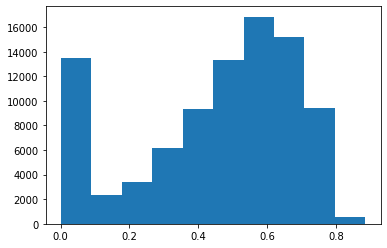

In [191]:
plt.hist(test_pred_total_mean)

In [28]:
# test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('/data/home/brian1501/Minsu/Pregnant/data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('/data/home/brian1501/Minsu/Pregnant/data/Add_feature_Minsu.csv', index=False)

In [ ]:
sample_submission.to_csv('/data/home/brian1501/Minsu/Pregnant/data/Add_feature_reason2_lgbmcat_Minsu_30.csv', index=False)